# EurDyscover

This script structures the data available from different sources, namely video recordings, inscopix and accelerometer for a single session of one animal. Later, the goal is to generalize the code for all files of all animals.

Importantly, it identifies errors, signal misalignments, dropped frames, ...

Most files used to build this script were downloaded to the Desktop from the google drive 'EurDyscover>Organized>Analyzed data'.

In [5]:
# Welcome the user that is going to run the analysis :)
name = input('Please enter your name: ')

In [6]:
if name:
    print("Hello {}! Join me in preparing your data for analysis :). We should start by importing all the necessary files, followed by checking and correcting missing data".format(name))

Hello Diogo! Join me in preparing your data for analysis :). We should start by importing all the necessary files, followed by checking and correcting missing data


---

# 1. Import all the files 

## 1.1 Import neuron.mat
This is a matlab file containing the information of every neuron across time.


The [CNMF-E](https://github.com/zhoupc/CNMF_E) package for extracting calcium traces from microendoscope data outputs Matlab .mat files.  These files represent the data as a custom Matlab class called Sources2D, so they cannot be directly loaded into Python for further analysis.  This repository provides functions for converting the CNMF-E output into Numpy .npy files.

The Matlab function `Sources2D_to_simple_mat` converts the .mat file output by CNMFe to a more basic .mat file that can be opened in Python using `scipy.io.loadmat`.  In order to load the .mat files generated by CNMF-E into Matlab you must also have the file *Sources2D.m* which contains the Matlab class definition in the Matlab file path.

 The Python function `simple_mat_to_npy` converts the  .mat file generated by `Sources2D_to_simple_mat`  to a folder of .npy files with a separate file for each of the variables 'A', 'S', 'C', 'C_raw'.   The A matrix is reshaped such that neuron footprints can be visualised with `plt.imshow(A[0])` etc.

In [7]:
# Using matlab function Sources2D_to_simple_mat, I obtain the data.mat file
path_data = "C:\\Users\\user\\Desktop\\42312_2F_B2\\CNMF-E_mat2npy-master\\data.mat"

from os.path import dirname, join as pjoin
import scipy.io as sio

# this test varible contains the information of the data.mat file 
neuron_mat_info = sio.loadmat(path_data)
neuron_mat_info #python dictionary

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Aug 18 15:41:30 2022',
 '__version__': '1.0',
 '__globals__': [],
 'None': MatlabOpaque([(b'file_name', b'MCOS', b'string', array([[3707764736],
                      [         2],
                      [         1],
                      [         1],
                      [         1],
                      [         1]], dtype=uint32))                   ],
              dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
 'A': <94605x232 sparse matrix of type '<class 'numpy.float64'>'
 	with 48504 stored elements in Compressed Sparse Column format>,
 'C': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.68933050e-08, 6.02981023e-08, 5.43531396e-08],
        [9.38301307e-02, 8.47053864e-02, 7.64680005e-02, ...,
         5.22859009e-05, 4.72012285e-05, 4.26110277e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.72706407e-10, 3.39488589e-10, 3.09231341

In [8]:
import numpy as np

# Convert A from sparse matrix to numpy array. Reshape A to be size [n_neurons, image_y_dim, image_x_dim]
A = neuron_mat_info['A'].toarray().reshape([*np.flip(neuron_mat_info['image_size'][0]),-1]).transpose()
# Convert S from sparse matrix to numpy array.
S = neuron_mat_info['S'].toarray()

I can now access all four variables: 'A', 'S', 'C', 'C_raw'
(A and S directly, and C/C_raw using neuron_mat_info['C']/neuron_mat_info['C_raw'])

In [9]:
import pandas as pd

# check if the shapes of the neural data variables are correct
print('A shape: {}\nS shape: {}\nC shape: {}\nC_raw shape: {}'.format(A.shape, S.shape, neuron_mat_info['C'].shape, neuron_mat_info['C_raw'].shape))
# S, C and C_raw should have the same shape AND shape[0] should be the same for every variable
missing_data = True
if S.shape == neuron_mat_info['C'].shape == neuron_mat_info['C_raw'].shape and A.shape[0]==S.shape[0]:
    missing_data = False
    print('\nThis data looks ok :)')
    calcium_length = neuron_mat_info['C_raw'].shape[1]
else:
    print('There is something wrong with the variable dimensions!') 

#organize calcium signals in a dataframe
df_calcium = pd.DataFrame(neuron_mat_info['C'])
df_calcium = df_calcium.T # transpose the calcium data

# generate a label for each neuron of the dataframe (e.g.: neuron_1)
neuron_labels = []
for neuron in range(1, neuron_mat_info['C'].shape[0]+1):
    neuron_label = 'neuron_'+str(neuron)
    neuron_labels.append(neuron_label)

df_calcium.columns = neuron_labels

# check if the calcium dataframe was created correctly
neuron_data_ready = True
for col, i in zip(df_calcium.columns,range(len(df_calcium))):
    # sets the test value to False if the dimensions of the dataframe do not coincide with the original data or if a null value is find
    if np.sum(df_calcium[col]==neuron_mat_info['C'][i])!=df_calcium.shape[0] or df_calcium.isnull().values.any()==True:
        neuron_data_ready = False

# print a message to inform the user about the data structures being created   
if neuron_data_ready:
    print('\nThe df_calcium dataframe was created correctly :)')    
else:
    print('\nThe df_calcium dataframe is not correct :(')
    
df_calcium # shows the dataframe

A shape: (232, 265, 357)
S shape: (232, 24428)
C shape: (232, 24428)
C_raw shape: (232, 24428)

This data looks ok :)

The df_calcium dataframe was created correctly :)


,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,neuron_10,...,neuron_223,neuron_224,neuron_225,neuron_226,neuron_227,neuron_228,neuron_229,neuron_230,neuron_231,neuron_232
0,0.000000e+00,0.093830,0.000000e+00,0.000000e+00,9.533628e-01,0.000000,0.000000,9.171160e-01,1.124519,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3.201754e-01,0.000000e+00,0.000000,3.350461e-01,2.214608e+00
1,0.000000e+00,0.084705,0.000000e+00,0.000000e+00,9.059918e-01,0.000000,0.000000,8.365491e-01,1.050021,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.785042e-01,0.000000e+00,0.000000,2.730429e-01,2.048264e+00
2,0.000000e+00,0.076468,0.000000e+00,0.000000e+00,8.609746e-01,0.000000,0.000000,7.630599e-01,0.980459,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.422565e-01,0.000000e+00,0.000000,2.225139e-01,1.894414e+00
3,0.000000e+00,0.069032,0.000000e+00,0.000000e+00,8.181943e-01,0.000000,0.000000,6.960265e-01,0.915506,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.107265e-01,0.000000e+00,0.000000,1.813357e-01,1.752120e+00
4,0.000000e+00,0.062319,0.000000e+00,0.000000e+00,7.775396e-01,0.000000,0.000000,6.348819e-01,0.854855,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.833002e-01,0.000000e+00,0.000000,1.477780e-01,1.620514e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24423,8.232669e-08,0.000064,4.492108e-10,3.655113e-24,1.046956e-07,0.154305,0.000170,2.391196e-07,0.249795,0.003817,...,2.591648e-29,8.661168e-12,0.0,9.543449e-27,3.219191e-67,7.025631e-83,9.603638e-08,0.001450,4.633206e-08,1.556635e-41
24424,7.420987e-08,0.000058,4.091745e-10,3.265681e-24,9.949344e-08,0.147256,0.000153,2.181134e-07,0.233247,0.003480,...,2.319320e-29,7.928584e-12,0.0,8.706173e-27,2.965726e-67,6.111236e-83,7.725348e-08,0.001373,3.775791e-08,1.439713e-41
24425,6.689330e-08,0.000052,3.727064e-10,2.917742e-24,9.454978e-08,0.140529,0.000137,1.989526e-07,0.217795,0.003173,...,2.075607e-29,7.257963e-12,0.0,7.942354e-27,2.732217e-67,5.315851e-83,6.214417e-08,0.001301,3.077047e-08,1.331573e-41
24426,6.029810e-08,0.000047,3.394886e-10,2.606873e-24,8.985176e-08,0.134110,0.000124,1.814750e-07,0.203366,0.002892,...,1.857504e-29,6.644066e-12,0.0,7.245547e-27,2.517094e-67,4.623987e-83,4.998994e-08,0.001232,2.507613e-08,1.231555e-41


In [403]:
# the same as the previous cell but for raw data
import pandas as pd

#organize raw calcium signals in a dataframe
df_calcium_raw = pd.DataFrame(neuron_mat_info['C_raw'])
df_calcium_raw = df_calcium_raw.T

neuron_labels = []
for neuron in range(1, neuron_mat_info['C_raw'].shape[0]+1):
    neuron_label = 'neuron_'+str(neuron)
    neuron_labels.append(neuron_label)

df_calcium_raw.columns = neuron_labels

raw_neuron_data_ready = True
for col, i in zip(df_calcium_raw.columns,range(len(df_calcium_raw))):
    if np.sum(df_calcium_raw[col]==neuron_mat_info['C_raw'][i])!=df_calcium_raw.shape[0] or df_calcium_raw.isnull().values.any()==True:
        raw_neuron_data_ready=False
    
if raw_neuron_data_ready:
    print('\nThe df_calcium_raw dataframe was created correctly :)')
    print('You can know proceed to step 1.2')
    
else:
    print('\nThe df_calcium dataframe is not correct :(')
    
df_calcium_raw


The df_calcium_raw dataframe was created correctly :)
You can know proceed to step 1.2


,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,neuron_10,...,neuron_223,neuron_224,neuron_225,neuron_226,neuron_227,neuron_228,neuron_229,neuron_230,neuron_231,neuron_232
0,-0.406129,-0.047769,-0.057460,0.363908,0.062012,-0.822751,0.835407,0.286996,0.556763,-0.122127,...,0.398983,-1.269853,-0.617973,-1.433944,0.969161,0.748030,-1.372244,-1.082244,0.977554,0.473264
1,0.183007,0.064286,-0.324871,-0.469909,0.858696,0.611437,0.561505,0.250338,0.373676,-0.385733,...,-0.176969,-1.670347,-0.936837,-0.849302,-1.961589,-0.215606,-6.017899,-1.252409,-1.280463,-0.038383
2,-0.232672,0.152491,-0.233984,-0.824166,-0.007191,-1.045340,-0.416938,0.318589,0.219718,-0.661488,...,-0.485928,-2.247127,-0.631697,-1.413440,-1.419651,0.895889,-3.276397,-2.735512,-0.179433,1.087864
3,-0.204936,0.007840,-0.587737,-0.105272,-0.327831,-1.282909,0.467048,0.497779,0.639857,-0.114571,...,0.090217,-1.718835,0.740386,-1.475167,-1.177482,1.454110,-0.716491,-1.741940,0.630301,2.266293
4,0.216542,0.446695,-0.752110,0.037540,0.767937,-1.651113,0.112862,0.181789,0.654617,0.074972,...,-0.276067,-1.530954,-0.060764,-0.280535,-2.012925,-1.225314,-2.756372,-3.164117,-0.346409,-0.164486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24423,-0.606995,-0.552580,-0.934403,-0.618884,-2.043891,-1.437259,-0.574520,1.253711,-0.245027,-1.232674,...,0.686536,0.510395,-3.247753,0.143374,-0.256309,-0.573839,-2.012565,3.037851,-0.055204,0.954875
24424,-0.668474,-0.280622,-0.391308,-0.685432,-1.489544,-0.054729,-0.770300,0.841639,-1.313490,-0.770342,...,-0.154207,0.860610,-2.451428,-0.537583,-1.589599,-2.384969,-2.347676,1.410373,-2.515940,2.618795
24425,-0.100028,-0.094912,-0.734686,-0.449700,-0.352617,-0.470470,-0.366492,0.997039,-2.603229,-1.598287,...,-0.184539,0.594848,-2.265827,-1.628178,-0.274957,-0.419261,-1.267465,1.117916,-1.171862,-0.123528
24426,-0.306220,-0.282234,-0.047338,-0.599466,-0.416913,-0.135880,0.022544,1.120818,-2.561249,-1.232654,...,-0.626100,-0.183535,-1.211899,-1.536372,-0.808840,0.505041,-0.668510,0.933554,-2.377353,-0.553212


## 1.2 Import acceldata.csv 
This is the file that contains the timestamps of all the hardware used in a session.

**Useful information**:

'Command' of interest - 3

'RegisterAddress':
- 34 - Accelerometer (sampling_rate = 200 Hz)
- 37 - Camera (sampling_rate = 30 Hz)
- 35 - Inscopix (sampling_rate = 20 Hz)

In this sections, I organize the data from the acceldata.cvs file, and test all the timestamps to make sure you can follow through with the analysis.

I seperately check the data from: Accelerometer, Camera and Microscope (Inscopix)

### Check if there is missing data...

In [10]:
import pandas as pd

path_acceldata = "C:\\Users\\user\\Desktop\\42312_2F_B2\\AccelData2021-04-29T16_15_11.3801984+01_00.csv"

##### A) Accel data AND timestamps...

 With this dataframe I will start by ansewring the following question:
 Are the timestamps of this dataframe in agreement with the dimensions of the data from the following dataframes?

 If NO, ...let the user know (print ERROR messages, and set flags in the locations where the error was found)

 Finally, once everything is checked, I can start the analysis itself namely seeing which initiations detected from the    accelerometer involve the lesioned paw and checking the calcium traces in those cases versus a movement that does not involve the right paw (e.g. moving the head while standing still, initiation with the left paw, for example)

 The data that is going to be used for further analysis is from the first to the last '35' ("Register Address" column), corresponding to the time during which all three channels are ON (accelerometer, camera, microscope). The first '35' corresponds to the first TTL from the Inscopix.

In [12]:
import csv, numpy

def convert(val): 
    try:
        return float(val)
    except:
        return val

with open(path_acceldata, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    values = []
    max_cols = 0
    for index, row in enumerate(spamreader):
        if index==0: continue
        row = list(map(convert, row))
        if len(row)>max_cols: max_cols=len(row)
        values.append(row)

    matrix = []
    for row in values:
        row = row + [None for x in range(max_cols-len(row))]
        matrix.append(row)

    matrix = numpy.array(matrix)
    
matrix_columns = ['Command', 'RegisterAddress', 'Timestamp', 
                  'DataElement0', 'Accel_y','Accel_z', 
                  'Gyr_x','Gyr_y', 'Gyr_z', 
                  'Magn_x', 'Magn_y', 'Magn_z', 
                  'Counter', 
                  'col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28']

df_acceldata = pd.DataFrame(matrix, columns = matrix_columns)
df_acceldata = df_acceldata.apply(pd.to_numeric)
to_drop = ['col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28']
df_acceldata = df_acceldata.drop(columns = to_drop)
df_acceldata #this dataframe contains all the timestamps (camera, inscopix and accelerometer), as well as the accel data itself

,Command,RegisterAddress,Timestamp,DataElement0,Accel_y,Accel_z,Gyr_x,Gyr_y,Gyr_z,Magn_x,Magn_y,Magn_z,Counter
0,2.0,10.0,275355.4745,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,275355.4745,1056.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,32.0,275355.4755,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,275355.4765,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,33.0,275355.4775,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338951,3.0,34.0,276636.3542,-5050.0,2999.0,-6524.0,-65.0,696.0,396.0,114.0,275.0,-318.0,28.0
338952,3.0,34.0,276636.3598,-5099.0,2960.0,-6369.0,-272.0,436.0,649.0,115.0,275.0,-319.0,29.0
338953,3.0,34.0,276636.3642,-5076.0,3003.0,-6238.0,-498.0,355.0,868.0,115.0,275.0,-319.0,30.0
338954,3.0,34.0,276636.3698,-4942.0,3035.0,-6142.0,-577.0,492.0,1140.0,115.0,275.0,-318.0,31.0


In [13]:
# create a dataframe with the accel data exclusively (command=3 and register address = 34)
df_acceldata_accel = df_acceldata.loc[df_acceldata['Command'] == 3].loc[df_acceldata['RegisterAddress'] == 34]

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math

# based on the matlab code Marcelo sent me
fs = 200 #sampling frequency
f_cut = 1/(fs/2)

filter_order = 5
b, a = signal.butter(filter_order, f_cut, 'high')
w, h = signal.freqs(b, a)

#DataElement0 corresponds to Accel_x
x = df_acceldata_accel['DataElement0']
y = df_acceldata_accel['Accel_y']
z = df_acceldata_accel['Accel_z']

medfilt_order = 7
x = signal.medfilt(x, medfilt_order)
y = signal.medfilt(y, medfilt_order)
z = signal.medfilt(z, medfilt_order)

x_BA = signal.filtfilt(b, a, x)
y_BA = signal.filtfilt(b, a, y)
z_BA = signal.filtfilt(b, a, z)

array_sum_x = np.sum(x)
array_has_nan_x = np.isnan(array_sum_x)

array_sum_y = np.sum(y)
array_has_nan_y = np.isnan(array_sum_y)

array_sum_z = np.sum(z)
array_has_nan_z = np.isnan(array_sum_z)

print('Are there any null/none values in the x, y, or z acceldata?: {}'.format(array_has_nan_x+array_has_nan_y+array_has_nan_z))
if array_has_nan_x+array_has_nan_y+array_has_nan_z == False:
    print('No null values were found in the accelerometer data.')

x_GA = x - x_BA 
y_GA = y - y_BA
z_GA = z - z_BA

# metric: high-pass filter followed by the euclidian norm
# the original signal consisted in the three components of ...
# body+gravitational acceleration. After applying a filter, I computed the
# total body acceleration, from which movement initiations will be detected
# euclidian norm/vector magnitude
total_bodyaccel = np.sqrt(x_BA**2+y_BA**2+z_BA**2)

df_acceldata_accel['Total_accel'] = total_bodyaccel
df_acceldata_accel = df_acceldata_accel[['Command', 'RegisterAddress', 'Timestamp', 
                                         'DataElement0', 'Accel_y', 'Accel_z', 
                                         'Gyr_x', 'Gyr_y', 'Gyr_z', 
                                         'Magn_x', 'Magn_y', 'Magn_z', 
                                         'Counter', 
                                         'Total_accel']]


df_acceldata_accel.reset_index(inplace = True, drop = True)
df_acceldata_accel

Are there any null/none values in the x, y, or z acceldata?: False
No null values were found in the accelerometer data.


,Command,RegisterAddress,Timestamp,DataElement0,Accel_y,Accel_z,Gyr_x,Gyr_y,Gyr_z,Magn_x,Magn_y,Magn_z,Counter,Total_accel
0,3.0,34.0,275399.3275,-4891.0,-1286.0,-7312.0,-64.0,-938.0,-2673.0,59.0,301.0,-278.0,91.0,733.448416
1,3.0,34.0,275399.3319,-5877.0,-1316.0,-6562.0,-1274.0,-2232.0,-2851.0,59.0,301.0,-278.0,92.0,865.564038
2,3.0,34.0,275399.3375,-5918.0,-967.0,-6590.0,-2452.0,-3060.0,-3197.0,60.0,301.0,-274.0,93.0,1024.107257
3,3.0,34.0,275399.3419,-5806.0,-976.0,-6522.0,-2654.0,-3187.0,-3237.0,60.0,301.0,-274.0,94.0,1011.194796
4,3.0,34.0,275399.3475,-5985.0,-1261.0,-6424.0,-2368.0,-2861.0,-3035.0,61.0,302.0,-275.0,95.0,887.892693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247592,3.0,34.0,276636.3542,-5050.0,2999.0,-6524.0,-65.0,696.0,396.0,114.0,275.0,-318.0,28.0,618.093446
247593,3.0,34.0,276636.3598,-5099.0,2960.0,-6369.0,-272.0,436.0,649.0,115.0,275.0,-319.0,29.0,466.401927
247594,3.0,34.0,276636.3642,-5076.0,3003.0,-6238.0,-498.0,355.0,868.0,115.0,275.0,-319.0,30.0,377.978456
247595,3.0,34.0,276636.3698,-4942.0,3035.0,-6142.0,-577.0,492.0,1140.0,115.0,275.0,-318.0,31.0,285.678038


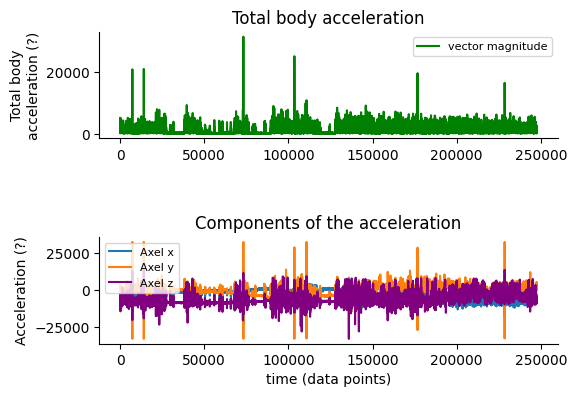

In [771]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2)) = plt.subplots(2,1)
fig.tight_layout(pad=5.0)

# showing the result for the vector magnitude (total body acceleration)
ax1.set_title("Total body acceleration")
ax1.plot(total_bodyaccel, color="green", label = "vector magnitude")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Total body\nacceleration (?)')
ax1.grid(False)
leg = ax1.legend(fontsize=8)

# showing the three components of the acceleration
ax2.set_title("Components of the acceleration")
ax2.plot(df_acceldata_accel['DataElement0'], label = "Axel x")  # Accel_x
ax2.plot(df_acceldata_accel['Accel_y'], label = "Axel y")
ax2.plot(df_acceldata_accel['Accel_z'], label = "Axel z", color = "purple")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Acceleration (?)')
ax2.set_xlabel('time (data points)')
leg2 = ax2.legend(fontsize=8)

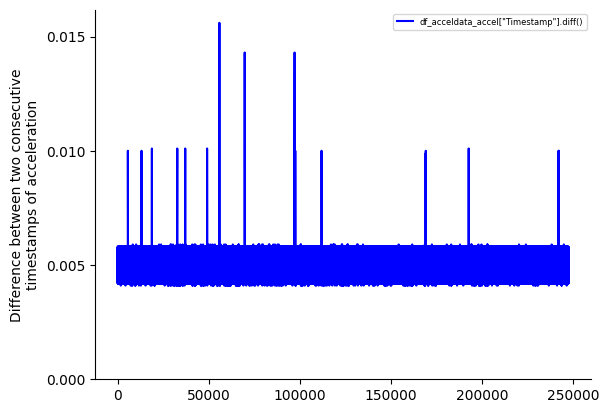

In [238]:
%matplotlib inline

# the diff() values of the timestamps are ideally multiples of the period of the signal, however it should be noted that
# the real values are not perfect multiples

plt.plot(df_acceldata_accel["Timestamp"].diff(
), color="blue", label='df_acceldata_accel["Timestamp"].diff()')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel(
    'Difference between two consecutive\ntimestamps of acceleration')
plt.yticks(np.arange(0, 0.020, 0.005))
leg = plt.legend(fontsize=6)

In [220]:
# let's build a function that finds the nearest multiple of the accel's period, so that we can find the number of missing
# 'timestamps' as (accel_ts/period - 1) - so, for example, a diff of 0.015 will stand for 2 missing ts
def closestMultiple(n, x):
    if x >= n:
        return round(x/n)*n
    else:
        return math.ceil(x/n)*n

In [221]:
# Notice that the length of the diff array is the same as the originl array, BUT the first value is a NaN, since the difference is performed
# between the current and the previous value
len(df_acceldata_accel) == len(df_acceldata_accel["Timestamp"].diff())

True

In [239]:
period_accel = 1/fs
round_accel_ts = []
# round the diffs between consecutive timestamps (notice that the first value, a NaN, is not considered), since the range starts in 1 (instead of 0)
for i in range(1, len(df_acceldata_accel)):
    round_accel_ts.append(closestMultiple(
        period_accel, df_acceldata_accel['Timestamp'].diff()[i]))

# this means that the length of the rounded array is the length of the diff array - 1
len(df_acceldata_accel["Timestamp"].diff()), len(round_accel_ts)

(247597, 247596)

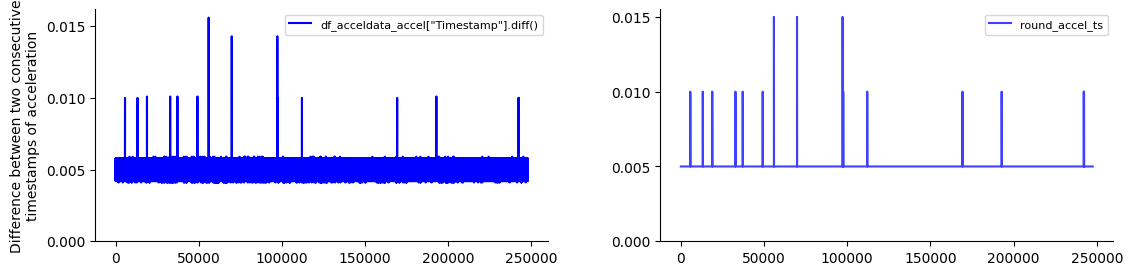

In [769]:
%matplotlib inline

# compare the original and the rounded diffs
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

ax1.plot(df_acceldata_accel["Timestamp"].diff(), color="blue", label= 'df_acceldata_accel["Timestamp"].diff()')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Difference between two consecutive\ntimestamps of acceleration')
ax1.set_yticks(np.arange(0, 0.020, 0.005))
leg = ax1.legend(fontsize=8)

ax2.plot(round_accel_ts, color = "blue", alpha = 0.75, label = "round_accel_ts")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yticks(np.arange(0, 0.020, 0.005))
leg2 = ax2.legend(fontsize=8)

We know where data is missing and the new arrays (acceleration and timestamps) were created correctly :). Now, I shall assign a linearly interpolated value to every -1000!


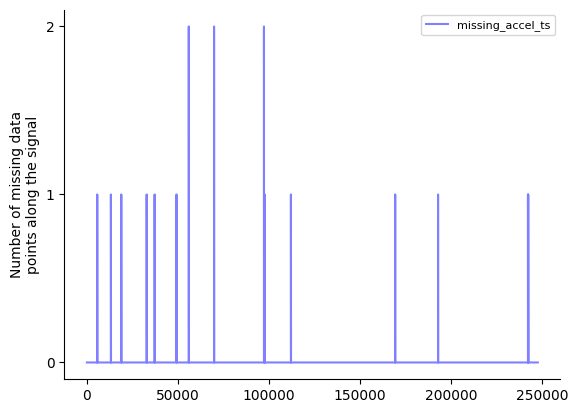

In [770]:
%matplotlib inline

# create an array containing the number of data points missing in the correct index in which those points should be added
missing_accel_ts = [0]
for diff in round_accel_ts:
    missing_accel_ts.append(diff/period_accel-1)

# create a new array that has the value -1000 in the places in which data point values should be interpoalted
total_accel_interpolation = []
# create a new array that has the value -1000 in the places in which timestamp values should be interpolated 
timestamps_accel_interpolation = []

# introduce the value -1000 in every "place" where a data point is missing
for missing, total_accel, ts_accel in zip(missing_accel_ts, df_acceldata_accel['Total_accel'], df_acceldata_accel['Timestamp']):
    # if no data point/timestamp is missing in the current index of the array, then append the current value of acceleration/timestamp
    if missing == 0:
        total_accel_interpolation.append(total_accel)
        timestamps_accel_interpolation.append(ts_accel)
    # if there is missing data, first add the value -1000 as many times as the number of missing data points and only than, add the current value of acceleration
    else:
        # for example, if missing == 2, two temporary points with the value -1000 will be appended to each array, to later be assinged an interpolated value
        for i in range(int(missing)):
            total_accel_interpolation.append(-1000)
            timestamps_accel_interpolation.append(-1000)
        total_accel_interpolation.append(total_accel)
        timestamps_accel_interpolation.append(ts_accel)

# make sure the array sizes match your predictions
if len(total_accel_interpolation)-len(missing_accel_ts) == sum(missing_accel_ts) and len(timestamps_accel_interpolation)-len(missing_accel_ts) == sum(missing_accel_ts):
    print('We know where data is missing and the new arrays (acceleration and timestamps) were created correctly :). Now, I shall assign a linearly interpolated value to every -1000!')
else:
    print('There is something wrong. Do not proceed until this criteria is met!')

plt.plot(missing_accel_ts, label = "missing_accel_ts", color = "blue", alpha = 0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(np.arange(0, 3))
plt.ylabel(
    'Number of missing data\npoints along the signal')
leg = plt.legend(fontsize=8)

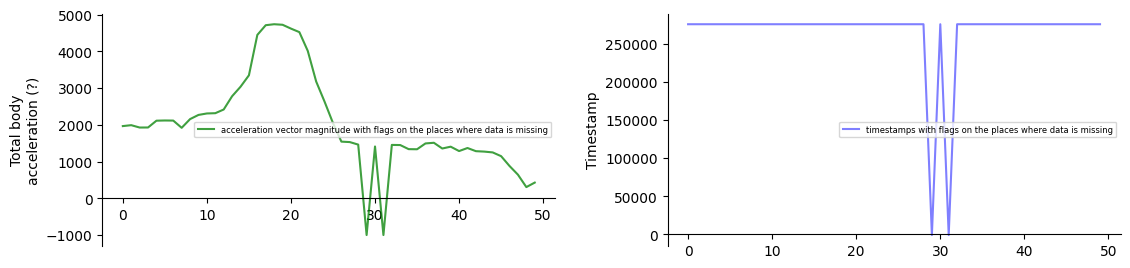

In [246]:
%matplotlib inline

# check the effect of the previous operation (only 50 points of the signal)
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

ax1.plot(total_accel_interpolation[5650:5700], color = "green", alpha = 0.75, label = 'acceleration vector magnitude with flags on the places where data is missing')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Total body\nacceleration (?)')
leg = ax1.legend(fontsize=6)
ax1.spines['bottom'].set_position('zero')

ax2.plot(timestamps_accel_interpolation[5650:5700],
         color="blue", alpha=0.5, label="timestamps with flags on the places where data is missing")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel(
    'Timestamp')
leg = ax2.legend(fontsize=6)
ax2.spines['bottom'].set_position('zero')

5679 1.0
5680 1.0
13181 1.0
18874 1.0
32815 1.0
32816 1.0
37183 1.0
49186 1.0
49201 1.0
55943 1.0
55944 2.0
69825 2.0
97225 2.0
97605 1.0
97606 1.0
112030 1.0
169264 1.0
169271 1.0
169284 1.0
192826 1.0
242189 1.0
242339 1.0


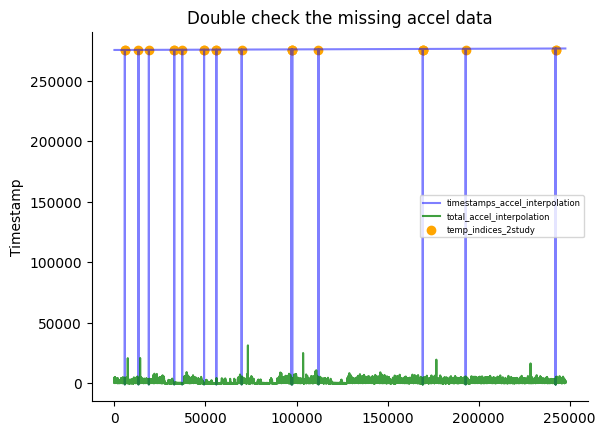

In [247]:
# double check the placement of the spaces for the missing data
# for proper checking you should change inline for tk in "%matplotlib tk" and zoom to see if there is a match
count=0
temp_indices_2study = []
for i, value in enumerate(missing_accel_ts):
    if value != 0 and count==0:
        print(i, value)
        temp_indices_2study.append(i)
        count+=value
    elif value != 0 and count > 0:
        print(i, value)
        temp_indices_2study.append(i+count)
        count+=value

%matplotlib inline
plt.title("Double check the missing accel data")
plt.plot(timestamps_accel_interpolation, label="timestamps_accel_interpolation", color="blue", alpha=0.5)
plt.plot(total_accel_interpolation, color="green", alpha=0.75, label="total_accel_interpolation")
plt.scatter(temp_indices_2study, 275000 *
            np.ones(len(temp_indices_2study)), color='orange', label = "temp_indices_2study")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel(
    'Timestamp')
leg = plt.legend(fontsize=6)


In [248]:
# finds the indices where the missing that is and assigns it the average point using the previous and the next accel values
# if the number of missing timestamps is higher than one, compute the average point and than two other average points
# ... (previous_non_negative to average and average to next_non_negative)

# TOTAL BODY ACCELERATION
# only works for non-consecutive missing data
orig_idx_missing_data = []
#for i, accel_inst in zip(range(len(total_accel_interpolation)), total_accel_interpolation):
for i, accel_inst in enumerate(total_accel_interpolation):
    if accel_inst < 0 and total_accel_interpolation[i-1] >= 0 and total_accel_interpolation[i+1] >= 0:
        orig_idx_missing_data.append(i)
        total_accel_interpolation[i] = (total_accel_interpolation[i+1]+total_accel_interpolation[i-1])/2

# the first for loop computed the missing data in the cases where only one data point is missing
# so, another for loop is necessary for the cases in which two consecutive points are missing        
still_missing = []
for i, accel_inst in enumerate(total_accel_interpolation):
    # now, total_accel_interpolation has only regions in which two or more consecutive "-1000" exist
    if accel_inst < 0:
        # save those locations
        still_missing.append(i)
        orig_idx_missing_data.append(i)
        
still_missing = np.array(still_missing)
# assuming all the cases are two consecutive missing data point and NO MORE, we can build the following structure...
still_missing = still_missing.reshape((int(len(still_missing)/2), 2))

for tuple_missing in still_missing:
    # start by computing a fake middle point to serve as a reference for the following computations
    average_point = (total_accel_interpolation[tuple_missing[0]-1]+total_accel_interpolation[tuple_missing[1]+1])/2
    # average the first non-zero point and the fake average point
    first_tuple = (total_accel_interpolation[tuple_missing[0]-1]+average_point)/2
    # averge the fake average point and the second non-zero point
    second_tuple = (average_point+total_accel_interpolation[tuple_missing[1]+1])/2
    # assing the computed values to its respective locations in "total_body_acceleration"
    total_accel_interpolation[tuple_missing[0]] = first_tuple
    total_accel_interpolation[tuple_missing[1]] = second_tuple

print(orig_idx_missing_data)
if -1000 not in total_accel_interpolation:
    print('All missing data was linearly interpolated.')
    
# IMPORTANT: this code assumes a maximum of 2 consecutive timestamps missing, if an error in this step emerges for other 
# videos, the first thing to check would be if there is 3 or more consecutive missing ts's in the accel data
# Furthermore, notice that the second plot does not result in a perfect linear interpolation (if I want to be more precise I could use a weighted average or an inbuilt method)

# RESPECTIVE TIMESTAMPS
# only works for non-consecutive missing data
orig_idx_missing_ts = []
for i, ts_inst in enumerate(timestamps_accel_interpolation):
    if ts_inst < 0 and timestamps_accel_interpolation[i-1] >= 0 and timestamps_accel_interpolation[i+1] >= 0:
        orig_idx_missing_ts.append(i)
        timestamps_accel_interpolation[i] = (
            timestamps_accel_interpolation[i+1]+timestamps_accel_interpolation[i-1])/2

still_missing = []
for i, ts_inst in enumerate(timestamps_accel_interpolation):
    if ts_inst < 0:
        still_missing.append(i)
        orig_idx_missing_ts.append(i)

still_missing = np.array(still_missing)
still_missing = still_missing.reshape((int(len(still_missing)/2), 2))

for tuple_missing in still_missing:
    average_point = (
        timestamps_accel_interpolation[tuple_missing[0]-1]+timestamps_accel_interpolation[tuple_missing[1]+1])/2
    first_tuple = (
        timestamps_accel_interpolation[tuple_missing[0]-1]+average_point)/2
    second_tuple = (
        average_point+timestamps_accel_interpolation[tuple_missing[1]+1])/2
    timestamps_accel_interpolation[tuple_missing[0]] = first_tuple
    timestamps_accel_interpolation[tuple_missing[1]] = second_tuple

print(orig_idx_missing_ts)
if -1000 not in timestamps_accel_interpolation:
    print('All missing timestamps were linearly interpolated.')

[5679, 5681, 13183, 18877, 32819, 32821, 37189, 49193, 49209, 55952, 97621, 97623, 112048, 169283, 169291, 169305, 192848, 242212, 242363, 55954, 55955, 69837, 69838, 97239, 97240]
All missing data was linearly interpolated.
[5679, 5681, 13183, 18877, 32819, 32821, 37189, 49193, 49209, 55952, 97621, 97623, 112048, 169283, 169291, 169305, 192848, 242212, 242363, 55954, 55955, 69837, 69838, 97239, 97240]
All missing timestamps were linearly interpolated.


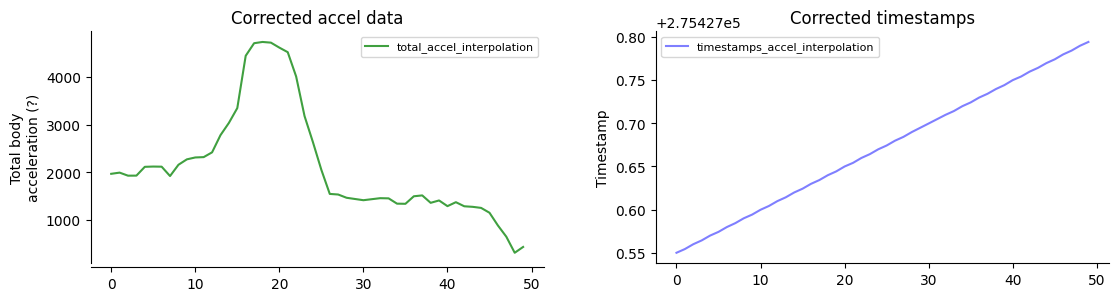

In [768]:
# check the effect of the previous operation (only 50 points of the signal)
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

ax1.set_title("Corrected accel data")
ax1.plot(total_accel_interpolation[5650:5700], color="green", alpha=0.75,
         label='total_accel_interpolation')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Total body\nacceleration (?)')
leg = ax1.legend(fontsize=8)
ax1.spines['bottom'].set_position('zero')

ax2.set_title("Corrected timestamps")
ax2.plot(timestamps_accel_interpolation[5650:5700],
         color="blue", alpha=0.5, label="timestamps_accel_interpolation")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel(
    'Timestamp')
leg = ax2.legend(fontsize=8)

In [324]:
# triple check the missing data
 
# the counter goes from 0 to 127, so by ploting the diff() it should be 1, 126 times followed by a -127, 1 time (repeated)
# any deviation from this pattern, means data loss, so lets find instances
# where counter.diff is different from 1 or -127!

# add 'ghost' rows, do a linear interpolation of the accel data in those rows so that no problem arises in the psth plots??
# add a flag to mark regions of the plot where data is missing?? (maybe not necessary since we are using the timestamps
# as the x axis!!!)

lost_data = np.array(df_acceldata_accel['Counter'].diff())

for i in range(len(lost_data)):
    if lost_data[i] == -127:
        lost_data[i] = 1

# "lost_data" must match "missing_accel_ts"
# to compare the two vectors I will start by subtracting one to every element of losst_data
lost_data = lost_data - 1
lost_data[0] = 0


For now, the triple check failed as the information on missing data using the counter gives the same number of missing points as the other approaches, but consistently two "instants" before!


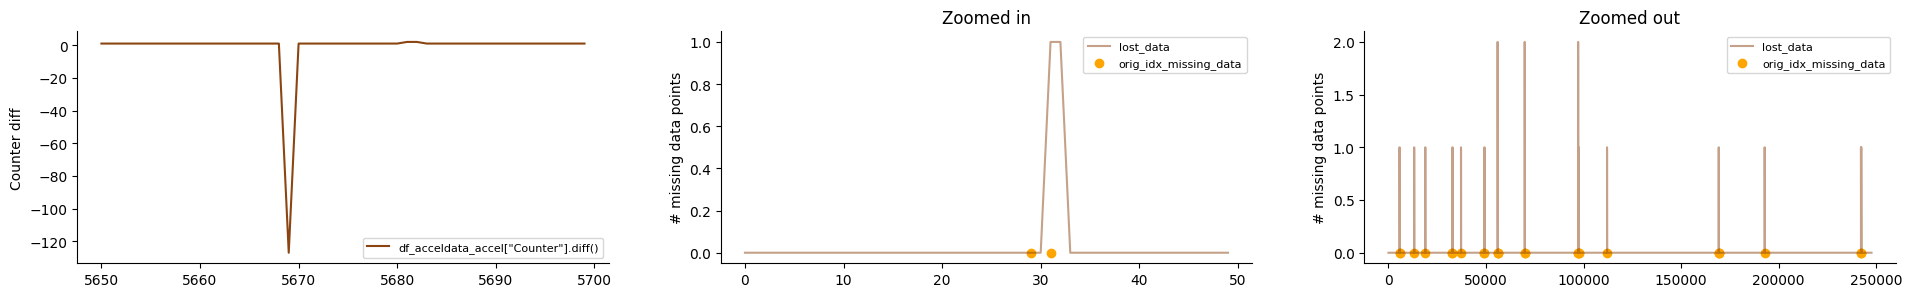

In [767]:
%matplotlib inline

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,4))
fig.tight_layout(pad=5.0)

ax1.plot(df_acceldata_accel['Counter'].diff()[
         5650:5700], color='saddlebrown', label='df_acceldata_accel["Counter"].diff()')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Counter diff')
leg = ax1.legend(fontsize=8)

ax2.set_title("Zoomed in")
ax2.plot(lost_data[5650:5700], color = 'saddlebrown', alpha = 0.50, label = 'lost_data')
ax2.scatter(np.array(orig_idx_missing_data[:2])-5650, np.zeros(2), color='orange', label="orig_idx_missing_data")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel(
    '# missing data points')
leg = ax2.legend(fontsize=8)

ax3.set_title("Zoomed out")
ax3.plot(lost_data, color='saddlebrown',
         alpha=0.50, label='lost_data')
ax3.scatter(orig_idx_missing_data, np.zeros(25), color='orange', label="orig_idx_missing_data")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_ylabel(
    '# missing data points')
leg = ax3.legend(fontsize=8)

print('For now, the triple check failed as the information on missing data using the counter gives the same number of missing points as the other approaches, but consistently two "instants" before!')

In [368]:
# create a dataframe where both the timestamps and accel values interpolated will be stored
df_timestamps_accel_interpolation = pd.DataFrame(
    timestamps_accel_interpolation)

# change the name of the column containing the timestamps
df_timestamps_accel_interpolation = df_timestamps_accel_interpolation.rename(
    columns={0: 'Timestamps'})
# add the complete (interpolated) total body acceleration data to the df
df_timestamps_accel_interpolation['Total_accel'] = total_accel_interpolation

# show the df
df_timestamps_accel_interpolation

,Timestamps,Total_accel
0,275399.3275,733.448416
1,275399.3319,865.564038
2,275399.3375,1024.107257
3,275399.3419,1011.194796
4,275399.3475,887.892693
...,...,...
247617,276636.3542,618.093446
247618,276636.3598,466.401927
247619,276636.3642,377.978456
247620,276636.3698,285.678038


Notice that the correction of the timestamps isn't perfect. This effect is most noticeable in regions where two consecutive points were missing.


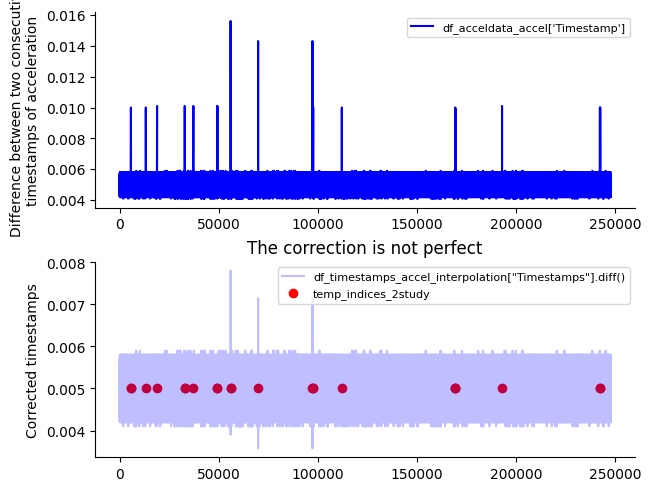

In [766]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=False)

ax1.plot(df_acceldata_accel["Timestamp"].diff(), label = "df_acceldata_accel['Timestamp']", color = "blue")
ax1.scatter(temp_indices_2study, 0.005 *
            np.ones(len(temp_indices_2study)), c="r")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Difference between two consecutive\ntimestamps of acceleration')
leg = ax1.legend(fontsize=8)

ax2.set_title("The correction is not perfect")
ax2.plot(df_timestamps_accel_interpolation["Timestamps"].diff(
), label='df_timestamps_accel_interpolation["Timestamps"].diff()', color='blue', alpha=0.25)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(temp_indices_2study, 0.005 *
            np.ones(len(temp_indices_2study)), c="r", label = 'temp_indices_2study')
ax2.set_ylabel(
    'Corrected timestamps')
leg = ax2.legend(fontsize=8)

print('Notice that the correction of the timestamps isn\'t perfect. This effect is most noticeable in regions where two consecutive points were missing.')

In [372]:
# final test before checking the camera and inscopix data (not really a test, more of a warning)
accel_TTL_correct = False
if sum(lost_data) > 0:
    accel_TTL_correct = True
    print('Some accel data was lost. This should not be problematic since the timestamps (x) will be used to plot the accel data (y). This means that, when plotting, using the timestamps as the x-axis, the lost data will be linearly interpolated.')
    print('\nNow, let\'s check the timestamps from the camera!')
elif  sum(lost_data[1:]) == 0:
    accel_TTL_correct = True
    print('No lost data :). Now, let\'s check the timestamps from the camera!')

Some accel data was lost. This should not be problematic since the timestamps (x) will be used to plot the accel data (y). This means that, when plotting, using the timestamps as the x-axis, the lost data will be linearly interpolated.

Now, let's check the timestamps from the camera!


#####  B) Camera timestamps...

In [373]:
import math

# in the following steps I will need to check if the lenght of this df
# is coherent with the onces from DLC predictions, frame diff and velocities

# keep in mind that it is possible for the last TTL to have no correspondant frame (the TTL may have been sent but the frame 
# was not recorded, for example) - furthermore, it is only problematic when the 'missing frame' is between the first and last
# inscopix TTL's, since that is the region that counts for the session (inscopix, camera and accel - ON)

df_acceldata_camera = df_acceldata.loc[df_acceldata['Command'] == 3].loc[df_acceldata['RegisterAddress'] == 37]

camera_aq_rate = 30 #Hz
camera_period = round(1/camera_aq_rate, 3)

df_acceldata_camera = df_acceldata_camera[['Command','RegisterAddress','Timestamp','DataElement0']]
df_acceldata_camera = df_acceldata_camera.reset_index(drop=True)

camera_TTL_correct_temp = True
for camera_TTL in range(1,len(df_acceldata_camera)):
    if round(df_acceldata_camera['Timestamp'].diff()[camera_TTL], 2) != round(camera_period, 2):
        print('A frame was lost here :(')
        camera_TTL_correct_temp = False
if camera_TTL_correct_temp:
    print('The camera timestamps are correct. No frames were dropped :)')
    print('Now, let\'s check the timestamps from the Inscopix!')
    
df_acceldata_camera

The camera timestamps are correct. No frames were dropped :)
Now, let's check the timestamps from the Inscopix!


,Command,RegisterAddress,Timestamp,DataElement0
0,3.0,37.0,275399.3020,1.0
1,3.0,37.0,275399.3354,1.0
2,3.0,37.0,275399.3687,1.0
3,3.0,37.0,275399.4020,1.0
4,3.0,37.0,275399.4354,1.0
...,...,...,...,...
37109,3.0,37.0,276636.2192,1.0
37110,3.0,37.0,276636.2525,1.0
37111,3.0,37.0,276636.2859,1.0
37112,3.0,37.0,276636.3192,1.0


##### C) Inscopix timestamps...

This needs to match the neuron.mat data.

In [399]:
import math

df_acceldata_inscopix = df_acceldata.loc[df_acceldata['Command'] == 3].loc[df_acceldata['RegisterAddress'] == 35]

inscopix_aq_rate = 20 #Hz
inscopix_period = round(1/inscopix_aq_rate, 3)

df_acceldata_inscopix = df_acceldata_inscopix.reset_index(drop=True)
df_acceldata_inscopix = df_acceldata_inscopix[['Command','RegisterAddress','Timestamp','DataElement0']]

inscopix_TTL_correct = True
for inscopix_TTL in range(1,len(df_acceldata_inscopix)):
    if round(df_acceldata_inscopix['Timestamp'].diff()[inscopix_TTL], 3) != inscopix_period/2:
        print('Some TTL is missing :(')
        inscopix_TTL_correct = False
    
# I also need to check if the dimensions of the neuron data fit this 
# ...timestamps
if len(df_acceldata_inscopix[::2]) != calcium_length:
    inscopix_TTL_correct = False
    print('This data is not matching the neuron.mat data :(')
else:
    print('This data matches the data from the neuron.mat file :)')

df_acceldata_inscopix

This data matches the data from the neuron.mat file :)


,Command,RegisterAddress,Timestamp,DataElement0
0,3.0,35.0,275406.7676,16416.0
1,3.0,35.0,275406.7926,32801.0
2,3.0,35.0,275406.8176,16419.0
3,3.0,35.0,275406.8426,32.0
4,3.0,35.0,275406.8676,16418.0
...,...,...,...,...
48851,3.0,35.0,276628.3436,33883.0
48852,3.0,35.0,276628.3686,17501.0
48853,3.0,35.0,276628.3936,1116.0
48854,3.0,35.0,276628.4187,17501.0


##### Add timestamps to the 'neuron.mat' data...

In [406]:
# I will consider one Inscopix TTL for each two saved in acceldata.csv file
df_inscopix_ts = df_acceldata['Timestamp'].loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==35][::2]
df_inscopix_ts.reset_index(inplace = True, drop = True)
df_calcium['Timestamp'] = df_inscopix_ts
df_calcium_raw['Timestamp'] = df_inscopix_ts

## 1.3 Import FrameDiff_Centroid.csv 
This file is important to check for lost frames.

In [410]:
path_framediff = "C:\\Users\\user\\Desktop\\42312_2F_B2\\FrameDiff_Centroid2021-04-29T16_15_11.csv"
df_framediff = pd.read_csv(path_framediff, header=None)
df_framediff.rename(columns={0:'Frame diff'})

camera_TTL_correct = camera_TTL_correct_temp

import re
for index in range(len(df_framediff)):
    date = re.search(r' \d \d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12][0-9]|3[01])', df_framediff.iloc[index][0])
    df_framediff.at[index, 'Frame diff'] = date.group()[1]

df_framediff = df_framediff.drop(0, axis = 1)
df_framediff['Frame diff'] = pd.to_numeric(df_framediff['Frame diff'])

# checking if the dimensions of this dataframe are coherent with TTLs from the camera

# keep in mind that it is possible for the last TTL to have no correspondant frame (the TTL may have been send but the frame 
# was not recorded, for example) - furthermore, it is only problematic when the 'missing frame' is between the first and last
# inscopix TTLs, since that is the region that counts for the session (inscopix, camera and accel - ON)
if len(df_acceldata.loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress'] == 37]) - (len(df_framediff)+1) > 1:
    camera_TTL_correct = False

# checks of there is a frame diff > 1, which would stand for 'lost frames' (somewhere on 'Command 3')
if int(np.sum(df_framediff.loc[df_framediff['Frame diff'] > 1])) == 0 and camera_TTL_correct:
    print('No frames were dropped :)')
else:
    print('The number of TTLs from the camera (acceldata), does not match the length of Frame_diff! It looks like some frames were dropped :(')

df_framediff

No frames were dropped :)


,Frame diff
0,1
1,1
2,1
3,1
4,1
...,...
37107,1
37108,1
37109,1
37110,1


## 1.4 Import the video (processed) of the session

In [411]:
path_VideoProcessed = "C:\\Users\\user\\Desktop\\42312_2F_B2\\VideoProcessed2021-04-29T16_15_55.avi"
# start by checking the total number of frames in this video, which should match the length of the DLC predictions
import cv2
import numpy as np
vidcap = cv2.VideoCapture(path_VideoProcessed)
total_frames = vidcap.get(7) #returns the number of frames of the video
total_frames

37113.0

## 1.5 Import DLC predictions .csv
This is the file containing the x,y coordinates of the bodyparts of interest predicted by the DLC network. Each label is accompained by the likelihood of it being correct. 

In [412]:
path_predictions_DLC = "C:\\Users\\user\\Desktop\\42312_2F_B2\\VideoProcessed2021-04-29T16_15_55DLC_resnet50_Dystonia_TestApr21shuffle1_500000.csv"
df_DLC = pd.read_csv(path_predictions_DLC)
df_DLC = df_DLC.drop(columns='scorer')
df_DLC.iloc[0] + ' ' + '(' + df_DLC.iloc[1] + ')'
df_DLC.iloc[0] = df_DLC.iloc[0] + ' ' + '(' + df_DLC.iloc[1] + ')'
df_DLC.drop(index=1)
df_DLC.columns = df_DLC.iloc[0]
df_DLC = df_DLC.drop(index=0)
df_DLC = df_DLC.drop(index=1)
df_DLC.reset_index(inplace = True, drop = True)
for column in df_DLC.columns:
    df_DLC[column] = pd.to_numeric(df_DLC[column])

DLC_predictions_ready = False    
if len(df_DLC) == len(df_framediff)+1 == total_frames:
    print('The dataframe with DLC predictions is ready. The dimensions of this df match the total number of frames in the video :)')
    DLC_predictions_ready = True
else:
    print('The DLC predictions don\'t match the Frame diff')

# complete the dataframe by adding a column with the camera timestamps
camera_timestamps = df_acceldata['Timestamp'].loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==37]
camera_timestamps.reset_index(inplace = True, drop = True)
df_DLC['Timestamp'] = camera_timestamps

df_DLC #dataframe with the DLC predictions

C:\Users\user\AppData\Local\Temp\ipykernel_29260\1182618765.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_DLC = pd.read_csv(path_predictions_DLC)


The dataframe with DLC predictions is ready. The dimensions of this df match the total number of frames in the video :)


,nose (x),nose (y),nose (likelihood),tailbase (x),tailbase (y),tailbase (likelihood),tailtip (x),tailtip (y),tailtip (likelihood),left_frontlimb_digitaltip (x),...,right_frontlimb_heel (x),right_frontlimb_heel (y),right_frontlimb_heel (likelihood),left_hindlimb_heel (x),left_hindlimb_heel (y),left_hindlimb_heel (likelihood),right_hindlimb_heel (x),right_hindlimb_heel (y),right_hindlimb_heel (likelihood),Timestamp
0,703.989075,109.582817,0.999959,565.206299,64.867920,0.999996,445.494476,85.937485,0.999992,672.765625,...,646.727905,64.381477,0.967808,569.689392,82.955177,0.999935,595.056152,47.734856,0.998693,275399.3020
1,705.924377,116.035568,0.999999,569.691772,65.645523,0.999984,449.193756,79.449432,0.999983,670.523438,...,666.607910,80.834373,0.968636,572.499634,81.936455,0.999638,596.521179,48.103065,0.999149,275399.3354
2,711.785583,118.557358,0.999998,575.658203,64.463608,0.999923,453.932098,72.325569,0.999981,670.901306,...,684.069153,93.431816,0.998110,575.792603,79.244659,0.999684,599.098511,49.064873,0.999250,275399.3687
3,714.602661,120.410118,0.999976,580.195007,63.737652,0.999988,459.874084,67.750328,0.999994,670.257080,...,690.320740,95.466553,0.999417,579.551697,81.048454,0.999733,601.921143,48.129837,0.999159,275399.4020
4,721.245789,121.846405,0.999992,587.219116,64.561485,0.999910,467.661896,67.922020,0.999998,671.724060,...,695.163635,94.794434,0.997733,583.064758,78.803604,0.998690,605.472717,48.319180,0.998719,275399.4354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37108,679.074097,169.885544,0.746022,696.506592,111.462242,0.999984,619.093933,50.051315,0.999972,626.738892,...,664.814636,161.185226,0.970159,672.147644,123.665230,0.996423,694.438171,144.265381,0.998994,276636.1859
37109,679.212158,169.614487,0.627104,696.559998,111.513847,0.999984,618.883423,52.940262,0.999976,627.074768,...,663.518005,161.472198,0.945097,672.501709,123.696381,0.996318,694.466858,144.530197,0.999128,276636.2192
37110,603.555359,136.817764,0.970762,697.931335,112.178101,0.999958,621.939941,51.141613,0.999969,626.684265,...,645.553528,157.127716,0.988420,670.552734,123.600143,0.997666,694.630188,145.465958,0.999550,276636.2525
37111,605.983887,136.335541,0.767845,698.152649,114.096436,0.999980,628.783142,49.886978,0.999981,626.778809,...,643.263794,159.036041,0.999342,670.412964,125.062004,0.999212,694.155090,146.660553,0.999359,276636.2859


In [413]:
#don't run this cell more than once (if you did, re-run the previous cell before running the present one)
import numpy as np
df_vel = df_DLC.copy(deep=False)

for column in df_vel.columns:
    if ('likelihood' and 'Timestamp') not in column :
        df_vel[column] = np.abs(df_vel[column].diff())

my_list=[]
for col in df_vel.columns:
    if 'likelihood' not in col:
        my_list.append('Vel - ' + col)

for col in df_vel.columns:
    for new_name in my_list:
        if col in new_name:
            df_vel.rename({col:new_name}, axis=1, inplace=True)
            
for col in df_vel.columns:
    if '(likelihood)' in col:
        loc = df_vel.columns.get_loc(col)
        V_xy = np.sqrt(df_vel[df_vel.columns[loc-2]]**2+df_vel[df_vel.columns[loc-1]]**2)
        name_column = 'V_xy_'+df_vel.columns[loc].split(" ")[0]
        df_vel.insert(loc, name_column, V_xy)

# I dropped the first row (NaN values) since, every row represents a diff between the coordinates of consecutive frames
df_vel = df_vel.drop(index=0)
df_vel.reset_index(inplace = True, drop = True)
        
# programm a green sign test to see if everything is ok with the data from 
# the current step
Velocity_data_ready = False
if len(df_framediff)+1 == len(df_vel)+1 == len(df_DLC):
    print('The dimensions of the frame diff, DLC predictions and bodypart velocity dataframes are coherent :)')
    Velocity_data_ready = True
else:
    print('The dimensions of the frame diff, DLC predictions and bodypart velocity dataframes are NOT coherent :(')
    
df_vel #dataframe with the velocities (x, y and absolute - px/frame) obtained from the DLC predictions

The dimensions of the frame diff, DLC predictions and bodypart velocity dataframes are coherent :)


,Vel - nose (x),Vel - nose (y),V_xy_nose,nose (likelihood),Vel - tailbase (x),Vel - tailbase (y),V_xy_tailbase,tailbase (likelihood),Vel - tailtip (x),Vel - tailtip (y),...,right_frontlimb_heel (likelihood),Vel - left_hindlimb_heel (x),Vel - left_hindlimb_heel (y),V_xy_left_hindlimb_heel,left_hindlimb_heel (likelihood),Vel - right_hindlimb_heel (x),Vel - right_hindlimb_heel (y),V_xy_right_hindlimb_heel,right_hindlimb_heel (likelihood),Vel - Timestamp
0,1.935303,6.452751,6.736720,4.005432e-05,4.485474,0.777603,4.552377,1.239777e-05,3.699280,6.488052,...,0.000828,2.810242,1.018723,2.989190,0.000296,1.465027,0.368210,1.510590,0.000456,275399.3354
1,5.861206,2.521790,6.380686,1.192093e-07,5.966431,1.181915,6.082369,6.127357e-05,4.738342,7.123863,...,0.029474,3.292969,2.691795,4.253164,0.000046,2.577332,0.961807,2.750947,0.000100,275399.3687
2,2.817078,1.852760,3.371742,2.205372e-05,4.536804,0.725956,4.594519,6.592274e-05,5.941986,4.575241,...,0.001307,3.759094,1.803795,4.169468,0.000049,2.822632,0.935036,2.973473,0.000091,275399.4020
3,6.643127,1.436287,6.796621,1.525879e-05,7.024109,0.823833,7.072256,7.855892e-05,7.787811,0.171692,...,0.001684,3.513062,2.244850,4.169047,0.001043,3.551575,0.189342,3.556618,0.000440,275399.4354
4,4.830872,1.468178,5.049046,3.695488e-06,5.566833,0.099838,5.567729,6.186962e-05,5.539978,1.436821,...,0.000104,14.130554,6.424660,15.522526,0.001295,0.949280,0.241886,0.979613,0.000475,275399.4687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37107,76.738953,10.639099,77.472945,1.434436e-01,1.092590,0.824089,1.368531,1.668930e-05,4.606018,3.213882,...,0.008292,0.160950,0.131798,0.208028,0.000575,0.258301,0.014069,0.258684,0.000207,276636.1859
37108,0.138062,0.271057,0.304192,1.189179e-01,0.053406,0.051605,0.074265,3.576279e-07,0.210510,2.888947,...,0.025063,0.354065,0.031151,0.355433,0.000105,0.028687,0.264816,0.266366,0.000135,276636.2192
37109,75.656799,32.796722,82.459543,3.436582e-01,1.371338,0.664253,1.523745,2.586842e-05,3.056519,1.798649,...,0.043323,1.948975,0.096237,1.951349,0.001347,0.163330,0.935760,0.949908,0.000422,276636.2525
37110,2.428528,0.482224,2.475942,2.029172e-01,0.221313,1.918335,1.931059,2.181530e-05,6.843201,1.254635,...,0.010922,0.139771,1.461861,1.468527,0.001547,0.475098,1.194595,1.285603,0.000191,276636.2859


---

## Final test before proceeding

In [415]:
# have a bool variable the gives an overall approval of the data for analysis
# for example, if everything is ok, all dimensions, no missed data, etc
# it should be TRUE
can_advance = False

tests = [neuron_data_ready, raw_neuron_data_ready, accel_TTL_correct, camera_TTL_correct, inscopix_TTL_correct, DLC_predictions_ready, Velocity_data_ready]

if sum(tests) == len(tests):
    can_advance = True
    print('Data is ready for analysis :)')
else:
    print('Either there is missing data or you haven\'t yet run all the necessary cells preceding the analysis!')

first_TTL_inscopix = df_acceldata.loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==35].index[0]
last_TTL_inscopix = df_acceldata.loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==35].index[-1]

if can_advance:
    # this df contains the TTL information of the session (from the first to the last inscopix TTL)
    df_session = df_acceldata[first_TTL_inscopix:last_TTL_inscopix+1]
    df_session.reset_index(inplace = True, drop = True)
df_session

#this final test should be improved regarding missing accel data (for example), in which several tests were performed. No boolean was defined regarding the performed interpolation to be accounted for in the present cell

Data is ready for analysis :)


,Command,RegisterAddress,Timestamp,DataElement0,Accel_y,Accel_z,Gyr_x,Gyr_y,Gyr_z,Magn_x,Magn_y,Magn_z,Counter
0,3.0,35.0,275406.7676,16416.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,37.0,275406.7684,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,34.0,275406.7702,-2751.0,-373.0,-7766.0,-2003.0,-134.0,-904.0,109.0,215.0,-333.0,45.0
3,3.0,34.0,275406.7745,-3438.0,-52.0,-7687.0,-2653.0,-859.0,-1133.0,109.0,215.0,-333.0,46.0
4,3.0,34.0,275406.7801,-4283.0,5.0,-7370.0,-2616.0,-1464.0,-1255.0,110.0,216.0,-335.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
335216,3.0,34.0,276628.4267,-7471.0,-4691.0,-649.0,769.0,-2091.0,-1176.0,104.0,305.0,-302.0,105.0
335217,3.0,34.0,276628.4309,-7069.0,-4282.0,-418.0,383.0,-1561.0,-662.0,104.0,305.0,-302.0,106.0
335218,3.0,34.0,276628.4365,-6429.0,-4132.0,151.0,285.0,-1368.0,-231.0,107.0,306.0,-300.0,107.0
335219,3.0,34.0,276628.4409,-6941.0,-4165.0,992.0,-164.0,-1486.0,54.0,107.0,306.0,-300.0,108.0


I think I don't need the df_session dataframe. The first_TTL_inscopix and the last_TTL_inscopix will allow me to build the plots containing only information from the session :)

---

# 2. Align initiations to neuronal data

### This should be divided in two main problems:
##### A) Initiation detection (more technical problem)
Which of the lesioned paw initiations (DLC velocity) are 'associated' with initiations from the accelerometer?
##### B) Alignment itself (more scientific problem)
To what should I align the initiations; Groups of neurons?, and should they always fire?, ... ; What are the scientific questions I want answered? (psth)

### ...from now on, you should only consider the data from the first to the last Inscopix TTL

In [416]:
# build a function that calculates moving averages
# the result will have a len = len(original data) - (window - 1)
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# A)

## 2.1 Detection itself

## 2.1.1 Detecting initiations using the accelerometer data

In [533]:
# this window should be carefully looked at
filtering_window = 20
# filter the processed data regarding total body acceleration
accel_interp_filtered = moving_average(df_timestamps_accel_interpolation['Total_accel'], filtering_window)

The filtered signal has 19 points less compared to the original (interpolated) signal!


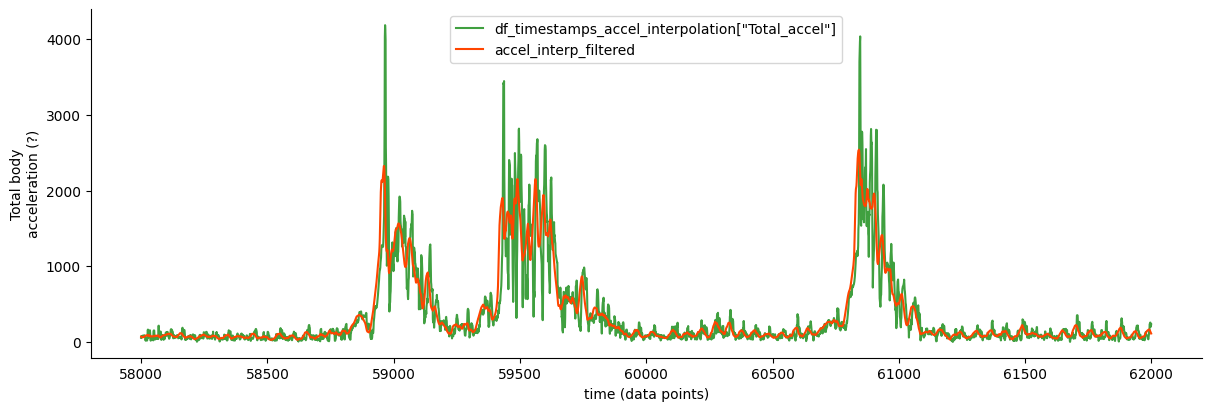

In [765]:
%matplotlib inline
# illustrate the effect of the filter in a chunck of signal
fig, (ax1) = plt.subplots(1, 1, constrained_layout=False, figsize = (12, 4))

# interpolated accel data
ax1.plot(df_timestamps_accel_interpolation['Total_accel'][58000:62000], label = 'df_timestamps_accel_interpolation["Total_accel"]', color = 'green', alpha = 0.75)
# filtered interpolated data
ax1.plot(np.arange(58000, 62000, 1), accel_interp_filtered[58000:62000], label = 'accel_interp_filtered', color = 'orangered')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Total body\nacceleration (?)')
ax1.set_xlabel('time (data points)')
leg = ax1.legend(fontsize=10)

diff_interp_filtered = len(df_timestamps_accel_interpolation) - len(accel_interp_filtered)
print('The filtered signal has {} points less compared to the original (interpolated) signal!'.format(diff_interp_filtered))

COMPLETE THE PLOTS DESCRIBING THE INTERMEDIARY STEPS FROM THIS POINT DOWN!

### Initiations - total body acceleration (original)

###### Local minimum between the two modes of a bimodal distribution...

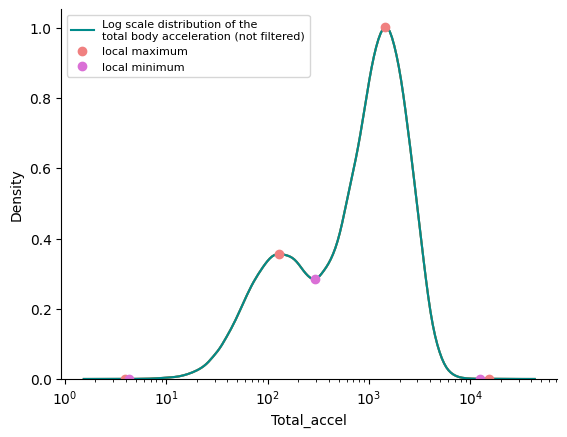

We consider the cutOff to be at 292.59


In [745]:
%matplotlib inline
#consider a movement initiation every time the acceleration raises above 
#...the beginning of a local minimum in the log distribution of total body accelerations
#...the local minimum is to be found in the valley forming inbetween the two peaks of
#...the log scale distribution

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# total body acceleration data (after interpolation of missing data)
ax_interp = sns.kdeplot(df_timestamps_accel_interpolation["Total_accel"], log_scale=True)

kde_curve_interp = ax_interp.lines[0]

x_interp = kde_curve_interp.get_xdata()
y_interp = kde_curve_interp.get_ydata()

plt.plot(x_interp, y_interp)
peaks_interp = np.where((y_interp[1:-1] > y_interp[0:-2]) * (y_interp[1:-1] > y_interp[2:]))[0] + 1
dips_interp = np.where((y_interp[1:-1] < y_interp[0:-2]) * (y_interp[1:-1] < y_interp[2:]))[0] + 1

plt.plot(x_interp, y_interp, color='darkcyan', label = "Log scale distribution of the\ntotal body acceleration (not filtered)")
plt.plot(x_interp[peaks_interp], y_interp[peaks_interp], 'o', label = "local maximum", color = 'lightcoral')
plt.plot(x_interp[dips_interp], y_interp[dips_interp], 'o', label = "local minimum", color = 'orchid')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)
plt.show()

for i in range(len(peaks_interp)):
    # this is tricky, since some distributions may be multimodal
    # ...or have multiple local minimums which would make this computation not trivial (nor easily generalizable)
    cutOff_accel = x_interp[dips_interp[1]]
    break

print("We consider the cutOff to be at {}".format(round(cutOff_accel, 2)))

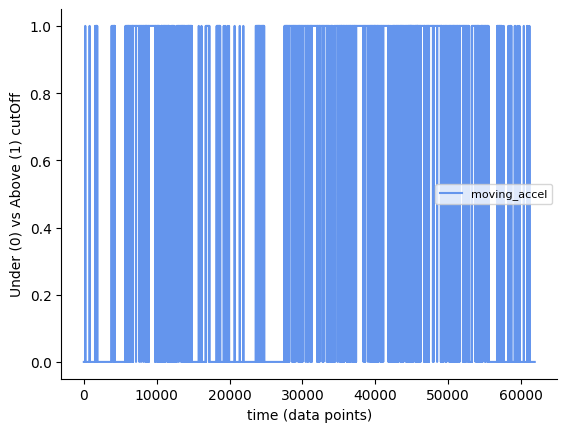

In [764]:
%matplotlib inline

# movement bouts detected from the accelerometer data
moving_accel = [1 if df_timestamps_accel_interpolation["Total_accel"][timestamp] >=
                cutOff_accel else 0 for timestamp in range(len(df_timestamps_accel_interpolation))]

# showing only a chunk of the signal
plt.plot(moving_accel[int(len(moving_accel)/4):2*int(len(moving_accel)/4)], color='cornflowerblue', label = 'moving_accel')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (data points)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

###### Crossing point between two gaussians fitted to the kernel density estimation... (not correct yet)

We consider the cutOff to be at 6.15


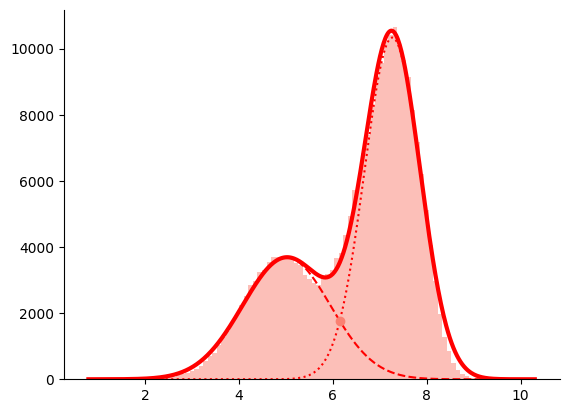

In [545]:
# obtain the treshold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(df_timestamps_accel_interpolation['Total_accel']), bins=100, color='salmon', alpha = 0.5)

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (4, .1, max(y)/2, 7, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='salmon')

cutOff_interp_cg = intersection.xy[0][0]

#not the real cutoff since I used the log of the data
print("We consider the cutOff to be at {}".format(round(cutOff_interp_cg, 2)))

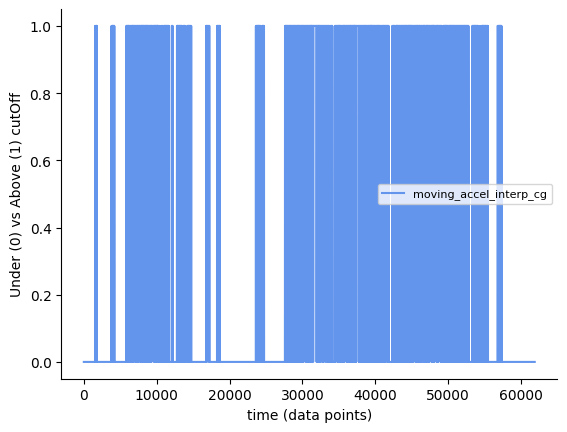

In [763]:
# obtain periods of movement (cg - cross gaussian)
moving_accel_interp_cg = [1 if np.log(df_timestamps_accel_interpolation['Total_accel'][timestamp])
                          >= cutOff_interp_cg else 0 for timestamp in range(len(df_timestamps_accel_interpolation))]

# showing only a chunk of the signal (the region shown should be changed given the filtering, which 'pushes' the signal to the left)
plt.plot(moving_accel_interp_cg[int(len(moving_accel_interp_cg)/4):2*int(len(moving_accel)/4)],
         color='cornflowerblue', label='moving_accel_interp_cg')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (data points)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

### Initiations - total body acceleration (filtered)

##### Local minimum between the two modes of a bimodal distribution...

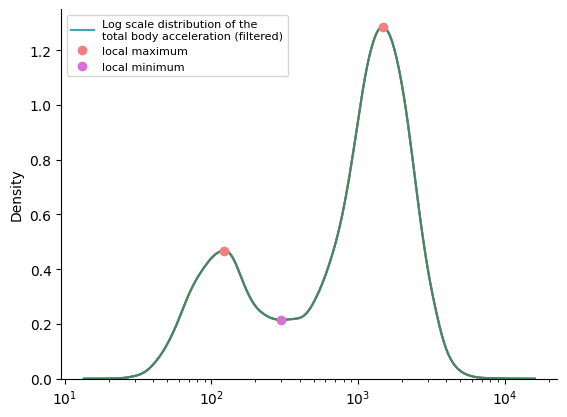

We consider the cutOff to be at 298.52


In [746]:
%matplotlib inline

#consider a movement initiation every time the acceleration raises above 
#...the beginning of a local minimum in the log distribution of total body accelerations
#...the local minimum is to be found in the valley forming the two peaks of
#...the log_scale distribution

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# raw acceleration data (total body acceleration)
ax = sns.kdeplot(accel_interp_filtered,  log_scale=True)

kde_curve = ax.lines[0]

x = kde_curve.get_xdata()
y = kde_curve.get_ydata()

plt.plot(x, y)
peaks = np.where((y[1:-1] > y[0:-2]) * (y[1:-1] > y[2:]))[0] + 1
dips = np.where((y[1:-1] < y[0:-2]) * (y[1:-1] < y[2:]))[0] + 1

plt.plot(x, y, color='darkcyan', alpha=0.75, label="Log scale distribution of the\ntotal body acceleration (filtered)")
plt.plot(x[peaks], y[peaks], 'o', color = 'lightcoral', label = 'local maximum')
plt.plot(x[dips], y[dips], 'o', color = 'orchid', label = 'local minimum')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)
plt.show()

for i in range(len(peaks)):
    # this is tricky, since some distributions may be multimodal
    cutOff_accel_filtered = x[dips[0]]
    break

print("We consider the cutOff to be at {}".format(round(cutOff_accel_filtered, 2)))

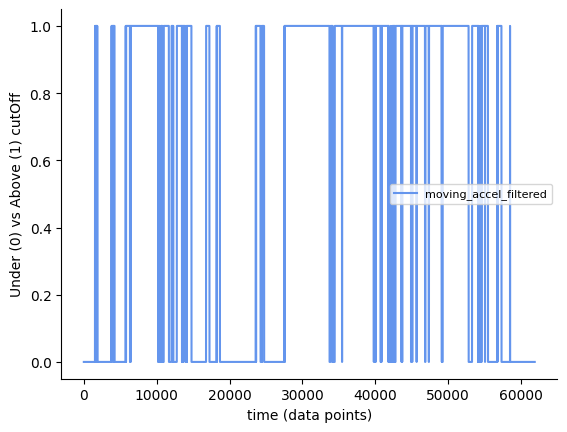

In [762]:
%matplotlib inline

moving_accel_filtered = [1 if accel_interp_filtered[timestamp] >=
                         cutOff_accel_filtered else 0 for timestamp in range(len(accel_interp_filtered))]

# showing only a chunk of the signal
plt.plot(moving_accel_filtered[int(len(moving_accel_filtered)/4):2*int(len(moving_accel_filtered)/4)],
         color='cornflowerblue', label='moving_accel_filtered')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (data points)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

##### Crossing point between two gaussians fitted to the kernel density estimation...

We consider the cutOff to be at 6.1


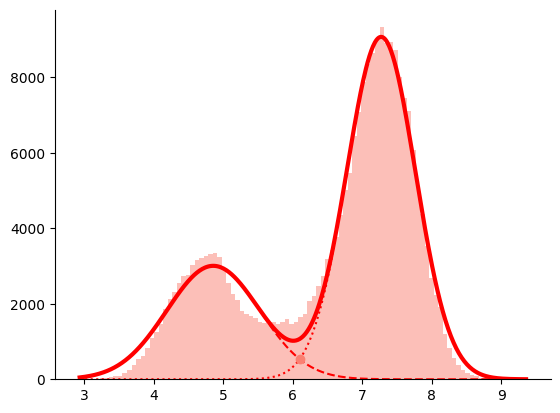

In [546]:
# obtain the treshold 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(accel_interp_filtered), bins=100, color='salmon', alpha = 0.5)

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (4, .1, max(y)/2, 7, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='salmon')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_filtered_cg = intersection.xy[0][0]
print("We consider the cutOff to be at {}".format(round(cutOff_filtered_cg, 2)))

In [824]:
plt.plot(np.log(accel_interp_filtered))

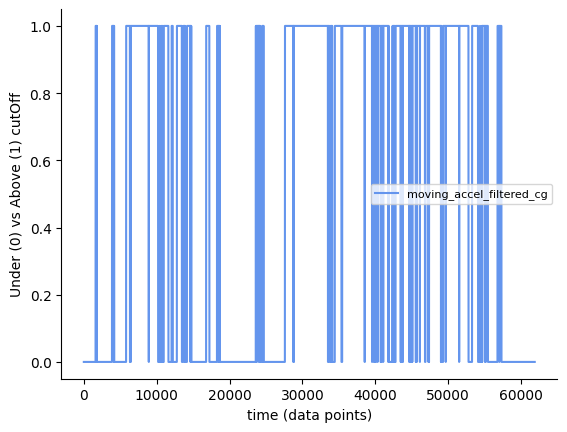

In [761]:
# obtain periods of movement (cg - cross gaussian)
moving_accel_filtered_cg = [1 if np.log(accel_interp_filtered[timestamp])
                            >= cutOff_filtered_cg else 0 for timestamp in range(len(accel_interp_filtered))]

# showing only a chunk of the signal
plt.plot(moving_accel_filtered_cg[int(len(moving_accel_filtered_cg)/4):2*int(len(moving_accel_filtered_cg)/4)],
         color='cornflowerblue', label='moving_accel_filtered_cg')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (data points)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

##### Comparing the two (original vs filtered total body acceleration) ...

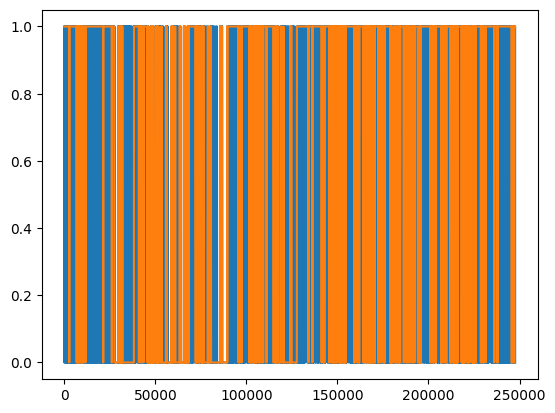

In [518]:
# Local minimum between the two modes of a bimodal distribution...
plt.plot(moving_accel)
plt.plot(moving_accel_filtered)

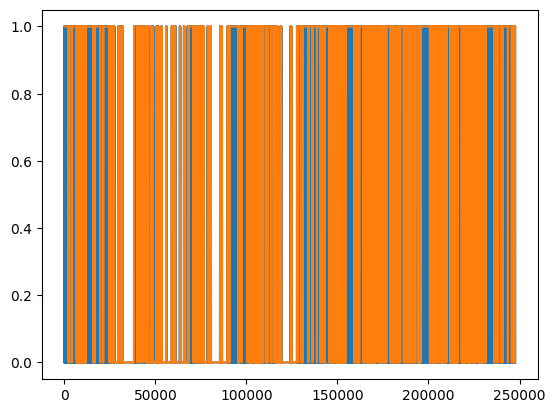

In [737]:
# crossing point between the two gaussians (cg - cross gaussian)
plt.plot(moving_accel_cg)
plt.plot(moving_accel_filtered_cg)

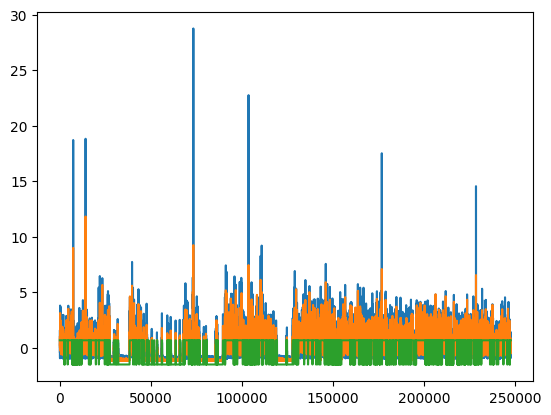

In [550]:
%matplotlib inline

import scipy.stats as st

plt.plot(st.zscore(df_timestamps_accel_interpolation['Total_accel']))
plt.plot(st.zscore(accel_interp_filtered))
plt.plot(st.zscore(moving_accel_filtered_cg))

##### Trying to work out the criteria for defining initiations from the acceleration data based on the 0/1s defined from the crossing point of two gaussians...
**First Approach:** 300 ms of log(acceleration) under the selected treshold, followed by 500 ms of log(acceleration) above the treshold.

In [528]:
len(moving_accel_cg)-len(moving_accel_filtered_cg) #with a 20 window moving average filter (low pass)

19

In [564]:
# create an arrary with the sequence of interest (this sequence is used to define instants of movement initiation)

# define the duration of non-movement (under cutOff) that must preceed an initiation
sec_stopped = 0.3 #300 ms
# convert it to the correspondant number of time points
num_points_stopped = fs * sec_stopped

# define the duration of movement (above cutOff) that must follow the non-moving period
sec_moving = 0.5 #500 ms
# convert it to the correspondant number of time points
num_points_moving = fs * sec_moving

# create the complete sequence
sequence_0_1 = (num_points_stopped, num_points_moving)
sequence = np.concatenate([np.zeros(int(sequence_0_1[0])),np.ones(int(sequence_0_1[1]))])

# iterate through the moving_accel_filtered_cg array (in which we previously defined each data point as movement (1) VS non-movement (0)) to find the regions matching our sequence of interest
movement_initiations_accel = []
index_first_element_last_seq = len(moving_accel_filtered_cg) - len(sequence)
for timestamp in range(index_first_element_last_seq + 1): # because range excludes the last value
    # check if the current sequence matches the sequence of interst
    if sum(moving_accel_filtered_cg[timestamp:timestamp+len(sequence)] == sequence) == len(sequence):
        movement_initiations_accel.append(timestamp+(sequence_0_1[0]-1)) #  adding (sequence_0_1[0]-1) considers the last zero as the initiation; +sequence_0_1[0] considers the first 1 as the init
print('The number of initiations detected using the accelerometer is: {}'.format(len(movement_initiations_accel)))

# correct the shift associated to the filtering process
initiations_accel_corrected = np.array(movement_initiations_accel) + (filtering_window - 1)

if len(initiations_accel_corrected) == len(movement_initiations_accel):
    print('\nThe initiations were corrected according to the window of the filter used :)')

# plot only the periods of movement that fulfill the criteria/sequence

The number of initiations detected using the accelerometer is: 78

The initiations were corrected according to the window of the filter used :)


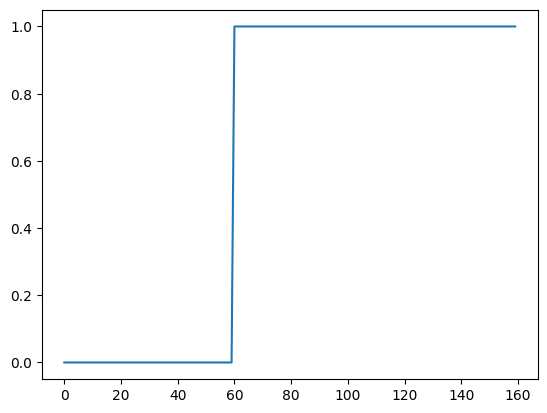

In [551]:
# print the sequence of interest
plt.plot(sequence)

### 2.1.1.1 Plot movement initiations detected using the total body acceleration

In [790]:
%matplotlib inline

import math

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

# matrix contaning the initiations (each row is a repeated value of the index in the signal where the initiation takes place)
matrix_initiations_total_accel = np.tile(
    np.vstack(initiations_accel_corrected), (1, len(range(wind1, wind2))))
# matrix containing the necessary operations in order to obtain the desired sequences 
matrix_operation_total_accel = np.tile(
    range(wind1, wind2), (len(initiations_accel_corrected), 1))
# final matrix, containing all the indices nesessary to build the total body acceleration peth
matrix_sequences_total_accel = matrix_initiations_total_accel.astype(int) + matrix_operation_total_accel.astype(int)

len_matrix_sequences_total_accel = len(matrix_initiations_total_accel)
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last 5 initiations
for i in range(5):
    if matrix_sequences_total_accel[0][0] < 0:
        matrix_sequences_total_accel = np.delete(
            matrix_sequences_total_accel, 0, 0)
    elif matrix_sequences_total_accel[-1][-1] >= len(df_timestamps_accel_interpolation):
        matrix_sequences_total_accel = np.delete(
            matrix_sequences_total_accel, -1, 0)

print("A total of {} initiations were discarded, since we don't have the complete sequence".format(len_matrix_sequences_total_accel - len(matrix_sequences_total_accel)))

total_accel_peth = np.array(df_timestamps_accel_interpolation['Total_accel'])[matrix_sequences_total_accel]
mean_total_accel = np.mean(total_accel_peth, axis = 0)
std_total_accel = np.std(total_accel_peth, axis = 0)
std_error_total_accel = std_total_accel/math.sqrt(len(initiations_accel_corrected))

A total of 0 initiations were discarded, since we don't have the complete sequence


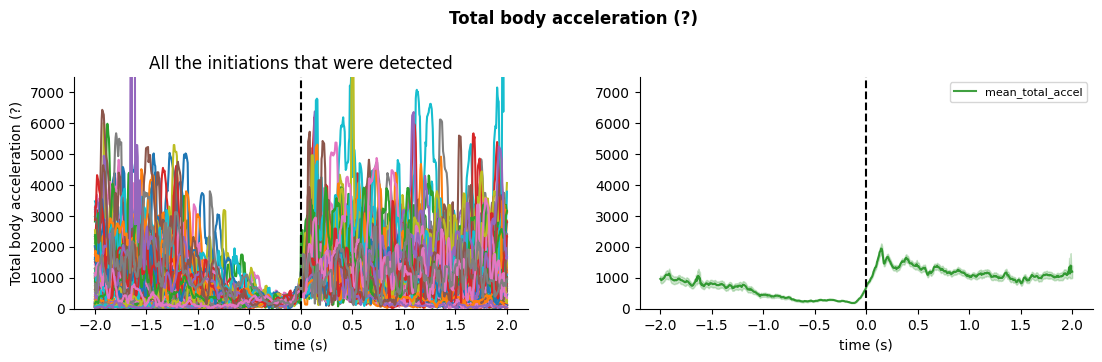

In [805]:
%matplotlib inline

# check the initiations that were detected using the total body acceleration
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)
fig.suptitle("Total body acceleration (?)", fontweight='bold')

X_POSITION = 0

# all the initiations
ax1.set_title('All the initiations that were detected')
for init in total_accel_peth:
    ax1.plot(np.linspace(-2, 2, 801), init)
ax1.axvline(X_POSITION, linestyle='--', color='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim([0, 7500])
ax1.set_ylabel(
    'Total body acceleration (?)')
ax1.set_xlabel(
    'time (s)')

# mean of the initiations 
ax2.plot(np.linspace(-2, 2, 801), mean_total_accel, color="green", alpha=0.75, label="mean_total_accel")
ax2.fill_between(np.linspace(-2, 2, 801),
                  mean_total_accel - std_error_total_accel,
                  mean_total_accel + std_error_total_accel, alpha=0.2, color='green')
ax2.axvline(X_POSITION, linestyle='--', color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim([0, 7500])
ax2.set_xlabel(
    'time (s)')
leg2 = ax2.legend(fontsize=8)

Text(0.5, 0, 'time (data points)')

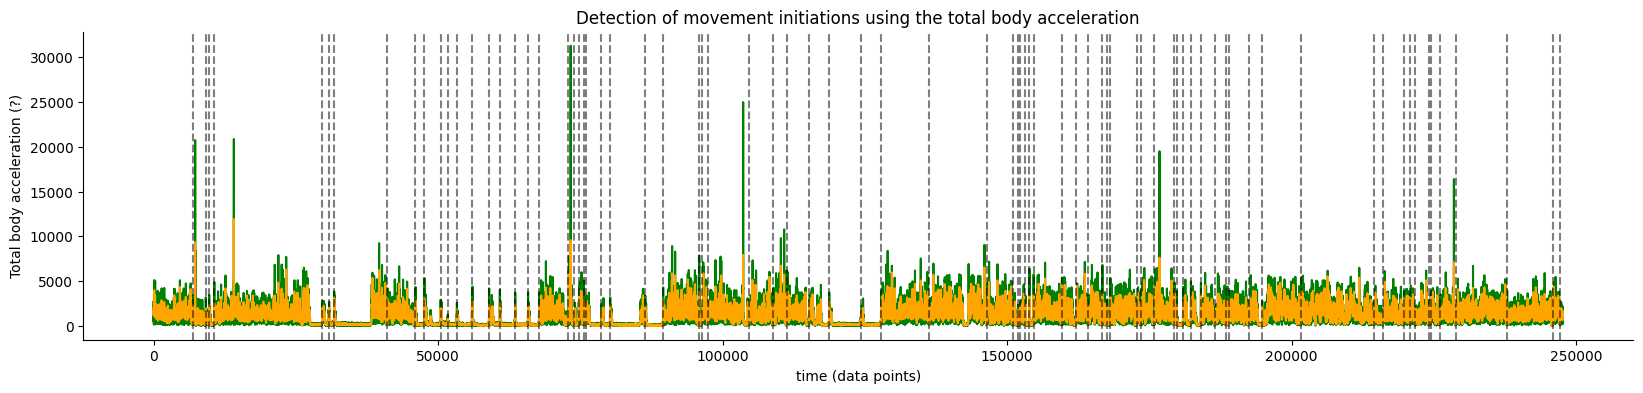

In [826]:
%matplotlib inline

fig, ((ax1)) = plt.subplots(1,1, figsize = (20,4))

ax1.set_title('Detection of movement initiations using the total body acceleration')
ax1.plot(df_timestamps_accel_interpolation['Total_accel'], color = 'green', label = 'df_timestamps_accel_interpolation["Total_accel"]')
ax1.plot(accel_interp_filtered, color = 'orange', label = 'accel_interp_filtered')
# steel need to add the cutoff and subplot smaller chunks of signal
#ax1.hlines(10**cutOff_filtered_cg, 0, len(accel_interp_filtered), color = 'black', alpha = 0.5)
for init in initiations_accel_corrected:
    ax1.axvline(init, linestyle='--', color='black', alpha = 0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Total body acceleration (?)')
ax1.set_xlabel(
    'time (data points)')

### 2.1.1.2 Plot the right hindlimb heel velocity (DLC) aligned to the initiations detected using the total body acceleration data

In [793]:
# create a function to find the timestamps of one type of data closest to the timestamps of the initiations detected using another type of data
# e.g. find the closest timestamps of right hind limb velocity to the timestamps of the initiations detected using total body acceleration as a way to align the data
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return arr[idx]   

In [794]:
# get the timestamps of the initiations - total body acceleration
ts_initiations_accel = [df_timestamps_accel_interpolation['Timestamps'][initiation] for initiation in initiations_accel_corrected]

# apply the function find_closest to velocity of the right hind paw
closest_ts_accel_init = [find_closest(df_vel['Vel - Timestamp'], ts) for ts in ts_initiations_accel]

# find the indices corresponding to the timestamps that were identified
# this array represents the indices of the velocity (right_hindlimb_heel) whose timestamps are the closest to the timestamps of the initiations calculated using data from the accelerometer
indices_closest_ts_to_accel_init = [df_vel['Vel - Timestamp'].loc[df_vel['Vel - Timestamp'] == ts].index[0] for ts in closest_ts_accel_init]

In [847]:
%matplotlib inline

import math

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -camera_aq_rate * time_sec
wind2 = camera_aq_rate * time_sec + 1

# matrix contaning the initiations (each row is a repeated value of the index in the signal where the initiation takes place)
matrix_initiations_rhl_aligned2TBA = np.tile(
    np.vstack(indices_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
# matrix containing the necessary operations in order to obtain the desired sequences
matrix_operation_rhl_aligned2TBA = np.tile(
    range(wind1, wind2), (len(indices_closest_ts_to_accel_init), 1))
# final matrix, containing all the indices nesessary to build the total body acceleration peth
matrix_sequences_rhl_aligned2TBA = matrix_initiations_rhl_aligned2TBA.astype(
    int) + matrix_operation_rhl_aligned2TBA.astype(int)


# this part can be performed only once. However, the find_closest function needs to be used imediately after that step
len_matrix_sequences_rhl_aligned2TBA = len(matrix_initiations_rhl_aligned2TBA)
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last 5 initiations
for i in range(5):
    if matrix_sequences_rhl_aligned2TBA[0][0] < 0:
        matrix_sequences_rhl_aligned2TBA = np.delete(
            matrix_sequences_rhl_aligned2TBA, 0, 0)
    elif matrix_sequences_rhl_aligned2TBA[-1][-1] >= len(df_vel):
        matrix_sequences_rhl_aligned2TBA = np.delete(
            matrix_sequences_rhl_aligned2TBA, -1, 0)

print("A total of {} initiations were discarded, since we don't have the complete sequence".format(
    len_matrix_sequences_rhl_aligned2TBA - len(matrix_sequences_rhl_aligned2TBA)))

rhl_aligned2TBA_peth = np.array(df_vel['V_xy_right_hindlimb_heel'])[
    matrix_sequences_rhl_aligned2TBA]
mean_rhl_aligned2TBA = np.mean(rhl_aligned2TBA_peth, axis=0)
std_rhl_aligned2TBA = np.std(rhl_aligned2TBA_peth, axis=0)
std_error_rhl_aligned2TBA = std_rhl_aligned2TBA / math.sqrt(len(initiations_accel_corrected))

A total of 0 initiations were discarded, since we don't have the complete sequence


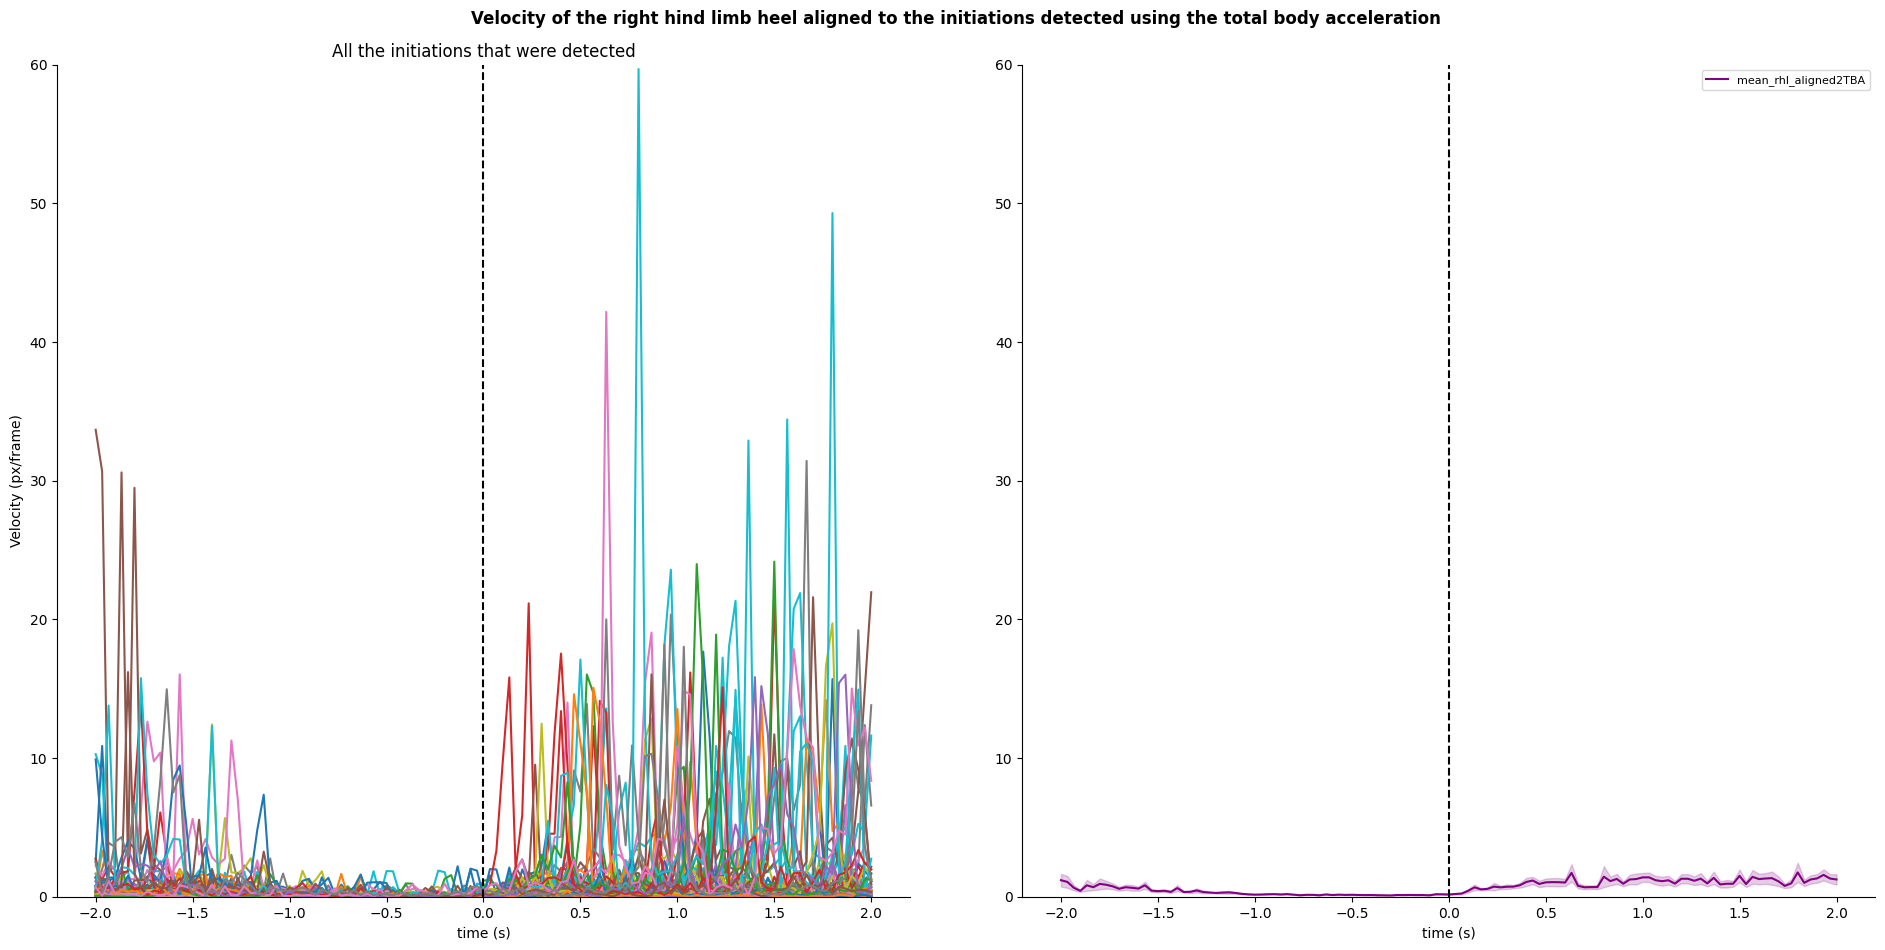

In [856]:
%matplotlib inline

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

# check the initiations that were detected using the total body acceleration
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout(pad=5.0)
fig.suptitle("Velocity of the right hind limb heel aligned to the initiations detected using the total body acceleration", fontweight='bold')

X_POSITION = 0

# all the initiations
ax1.set_title('All the initiations that were detected')
for init in rhl_aligned2TBA_peth:
    ax1.plot(np.linspace(-2, 2, np.abs(wind1)+wind2), init)
ax1.axvline(X_POSITION, linestyle='--', color='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim([0, 60])
ax1.set_ylabel(
    'Velocity (px/frame)')
ax1.set_xlabel(
    'time (s)')

# mean of the initiations
ax2.plot(np.linspace(-2, 2, np.abs(wind1)+wind2), mean_rhl_aligned2TBA,
         color="purple", label="mean_rhl_aligned2TBA")
ax2.fill_between(np.linspace(-2, 2, np.abs(wind1)+wind2),
                 mean_rhl_aligned2TBA - std_error_rhl_aligned2TBA,
                 mean_rhl_aligned2TBA + std_error_rhl_aligned2TBA, alpha=0.2, color='purple')
ax2.axvline(X_POSITION, linestyle='--', color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim([0, 60])
ax2.set_xlabel(
    'time (s)')
leg2 = ax2.legend(fontsize=8)

## 2.1.2 Detecting initiations using the velocity of the right hind paw heel (DLC predictions)

Define a criteria with the likelihood of the DLC predictions (for example, only consider initiations in which all the elements of the sequence of interest (300 ms stopped and 500 ms moving) have a likelihood of at least 0.99) - round the likelihoods to 2 decimal cases

**On the current version, no criteria was implemented regarding likelihood of DLC predictions**

In [703]:
# select the window of the moving average filter
filtering_window_rhp = 10
rhp_vel_filtered = moving_average(df_vel['V_xy_right_hindlimb_heel'], filtering_window_rhp)

The filtered signal has 9 points less compared to the original (interpolated) signal!


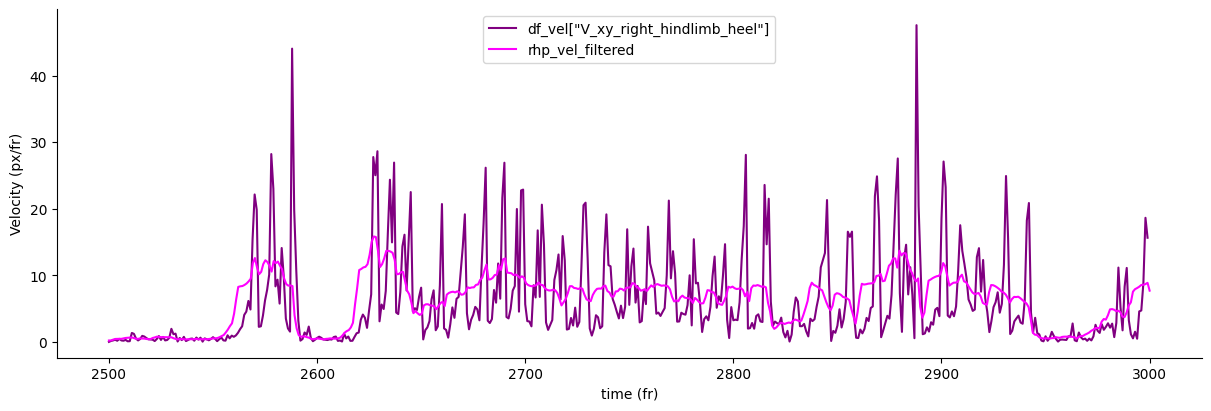

In [758]:
%matplotlib inline

# ilustrate the effect of the filter and how it adapts to a specific action/gait (in this case, we pretend to detect instants in which the mice starts walking) 
fig, (ax1) = plt.subplots(1, 1, constrained_layout=False, figsize=(12, 4))

# unprocessed data
ax1.plot(df_vel['V_xy_right_hindlimb_heel'][2500:3000],
         color="purple", label='df_vel["V_xy_right_hindlimb_heel"]')
# filtered data
ax1.plot(np.linspace(2500, 3000, 500),
         rhp_vel_filtered[2500:3000], color="fuchsia", label="rhp_vel_filtered")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Velocity (px/fr)')
ax1.set_xlabel('time (fr)')
leg = ax1.legend(fontsize=10)

diff_raw_filtered_rhp = len(
    df_vel) - len(rhp_vel_filtered)
print('The filtered signal has {} points less compared to the original (interpolated) signal!'.format(
    diff_raw_filtered_rhp))

### Initiations - right hind paw heel velocity (original & filtered)

###### Local minimum between the two modes of a bimodal distribution (ideally) ...

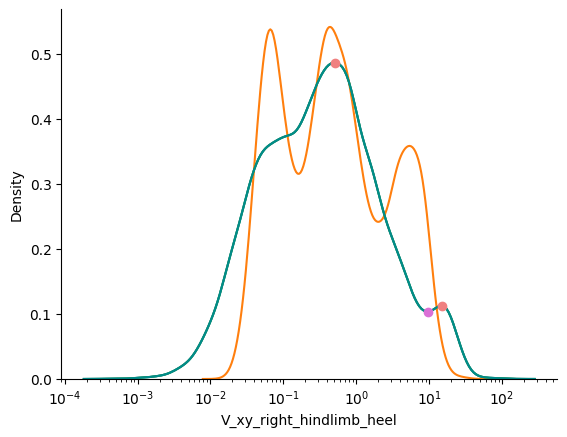

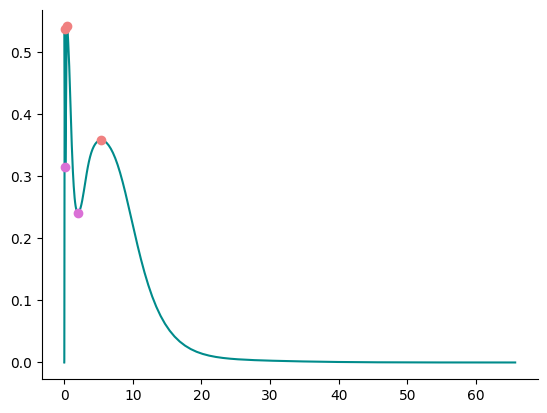

We consider the cutOff to be at 1.99 px/fr


In [727]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#consider a movement initiation every time the velocity raises above 
#...the beginning of a local minimum in the logarithmic distribution of velocities.
#...The local minimum is to be found in the valley forming between the two peaks of
#...the log scale distribution

# velocity DLC (from the original predicitons of x,y)
ax1_rhp= sns.kdeplot(df_vel['V_xy_right_hindlimb_heel']+0.000001, log_scale = True)
# filtered velocity 
ax2_rhp = sns.kdeplot(rhp_vel_filtered, log_scale=True)

kde_curve1_rhp = ax1_rhp.lines[0]
kde_curve2_rhp = ax2_rhp.lines[1]

x1_rhp = kde_curve1_rhp.get_xdata()
y1_rhp = kde_curve1_rhp.get_ydata()

x2_rhp = kde_curve2_rhp.get_xdata()
y2_rhp = kde_curve2_rhp.get_ydata()

plt.plot(x1_rhp, y1_rhp)
peaks1_rhp = np.where((y1_rhp[1:-1] > y1_rhp[0:-2]) * (y1_rhp[1:-1] > y1_rhp[2:]))[0] + 1
dips1_rhp = np.where((y1_rhp[1:-1] < y1_rhp[0:-2]) * (y1_rhp[1:-1] < y1_rhp[2:]))[0] + 1

plt.plot(x1_rhp, y1_rhp, color='darkcyan')
plt.plot(x1_rhp[peaks1_rhp], y1_rhp[peaks1_rhp], 'o', color = 'lightcoral')
plt.plot(x1_rhp[dips1_rhp], y1_rhp[dips1_rhp], 'o', color = 'orchid')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

peaks2_rhp = np.where((y2_rhp[1:-1] > y2_rhp[0:-2]) * (y2_rhp[1:-1] > y2_rhp[2:]))[0] + 1
dips2_rhp = np.where((y2_rhp[1:-1] < y2_rhp[0:-2]) * (y2_rhp[1:-1] < y2_rhp[2:]))[0] + 1

plt.plot(x2_rhp, y2_rhp, color = 'darkcyan')
plt.plot(x2_rhp[peaks2_rhp], y2_rhp[peaks2_rhp], 'o', color = 'lightcoral')
plt.plot(x2_rhp[dips2_rhp], y2_rhp[dips2_rhp], 'o', color = 'orchid')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

for i in range(len(peaks2_rhp)):
    # this is tricky, since some distributions may be multimodal
    cutOff2_rhp = x2_rhp[dips2_rhp[-1]]
    break

print("We consider the cutOff to be at {} px/fr".format(round(cutOff2_rhp, 2)))

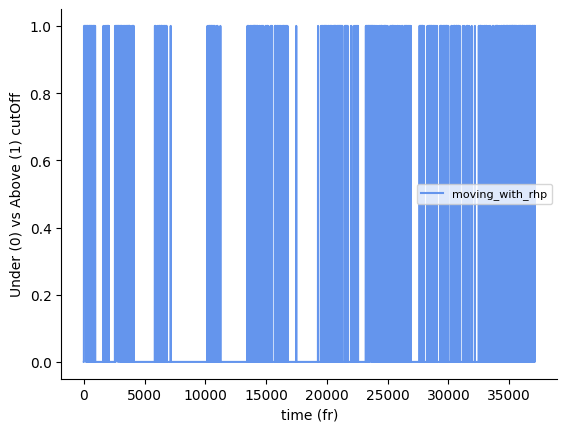

In [757]:
%matplotlib inline

import scipy.stats as st

# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
# movement detected using the velocity of the right hidn paw heel filtered using a moving average with a window of 10 frames
moving_with_rhp = [1 if rhp_vel_filtered[inst_vel] >
                   cutOff2_rhp else 0 for inst_vel in range(len(rhp_vel_filtered))]

# showing only a chunk of the signal
plt.plot(moving_with_rhp,
         color='cornflowerblue', label='moving_with_rhp')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (fr)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

###### Crossing point between two gaussians fitted to the kernel density estimation (not correct)... 

We consider the cutOff to be at 2.76 (px/fr)


C:\Users\user\AppData\Local\Temp\ipykernel_29260\2207045290.py:41: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  plt.plot(*LineString(intersection).xy, 'o', color = 'salmon')
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\geometry\linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)
C:\Users\user\AppData\Local\Temp\ipykernel_29260\2207045290.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  cutOff_rhp_filtered_cg = LineString(intersection).xy[0][0]


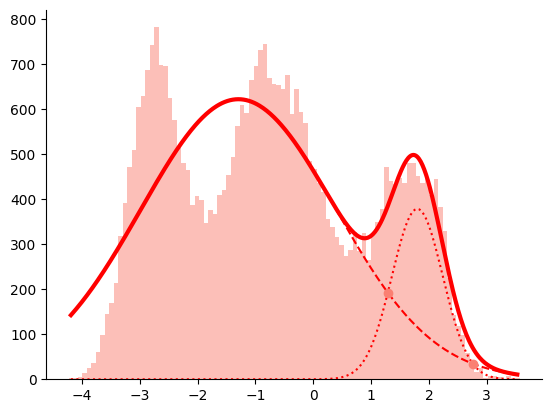

In [890]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(rhp_vel_filtered), bins=100, color='salmon', alpha = 0.5)

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2) 

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

def multimodal_3(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)+gauss(x, mu3, sigma3, A3)
    
# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (-1, .1, max(y)/2, 2, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o', color = 'salmon')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='salmon')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_rhp_filtered_cg = LineString(intersection).xy[0][0]

#not the real cutoff since I used the log of the data
print("We consider the cutOff to be at {} (px/fr)".format(round(cutOff_rhp_filtered_cg, 2)))

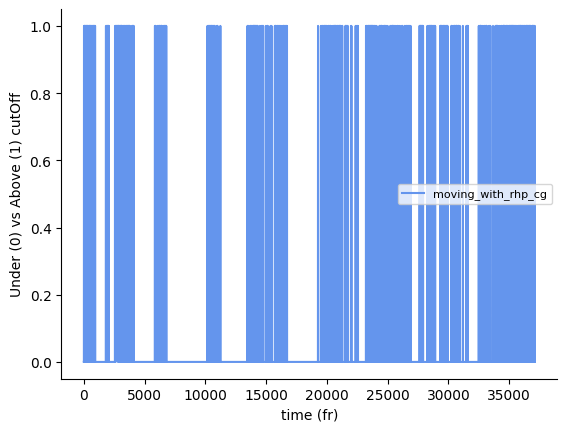

In [756]:
%matplotlib inline

import scipy.stats as st

# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
# movement detected using the velocity of the right hind paw heel filtered using a moving average with a window of 10 frames
moving_with_rhp_cg = [1 if rhp_vel_filtered[inst_vel] >
                   cutOff_rhp_filtered_cg else 0 for inst_vel in range(len(rhp_vel_filtered))]

# showing only a chunk of the signal
plt.plot(moving_with_rhp_cg,
         color='cornflowerblue', label='moving_with_rhp_cg')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (fr)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

**First approach**:The sequence of interest was first created as 300 ms of velocity under the selected treshold, followed by 500 ms of velocity above the treshold. Another approach could be 300 ms of velocity under the selected treshold, followed by 15 frames (500 ms) from which at least 12 have to be above the velocity treshold (to reduce the number of false negatives - less specific)

**300ms 0, followed by 500ms 1**

In [783]:
# create an arrary with the sequence of interest (this sequence is used to define instants of movement initiation)

# define the duration of non-movement (under cutOff) that must preceed an initiation
sec_stopped = 0.3  # 300 ms
# convert it to the correspondant number of time points
num_points_stopped = camera_aq_rate * sec_stopped

# define the duration of movement (above cutOff) that must follow the non-moving period
sec_moving = 0.5  # 500 ms
# convert it to the correspondant number of time points
num_points_moving = camera_aq_rate * sec_moving

# create the complete sequence
sequence_0_1_vel = (num_points_stopped, num_points_moving)
sequence_vel = np.concatenate(
    [np.zeros(int(sequence_0_1_vel[0])), np.ones(int(sequence_0_1_vel[1]))])

# iterate through the moving_with_rhp array (in which we previously defined each data point as movement (1) VS non-movement (0)) to find the regions matching our sequence of interest
index_first_element_last_seq = len(moving_with_rhp) - len(sequence_vel)
movement_initiations_rhp = [# adding (sequence_0_1[0]-1) considers the last zero as the initiation; +sequence_0_1[0] considers the first 1 as the init
                            timestamp + (sequence_0_1_vel[0] - 1)
                            # because range excludes the last value
                            for timestamp in range(index_first_element_last_seq + 1)
                            # check if the current sequence matches the sequence of interst
                            if sum(moving_with_rhp[timestamp: timestamp + len(sequence_vel)] == sequence_vel) == len(sequence_vel)]

print('The number of initiations detected using the velocity of the right hind paw heel is: {}'.format(
    len(movement_initiations_rhp)))

# correct the shift associated to the filtering process
initiations_rhp_corrected = np.array(
    movement_initiations_rhp) + (filtering_window_rhp - 1)

if len(initiations_rhp_corrected) == len(movement_initiations_rhp):
    print('\nThe initiations were corrected according to the window of the filter used :)')

The number of initiations detected using the velocity of the right hind paw heel is: 115

The initiations were corrected according to the window of the filter used :)


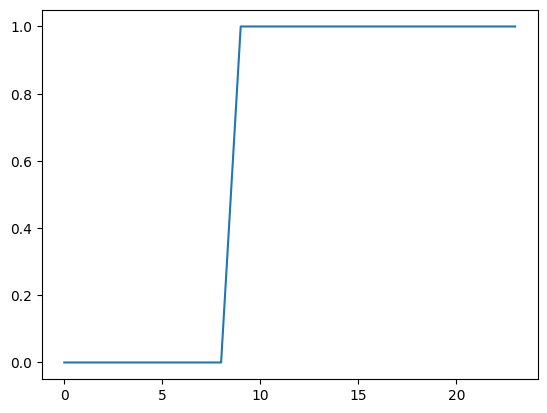

In [787]:
# print the sequence of interest
plt.plot(sequence_vel)

### Plot movement initiations detected using the velocity of the right hind paw heel

In [797]:
%matplotlib inline

import math

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

# matrix contaning the initiations (each row is a repeated value of the index in the signal where the initiation takes place)
matrix_initiations_rhp = np.tile(
    np.vstack(initiations_rhp_corrected), (1, len(range(wind1, wind2))))
# matrix containing the necessary operations in order to obtain the desired sequences
matrix_operation_rhp = np.tile(
    range(wind1, wind2), (len(initiations_rhp_corrected), 1))
# final matrix, containing all the indices nesessary to build the rhp velocity peth
matrix_sequences_rhp = matrix_initiations_rhp.astype(
    int) + matrix_operation_rhp.astype(int)

len_matrix_sequences_rhp = len(matrix_initiations_rhp)
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the length of the data, those sequences should not be counted ...
# this is a temporary solution for this problem, since I only check the first and last 5 initiations
for i in range(5):
    if matrix_sequences_rhp[0][0] < 0:
        matrix_sequences_rhp = np.delete(
            matrix_sequences_rhp, 0, 0)
    elif matrix_sequences_rhp[-1][-1] >= len(df_vel):
        matrix_sequences_rhp = np.delete(
            matrix_sequences_rhp, -1, 0)

print("A total of {} initiations were discarded, since we don't have the complete sequence".format(
    len_matrix_sequences_rhp - len(matrix_sequences_rhp)))

rhp_peth = np.array(df_vel['V_xy_right_hindlimb_heel'])[
    matrix_sequences_rhp]
mean_rhp = np.mean(rhp_peth, axis=0)
std_rhp = np.std(rhp_peth, axis=0)
std_error_rhp = std_rhp / \
    math.sqrt(len(initiations_rhp_corrected))

A total of 1 initiations were discarded, since we don't have the complete sequence


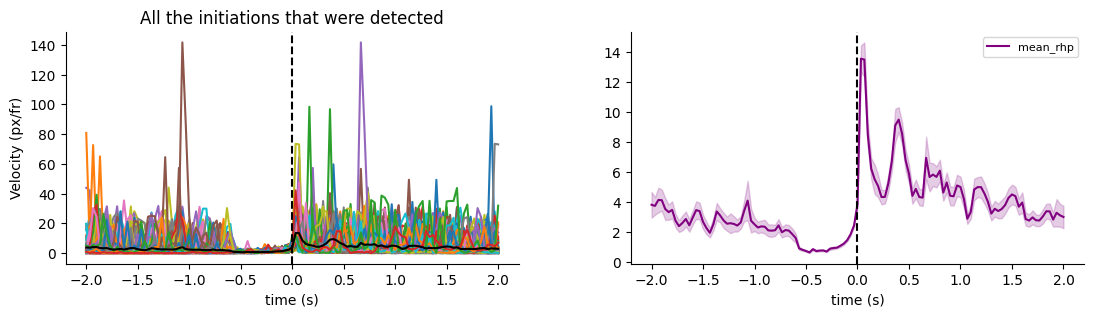

In [920]:
%matplotlib inline

# check the initiations that were detected using the velocity of the right hind paw
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

X_POSITION = 0

# all the initiations
ax1.set_title('All the initiations that were detected')
for init in rhp_peth:
    ax1.plot(np.linspace(-2, 2, np.abs(wind1) + wind2), init)
ax1.plot(np.linspace(-2, 2, np.abs(wind1) + wind2), mean_rhp,
         color="black", label="mean_rhp")
ax1.fill_between(np.linspace(-2, 2, np.abs(wind1) + wind2),
                 mean_rhp - std_error_rhp,
                 mean_rhp + std_error_rhp, alpha=0.5, color='black')
ax1.axvline(X_POSITION, linestyle='--', color='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Velocity (px/fr)')
ax1.set_xlabel(
    'time (s)')

# mean of the initiations
ax2.plot(np.linspace(-2, 2, np.abs(wind1) + wind2), mean_rhp,
         color="purple", label="mean_rhp")
ax2.fill_between(np.linspace(-2, 2, np.abs(wind1) + wind2),
                 mean_rhp - std_error_rhp,
                 mean_rhp + std_error_rhp, alpha=0.2, color='purple')
ax2.axvline(X_POSITION, linestyle='--', color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel(
    'time (s)')
leg2 = ax2.legend(fontsize=8)

Text(0.5, 0, 'time (fr)')

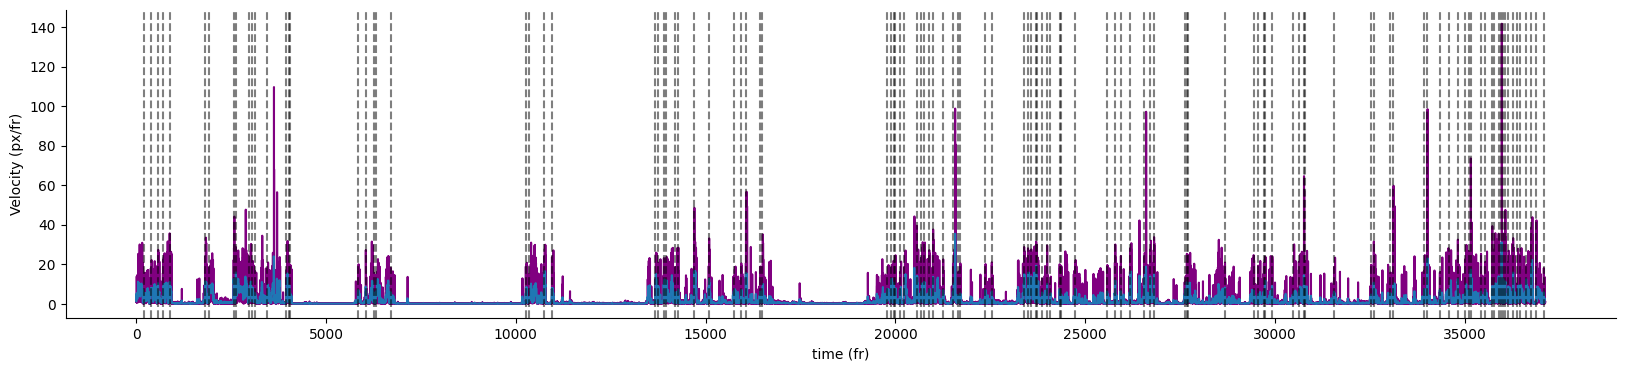

In [811]:
%matplotlib inline

fig, ((ax1)) = plt.subplots(1, 1, figsize=(20, 4))

ax1.plot(df_vel['V_xy_right_hindlimb_heel'], color='purple')
ax1.plot(rhp_vel_filtered)
for init in initiations_rhp_corrected:
    ax1.axvline(init, linestyle='--', color='black', alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Velocity (px/fr)')
ax1.set_xlabel(
    'time (fr)')

Try to make something with the following two cells...

In [ ]:
# place this plot before 2.1.3
plt.plot(df_vel['V_xy_right_hindlimb_heel'])
plt.plot(df_vel_filtered['V_xy_right_hindlimb_heel'])
plt.plot(moving_with_paw)

In [ ]:
# velocities calculated directly from the x,y DLC predictions
plt.plot(df_vel['V_xy_right_hindlimb_heel'])
# velocity filtered with a moving average (with a 10 fr window)
plt.plot(df_vel_filtered['V_xy_right_hindlimb_heel'])
# treshold for movement initiation (of the heel - DLC predictions)
plt.hlines(cutOff2_heel, 0, len(df_vel), color='green')
# here, initiations are correct 
for init in initiation_right_paw_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

### 2.1.1.2 Plot the total body acceleration aligned to the initiations detected using the right hind limb heel velocity

In [843]:
# get the timestamps of the initiations - rhp velocity
ts_initiations_rhp = [df_vel['Vel - Timestamp'][initiation] for initiation in initiations_rhp_corrected]

# apply the function find_closest to total body acceleration
closest_ts_rhp_init = [find_closest(df_timestamps_accel_interpolation['Timestamps'], ts) for ts in ts_initiations_rhp]

# find the indices corresponding to the timestamps that were identified
# this array represents the indices of the total body acceleration whose timestamps are the closest to the timestamps of the initiations calculated using the velocity of the rhp
indices_closest_ts_to_rhp_init = [df_timestamps_accel_interpolation['Timestamps'].loc[df_timestamps_accel_interpolation['Timestamps'] == ts].index[0] for ts in closest_ts_rhp_init]

In [851]:
%matplotlib inline

import math

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -fs * time_sec
wind2 = fs * time_sec + 1

# matrix contaning the initiations (each row is a repeated value of the index in the signal where the initiation takes place)
matrix_initiations_tba_aligned2RHP = np.tile(
    np.vstack(indices_closest_ts_to_rhp_init), (1, len(range(wind1, wind2))))
# matrix containing the necessary operations in order to obtain the desired sequences
matrix_operation_tba_aligned2RHP = np.tile(
    range(wind1, wind2), (len(indices_closest_ts_to_rhp_init), 1))
# final matrix, containing all the indices nesessary to build the plot
matrix_sequences_tba_aligned2RHP = matrix_initiations_tba_aligned2RHP.astype(
    int) + matrix_operation_tba_aligned2RHP.astype(int)

# this part can be performed only once. However, the find_closest function needs to be used imediately after that step
len_matrix_sequences_tba_aligned2RHP = len(matrix_initiations_tba_aligned2RHP)
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last 5 initiations
for i in range(5):
    if matrix_sequences_tba_aligned2RHP[0][0] < 0:
        matrix_sequences_tba_aligned2RHP = np.delete(
            matrix_sequences_tba_aligned2RHP, 0, 0)
    elif matrix_sequences_tba_aligned2RHP[-1][-1] >= len(df_timestamps_accel_interpolation):
        matrix_sequences_tba_aligned2RHP = np.delete(
            matrix_sequences_tba_aligned2RHP, -1, 0)

print("A total of {} initiations were discarded, since we don't have the complete sequence".format(
    len_matrix_sequences_tba_aligned2RHP - len(matrix_sequences_tba_aligned2RHP)))

tba_aligned2RHP_peth = np.array(df_timestamps_accel_interpolation['Total_accel'])[
    matrix_sequences_tba_aligned2RHP]
mean_tba_aligned2RHP = np.mean(tba_aligned2RHP_peth, axis=0)
std_tba_aligned2RHP = np.std(tba_aligned2RHP_peth, axis=0)
std_error_tba_aligned2RHP = std_tba_aligned2RHP / \
    math.sqrt(len(initiations_rhp_corrected))

A total of 1 initiations were discarded, since we don't have the complete sequence


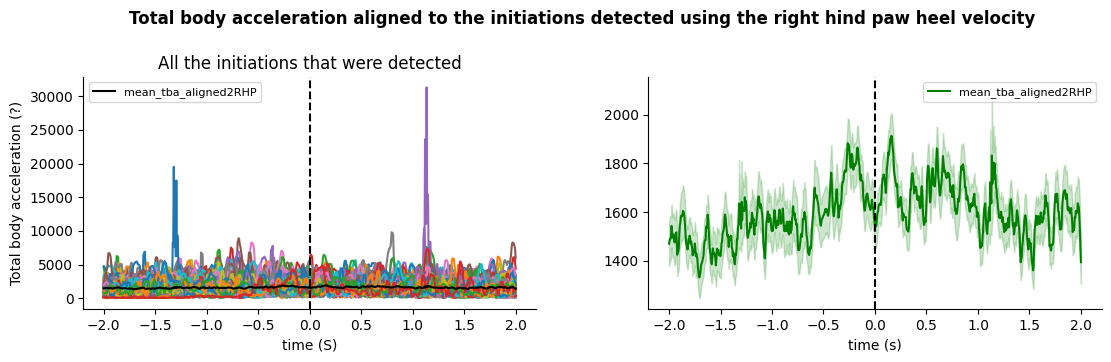

In [873]:
%matplotlib inline

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -fs * time_sec
wind2 = fs * time_sec + 1

# check the initiations that were detected using the total body acceleration
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)
fig.suptitle("Total body acceleration aligned to the initiations detected using the right hind paw heel velocity", fontweight='bold')

X_POSITION = 0

# all the initiations
ax1.set_title('All the initiations that were detected')
for init in tba_aligned2RHP_peth:
    ax1.plot(np.linspace(-2, 2, np.abs(wind1)+wind2), init)
ax1.axvline(X_POSITION, linestyle='--', color='black')
ax1.plot(np.linspace(-2, 2, np.abs(wind1)+wind2), mean_tba_aligned2RHP,
         color="black", label="mean_tba_aligned2RHP")
ax1.fill_between(np.linspace(-2, 2, np.abs(wind1)+wind2),
                 mean_tba_aligned2RHP - std_error_tba_aligned2RHP,
                 mean_tba_aligned2RHP + std_error_tba_aligned2RHP, alpha=0.5, color='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Total body acceleration (?)')
ax1.set_xlabel(
    'time (S)')
leg1 = ax1.legend(fontsize=8)

# mean of the initiations
ax2.plot(np.linspace(-2, 2, np.abs(wind1)+wind2), mean_tba_aligned2RHP,
         color="green", label="mean_tba_aligned2RHP")
ax2.fill_between(np.linspace(-2, 2, np.abs(wind1)+wind2),
                 mean_tba_aligned2RHP - std_error_tba_aligned2RHP,
                 mean_tba_aligned2RHP + std_error_tba_aligned2RHP, alpha=0.2, color='green')
ax2.axvline(X_POSITION, linestyle='--', color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel(
    'time (s)')
leg2 = ax2.legend(fontsize=8)

LEFT HERE...

## 2.2 Seeing both sets of initiations for this session (accelerometer vs DLC velocity)
...and detecting only initiations of the accelerometer which invole the lesioned paw (maybe produce analogous information for the other paw and the nose) - **not implemented yet**

**Important:** consider the timestamps and the aquisition rate of both the accel sensor and the camera and build the x axis accordingly

In [ ]:
for init in initiation_right_paw_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
for init in initiations_accel_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
ts_initiations_accel = []
for i in range(len(df_acceldata_accel['Timestamp'])):
    if i in initiations_accel_corrected:
        ts_initiations_accel.append(df_acceldata_accel['Timestamp'][i])

ts_initiations_vel = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiation_right_paw_corrected:
        ts_initiations_vel.append(df_vel['Vel - Timestamp'][i])

Some plots...

In [ ]:
print(len(ts_initiations_accel), len(ts_initiations_vel))

In [ ]:
plt.scatter(ts_initiations_accel, np.ones(len(initiations_accel_corrected)), color='orange')
plt.plot(df_acceldata_accel['Timestamp'], df_acceldata_accel['Total_accel'])

In [ ]:
plt.scatter(ts_initiations_accel, np.ones(len(initiations_accel_corrected)))
plt.scatter(ts_initiations_vel, np.ones(len(initiation_right_paw_corrected)))
plt.ylim(-10,10)

In [ ]:
plt.scatter(ts_initiations_accel, np.ones(len(initiations_accel_corrected)))
plt.scatter(ts_initiations_vel, np.zeros(len(initiation_right_paw_corrected)))
plt.ylim(-10,10)

In [ ]:
plt.plot(df_vel['Vel - Timestamp'], df_vel['V_xy_right_hindlimb_heel'])
plt.scatter(ts_initiations_vel, np.zeros(len(initiation_right_paw_corrected)), color='orange')

### Both sets of initiations in the same plot

In [ ]:
# total body accceleration (not filtered)
plt.plot(df_acceldata_accel['Timestamp'], st.zscore(df_acceldata_accel['Total_accel']))
# velocity (not filtered)
plt.plot(df_vel['Vel - Timestamp'], st.zscore(df_vel['V_xy_right_hindlimb_heel'])-3)

# initiations of the accelerometer with phase correction
plt.scatter(ts_initiations_accel, np.zeros(len(initiations_accel_corrected)), color = 'green')
# initiations of the DLC (velocity)
plt.scatter(ts_initiations_vel, -3*np.ones(len(initiation_right_paw_corrected)), color = 'k')

# 2.1.3 Detecting initiations using the velocity of the nose (DLC predictions)

In [874]:
# select the window of the moving average filter
filtering_window_nose = 3
nose_vel_filtered = moving_average(
    df_vel['V_xy_nose'], filtering_window_nose)

The filtered signal has 2 points less compared to the original (interpolated) signal!


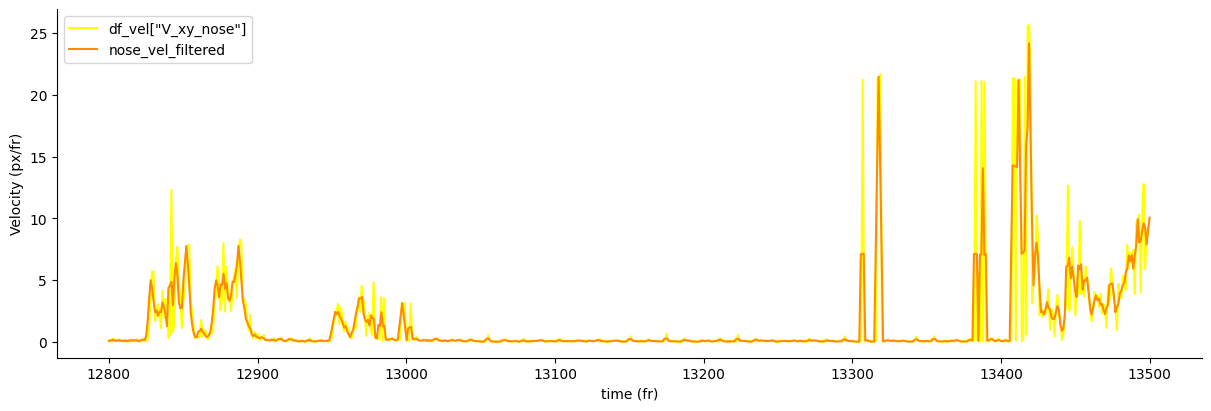

In [921]:
%matplotlib inline

# ilustrate the effect of the filter
fig, (ax1) = plt.subplots(1, 1, constrained_layout=False, figsize=(12, 4))

# unprocessed data
ax1.plot(df_vel['V_xy_nose'][12800:13500],
         color="yellow", label='df_vel["V_xy_nose"]')
# filtered data
ax1.plot(np.linspace(12800, 13500, 700),
         nose_vel_filtered[12800:13500], color="darkorange", label="nose_vel_filtered")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Velocity (px/fr)')
ax1.set_xlabel('time (fr)')
leg = ax1.legend(fontsize=10)

diff_raw_filtered_nose = len(
    df_vel) - len(nose_vel_filtered)
print('The filtered signal has {} points less compared to the original (interpolated) signal!'.format(
    diff_raw_filtered_nose))

### Initiations - nose velocity (filtered)

###### Crossing point between two gaussians fitted to the signal ...

We consider the cutOff to be at -0.05 px/fr


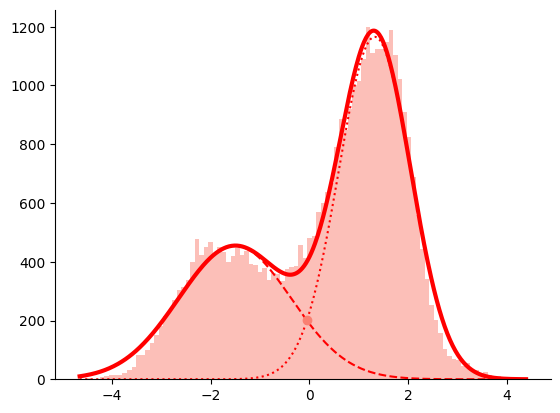

In [891]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y, x, _ = plt.hist(np.log(nose_vel_filtered), bins=100, color='salmon', alpha = 0.5)

x = (x[1:]+x[:-1])/2

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

# working on it
def multimodal_3(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)+gauss(x, mu3, sigma3, A3)

# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (-1, .1, max(y)/2, 2, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected,
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]])
sigma = np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o', color = 'salmon')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color = 'salmon')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_nose_filtered_cg = intersection.xy[0][0]
cutOff_nose_filtered_cg

print("We consider the cutOff to be at {} px/fr".format(round(cutOff_nose_filtered_cg, 2)))

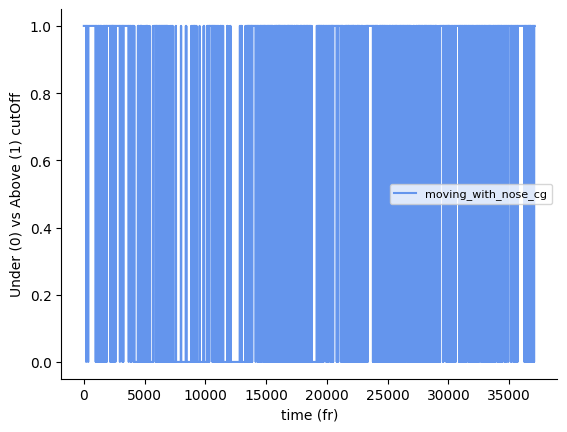

In [896]:
%matplotlib inline

import scipy.stats as st

# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
# movement detected using the velocity of the nose filtered using a moving average with a window of 3 frames
moving_with_nose_cg = [1 if np.log(nose_vel_filtered[inst_vel]) >
                   cutOff_nose_filtered_cg else 0 for inst_vel in range(len(nose_vel_filtered))]

# showing only a chunk of the signal
plt.plot(moving_with_nose,
         color='cornflowerblue', label='moving_with_nose_cg')
plt.ylabel(
    'Under (0) vs Above (1) cutOff')
plt.xlabel(
    'time (fr)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
leg = plt.legend(fontsize=8)

**First approach**: The sequence of interest was first created as 300 ms of velocity under the selected treshold, followed by 500 ms of velocity above the treshold. Another approach could be 300 ms of velocity under the selected treshold, followed by 15 frames(500 ms) from which at least 12 have to be above the velocity treshold(to reduce the number of false negatives - less specific)

**300ms 0, followed by 500ms 1**

In [899]:
# create an arrary with the sequence of interest (this sequence is used to define instants of movement initiation)

# define the duration of non-movement (under cutOff) that must preceed an initiation
sec_stopped = 0.3  # 300 ms
# convert it to the correspondant number of time points
num_points_stopped = camera_aq_rate * sec_stopped

# define the duration of movement (above cutOff) that must follow the non-moving period
sec_moving = 0.5  # 500 ms
# convert it to the correspondant number of time points
num_points_moving = camera_aq_rate * sec_moving

# iterate through the moving_with_nose array (in which we previously defined each data point as movement (1) VS non-movement (0)) to find the regions matching our sequence of interest
index_first_element_last_seq = len(moving_with_nose_cg) - len(sequence_vel)
movement_initiations_nose = [# adding (sequence_0_1_vel[0]-1) considers the last zero as the initiation; +sequence_0_1_vel[0] considers the first 1 as the init
    timestamp + (sequence_0_1_vel[0] - 1)
    # because range excludes the last value
    for timestamp in range(index_first_element_last_seq + 1)
    # check if the current sequence matches the sequence of interst
    if sum(moving_with_nose_cg[timestamp: timestamp + len(sequence_vel)] == sequence_vel) == len(sequence_vel)]

print('The number of initiations detected using the velocity of the nose is: {}'.format(
    len(movement_initiations_nose)))

# correct the shift associated to the filtering process
initiations_nose_corrected = np.array(
    movement_initiations_nose) + (filtering_window_nose - 1)

if len(initiations_nose_corrected) == len(movement_initiations_nose):
    print('\nThe initiations were corrected according to the window of the filter used :)')

The number of initiations detected using the velocity of the nose is: 96

The initiations were corrected according to the window of the filter used :)


### Plot movement initiations detected using the velocity of the right hind paw heel

In [917]:
%matplotlib inline

import math

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

# matrix contaning the initiations (each row is a repeated value of the index in the signal where the initiation takes place)
matrix_initiations_nose = np.tile(
    np.vstack(initiations_nose_corrected), (1, len(range(wind1, wind2))))
# matrix containing the necessary operations in order to obtain the desired sequences
matrix_operation_nose = np.tile(
    range(wind1, wind2), (len(initiations_nose_corrected), 1))
# final matrix, containing all the indices nesessary to build the rhp velocity peth
matrix_sequences_nose = matrix_initiations_nose.astype(
    int) + matrix_operation_nose.astype(int)

len_matrix_sequences_nose = len(matrix_initiations_nose)
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the length of the data, those sequences should not be counted ...
# this is a temporary solution for this problem, since I only check the first and last 5 initiations
for i in range(5):
    if matrix_sequences_nose[0][0] < 0:
        matrix_sequences_nose = np.delete(
            matrix_sequences_nose, 0, 0)
    elif matrix_sequences_nose[-1][-1] >= len(df_vel):
        matrix_sequences_nose = np.delete(
            matrix_sequences_nose, -1, 0)

print("A total of {} initiations were discarded, since we don't have the complete sequence".format(
    len_matrix_sequences_nose - len(matrix_sequences_nose)))

nose_peth = np.array(df_vel['V_xy_nose'])[
    matrix_sequences_nose]
mean_nose = np.mean(nose_peth, axis=0)
std_nose = np.std(nose_peth, axis=0)
std_error_nose = std_nose / \
    math.sqrt(len(initiations_nose_corrected))

A total of 0 initiations were discarded, since we don't have the complete sequence


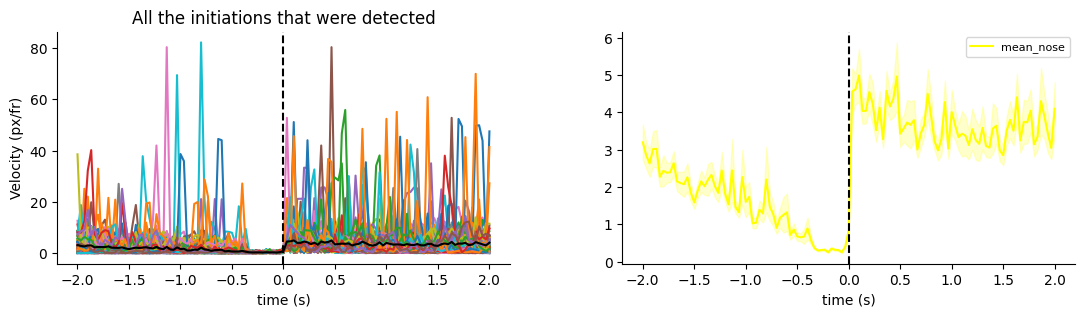

In [923]:
%matplotlib inline 

# check the initiations that were detected using the velocity of the nose
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

# define the window of interest (in this case, 2 seconds before and after the detected initiation)
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

X_POSITION = 0

# all the initiations
ax1.set_title('All the initiations that were detected')
for init in nose_peth:
    ax1.plot(np.linspace(-2, 2, np.abs(wind1) + wind2), init)
ax1.axvline(X_POSITION, linestyle='--', color='black')
ax1.plot(np.linspace(-2, 2, np.abs(wind1) + wind2), mean_nose,
         color="black", label="mean_nose")
ax1.fill_between(np.linspace(-2, 2, np.abs(wind1) + wind2),
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha=0.5, color='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Velocity (px/fr)')
ax1.set_xlabel(
    'time (s)')

# mean of the initiations
ax2.plot(np.linspace(-2, 2, np.abs(wind1) + wind2), mean_nose,
         color="yellow", label="mean_nose")
ax2.fill_between(np.linspace(-2, 2, np.abs(wind1) + wind2),
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha=0.2, color='yellow')
ax2.axvline(X_POSITION, linestyle='--', color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel(
    'time (s)')
leg2 = ax2.legend(fontsize=8)

Text(0.5, 0, 'time (fr)')

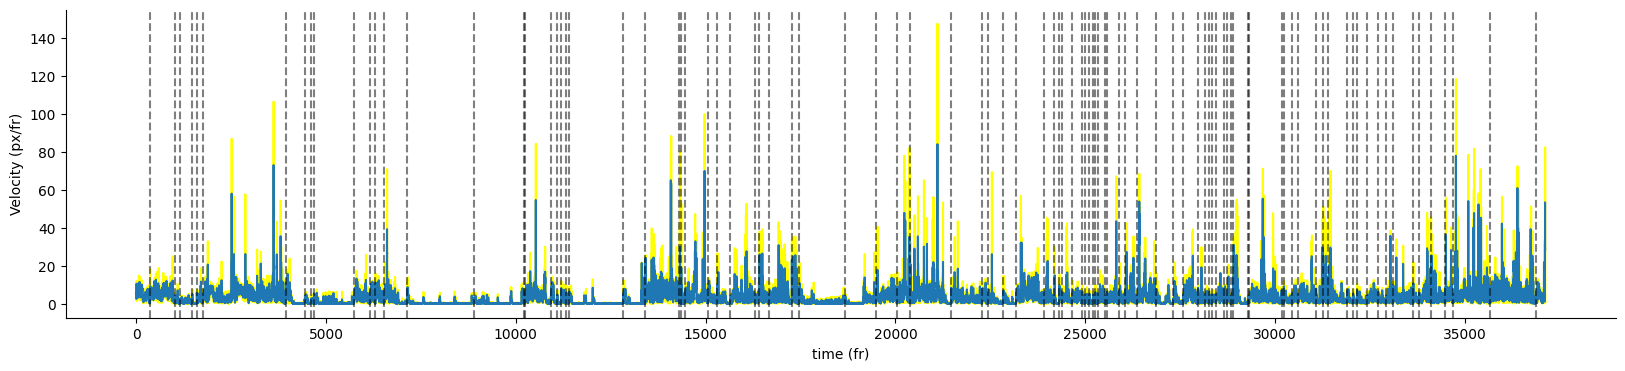

In [924]:
%matplotlib inline

fig, ((ax1)) = plt.subplots(1, 1, figsize=(20, 4))

ax1.plot(df_vel['V_xy_nose'], color='yellow')
ax1.plot(nose_vel_filtered)
for init in initiations_nose_corrected:
    ax1.axvline(init, linestyle='--', color='black', alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(
    'Velocity (px/fr)')
ax1.set_xlabel(
    'time (fr)')

# 2.1.4 Detecting initiations using the velocity of the left hind paw heel (DLC predictions)

---

##### Replicate the calculation of movement initiations from DLC predictions for the 'nose' and 'left hind limb'

#### Using moving_nose_cg (3 window filter)

##### 300ms 0, followed by 500ms 1

In [ ]:
sequence_of_interest = []
for i in range(9):
    sequence_of_interest.append(0)
for i in range(15):
    sequence_of_interest.append(1)
sequence_of_interest # len(sequence_of_interest) == 24 

In [ ]:
# all sequences following the criteria
initiations_nose = []
index_first_element_last_seq = len(moving_nose_cg)-24
for frame in range(index_first_element_last_seq + 1): # because range excludes the last value
    if moving_nose_cg[frame:frame+24] == sequence_of_interest:
        initiations_nose.append(frame+8) #+8 considers the last zero as the initiation; +9 considers the first 1 as the init
initiations_nose

In [ ]:
plt.plot(moving_nose_cg, color = 'g')
for init in initiations_nose:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
initiations_nose_corrected = []
for init in initiations_nose:
    initiations_nose_corrected.append(init+window_nose-1)
initiations_nose_corrected

In [ ]:
# velocities calculated directly from the x,y DLC predictions
plt.plot(df_vel['V_xy_nose'])
# velocity filtered with a moving average (with a 3 fr window)
plt.plot(velocity_filtered_nose)
# treshold for movement initiation (of the nose - DLC predictions)
plt.hlines(cutOff_nose_filtered_cg, 0, len(df_vel), color='green')
# here, initiations are correct 
for init in initiations_nose_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
# plot containing the average of the nose movement initiations detected
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_nose = np.tile(np.vstack(initiations_nose_corrected), (1, len(range(wind1, wind2))))
matrix_operation_nose = np.tile(range(wind1, wind2), (len(initiations_nose_corrected),1))
matrix_sequences_nose = matrix_initiations_nose + matrix_operation_nose

nose_peth = np.array(df_vel['V_xy_nose'])[matrix_sequences_nose]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(nose_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_nose = sum(nose_peth)/len(initiations_nose)
std_nose = nose_peth.std(axis=0) 
std_error_nose = std_nose/math.sqrt(len(initiations_nose))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Total body acceleration aligned to the initiations detected using the velocities calculated from the DLC predicted coordinates (nose)

In [ ]:
ts_initiations_vel_nose = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiations_nose_corrected:
        ts_initiations_vel_nose.append(df_vel['Vel - Timestamp'][i])

In [ ]:
closest_ts_2nose_vel_init = []
for ts in ts_initiations_vel_nose:
    closest_ts = find_closest(df_timestamps_accel_interpolation['Timestamps'], ts)
    closest_ts_2nose_vel_init.append(closest_ts)
    
indices_closest_ts_2nose_vel_init = []
for ts in closest_ts_2nose_vel_init:
    indices_closest_ts_2nose_vel_init.append(df_timestamps_accel_interpolation['Timestamps'].loc[df_timestamps_accel_interpolation['Timestamps']==ts])
    
for i, j in zip(indices_closest_ts_2nose_vel_init, range(len(indices_closest_ts_2nose_vel_init))):
    indices_closest_ts_2nose_vel_init[j] = i.index[0] 

indices_closest_ts_2nose_vel_init

In [ ]:
# plot containing the average of the TBA's aligned to the initiations 
# detected using the velocity of the nose

time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

matrix_accel_aligned_2nose = np.tile(np.vstack(indices_closest_ts_2nose_vel_init), (1, len(range(wind1, wind2))))
matrix_operation_nose = np.tile(range(wind1, wind2), (len(indices_closest_ts_2nose_vel_init),1))
matrix_sequences_nose = matrix_accel_aligned_2nose + matrix_operation_nose

TBA_aligned_2nose_peth = np.array(total_accel_interpolation)[matrix_sequences_nose]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(TBA_aligned_2nose_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init))
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Nose velocity aligned to the initiations detected using the total body acceleration data

In [ ]:
# plot containing the average of the velocity of the nose aligned to the initiations 
# detected using the total body acceleration

time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_nose_aligned_2accel = np.tile(np.vstack(indices_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
matrix_operation_nose_aligned_2accel = np.tile(range(wind1, wind2), (len(indices_closest_ts_to_accel_init),1))
matrix_sequences_nose_aligned_2accel = matrix_nose_aligned_2accel + matrix_operation_nose_aligned_2accel

nose_vel_aligned_2accel_peth = np.array(df_vel['V_xy_nose'])[matrix_sequences_nose_aligned_2accel]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(nose_vel_aligned_2accel_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_nose_aligned_2accel = sum(nose_vel_aligned_2accel_peth)/(len(indices_closest_ts_to_accel_init))
std_nose_aligned_2accel = nose_vel_aligned_2accel_peth.std(axis=0) 
std_error_nose_aligned_2accel = std_nose_aligned_2accel/math.sqrt(len(indices_closest_ts_to_accel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
plt.axvline(0, linestyle = '--', color = 'black')

### Left hind paw (lhp)

##### Crossing point between two gaussians fitted to the kernel density estimation... - working on it

In [ ]:
# obtain the treshold - working on it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(df_vel_filtered['V_xy_left_hindlimb_heel']), bins=100, color='lightblue')

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2) 

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

def multimodal_3(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)+gauss(x, mu3, sigma3, A3)
    
# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (-1, .1, max(y)/2, 2, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='orange')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_lhp_filtered_cg = intersection.xy[0][0]
cutOff_lhp_filtered_cg 

In [ ]:
import scipy.stats as st
# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
moving_lhp_cg = []
for inst_vel in range(len(df_vel_filtered['V_xy_left_hindlimb_heel'])):
    if np.log(df_vel_filtered['V_xy_left_hindlimb_heel'][inst_vel]) >= cutOff_lhp_filtered_cg:
        moving_lhp_cg.append(1)
    else:
        moving_lhp_cg.append(0)

plt.plot(st.zscore(df_vel['V_xy_left_hindlimb_heel']))
plt.plot(st.zscore(df_vel_filtered['V_xy_left_hindlimb_heel']))
plt.plot(st.zscore(moving_lhp_cg))

#### Using moving_lhp_cg (10 window filter)

##### 300ms 0, followed by 500ms 1

In [ ]:
sequence_of_interest = []
for i in range(9):
    sequence_of_interest.append(0)
for i in range(15):
    sequence_of_interest.append(1)
sequence_of_interest # len(sequence_of_interest) == 24 

In [ ]:
# all sequences following the criteria
initiations_lhp = []
index_first_element_last_seq = len(moving_lhp_cg)-24
for frame in range(index_first_element_last_seq + 1): # because range excludes the last value
    if moving_lhp_cg[frame:frame+24] == sequence_of_interest:
        initiations_lhp.append(frame+8) #+8 considers the last zero as the initiation; +9 considers the first 1 as the init
initiations_lhp

In [ ]:
plt.plot(moving_lhp_cg, color = 'g')
for init in initiations_lhp:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
initiations_lhp_corrected = []
for init in initiations_lhp:
    initiations_lhp_corrected.append(init+window_vel_filtered-1)
initiations_lhp_corrected

In [ ]:
# velocities calculated directly from the x,y DLC predictions
plt.plot(df_vel['V_xy_left_hindlimb_heel'])
# velocity filtered with a moving average (with a 3 fr window)
plt.plot(df_vel_filtered['V_xy_left_hindlimb_heel'])
# treshold for movement initiation (of the nose - DLC predictions)
plt.hlines(cutOff_lhp_filtered_cg, 0, len(df_vel), color='green')
# here, initiations are correct 
for init in initiations_lhp_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
# plot containing the average of the nose movement initiations detected
matrix_initiations_lhp = np.tile(np.vstack(initiations_lhp_corrected), (1, len(range(wind1, wind2))))
matrix_operation_lhp = np.tile(range(wind1, wind2), (len(initiations_lhp_corrected),1))
matrix_sequences_lhp = matrix_initiations_lhp + matrix_operation_lhp

lhp_peth = np.array(df_vel['V_xy_left_hindlimb_heel'])[matrix_sequences_lhp]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(lhp_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_lhp = sum(lhp_peth)/len(initiations_lhp)
std_lhp = lhp_peth.std(axis=0) 
std_error_lhp = std_lhp/math.sqrt(len(initiations_lhp))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Total body acceleration aligned to the initiations detected using the velocities calculated from the DLC predicted coordinates (left hind paw)

In [ ]:
ts_initiations_vel_lhp = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiations_lhp_corrected:
        ts_initiations_vel_lhp.append(df_vel['Vel - Timestamp'][i])

In [ ]:
closest_ts_2lhp_vel_init = []
for ts in ts_initiations_vel_lhp:
    closest_ts = find_closest(df_timestamps_accel_interpolation['Timestamps'], ts)
    closest_ts_2lhp_vel_init.append(closest_ts)
    
indices_closest_ts_2lhp_vel_init = []
for ts in closest_ts_2lhp_vel_init:
    indices_closest_ts_2lhp_vel_init.append(df_timestamps_accel_interpolation['Timestamps'].loc[df_timestamps_accel_interpolation['Timestamps']==ts])
    
for i, j in zip(indices_closest_ts_2lhp_vel_init, range(len(indices_closest_ts_2lhp_vel_init))):
    indices_closest_ts_2lhp_vel_init[j] = i.index[0] 

indices_closest_ts_2lhp_vel_init

In [ ]:
# plot containing the average of the TBA's aligned to the initiations 
# detected using the velocity of the left hind paw

time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

matrix_accel_aligned_2lhp = np.tile(np.vstack(indices_closest_ts_2lhp_vel_init), (1, len(range(wind1, wind2))))
matrix_operation_lhp = np.tile(range(wind1, wind2), (len(indices_closest_ts_2lhp_vel_init),1))
matrix_sequences_lhp = matrix_accel_aligned_2lhp + matrix_operation_lhp

TBA_aligned_2lhp_peth = np.array(total_accel_interpolation)[matrix_sequences_lhp]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(TBA_aligned_2lhp_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Left hindlimb heel velocity aligned to the initiations detected using the total body acceleration data

In [ ]:
# plot containing the average of the velocity of the left hind paw
# aligned to the initiations detected using the total body acceleration

time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_lhp_aligned_2accel = np.tile(np.vstack(indices_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
matrix_operation_lhp_aligned_2accel = np.tile(range(wind1, wind2), (len(indices_closest_ts_to_accel_init),1))
matrix_sequences_lhp_aligned_2accel = matrix_lhp_aligned_2accel + matrix_operation_lhp_aligned_2accel

lhp_vel_aligned_2accel_peth = np.array(df_vel['V_xy_left_hindlimb_heel'])[matrix_sequences_lhp_aligned_2accel]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(lhp_vel_aligned_2accel_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_lhp_aligned_2accel = sum(lhp_vel_aligned_2accel_peth)/(len(indices_closest_ts_to_accel_init))
std_lhp_aligned_2accel = lhp_vel_aligned_2accel_peth.std(axis=0) 
std_error_lhp_aligned_2accel = std_lhp_aligned_2accel/math.sqrt(len(indices_closest_ts_to_accel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
plt.axvline(0, linestyle = '--', color = 'black')

---

# 2.3 Px change 

In [ ]:
vidcap.set(1,0)
ret, frame = vidcap.read()
previousFrame = frame
previousFrame #get the first previousFrame (frame 0) which will be fed into the following loop

In [ ]:
# don't forget to run the cell that sets the first 'previousFrame'
# carefully define what the starting point of this array should be
video_px_change_sum_nonzeros = []

for fr in range(1, int(total_frames)): #from 0 to 18863
    vidcap.set(1,fr)
    ret, frame = vidcap.read()
    a = np.absolute(np.subtract(frame.astype(int)[:,:,0], previousFrame.astype(int)[:,:,0]))
        
    nonzero_values = 0
    for nonzero_pixel in np.nonzero(a.flatten()):
        nonzero_values+=a.flatten()[nonzero_pixel]
    sum_nonzero = np.sum(nonzero_values)
   
    #once the calculation is performed, save the value in the array
    video_px_change_sum_nonzeros.append(sum_nonzero)
    
    #after performing the operation, 'frame' will get a new value and the currentFrame of this iteration will be the previous
    #...frame in the following iteration
    previousFrame = frame
    print(fr)
    if fr == 1 or fr == 2:
        print(sum_nonzero)

In [ ]:
px_change_filtered = []
sum_above_cutOff = 0
cutOff_temp = 20

# carefully define what the first element of this array should be
for fr in range(1, int(total_frames)):
    vidcap.set(1,fr)
    ret, frame = vidcap.read()
    a = np.absolute(np.subtract(frame.astype(int)[:,:,0], previousFrame.astype(int)[:,:,0]))
        
    occurences_above_cutoff = a.flatten()>cutOff_temp #TRY HIGHER CUTOFF!!
    value_per_frame = occurences_above_cutoff.sum()

    px_change_filtered.append(value_per_frame)
    
    #after performing the operation, 'frame' will get a new value and the currentFrame of this iteration will be the previous
    #...frame in the following iteration
    previousFrame = frame
    print(fr)

##### Plot the initiations detected using the acceleration data, as well as the velocities and px change aligned to the moments of initiation

In [ ]:
import math

df_px_change_aligned_to_accel = pd.DataFrame()

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

for index in indices_closest_ts_to_accel_init:
    if index < 240:
        arr = np.array(px_change_filtered[0:int(index+end_plot)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_accel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(px_change_filtered) - index < 240:
        arr = np.array(px_change_filtered[int(index+beg_plot):int(len(px_change_filtered)+1)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_accel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(px_change_filtered[int(index+beg_plot):int(index+end_plot)])
        df_px_change_aligned_to_accel[index] = arr

mean_px_change = df_px_change_aligned_to_accel.mean(axis=1)

std_px_change = df_px_change_aligned_to_accel.std(axis=1)

std_error_px_change = std_px_change/math.sqrt(len(indices_closest_ts_to_accel_init))

df_px_change_aligned_to_accel

In [ ]:
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change - std_error_px_change,
                 mean_px_change + std_error_px_change, alpha = 0.2)

plt.title('Px change aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

In [ ]:
plt.subplot(3,1,1)
mean_accel = df_initiations_accel_sequence_interest.mean(axis=1)

std_accel = df_initiations_accel_sequence_interest.std(axis=1)

std_error_accel = std_accel/math.sqrt(len(initiations_accel_corrected))

# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

plt.plot(range(beg_plot, end_plot), df_initiations_accel_sequence_interest.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2)

plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

#########################################################################################################################
plt.subplot(3,1,2)
mean_velocity = df_velocities_aligned_to_accel.mean(axis=1)

std_velocity = df_velocities_aligned_to_accel.std(axis=1)

std_error_velocity = std_velocity/math.sqrt(len(indices_closest_ts_to_accel_init))

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_velocities_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2)

plt.title('Velocity aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
#############################################################################################################################
plt.subplot(3,1,3)
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change - std_error_px_change,
                 mean_px_change + std_error_px_change, alpha = 0.2)

plt.title('Px change aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

##### Plot the initiations detected using the velocities (DLC), as well as the total body acceleration and px change aligned to the moments of initiation 

In [ ]:
import math

df_px_change_aligned_to_vel = pd.DataFrame()

# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

for init in initiation_right_paw_corrected:
    if init < 240:
        arr = np.array(px_change_filtered[0:int(init+end_plot_8)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_vel[init] = np.concatenate((np.zeros(zeros_), arr))
    elif len(px_change_filtered) - init < 240:
        arr = np.array(px_change_filtered[int(init+beg_plot_8):int(len(px_change_filtered)+1)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_vel[init] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(px_change_filtered[int(init+beg_plot_8):int(init+end_plot_8)])
        df_px_change_aligned_to_vel[init] = arr

mean_px_change_aligned_vel = df_px_change_aligned_to_vel.mean(axis=1)

std_px_change_aligned_vel = df_px_change_aligned_to_vel.std(axis=1)

std_error_px_change_aligned_vel = std_px_change_aligned_vel/math.sqrt(len(initiation_right_paw_corrected))

df_px_change_aligned_to_vel

In [ ]:
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change_aligned_vel - std_error_px_change_aligned_vel,
                 mean_px_change_aligned_vel + std_error_px_change_aligned_vel, alpha = 0.2)

plt.title('Px change aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

In [ ]:
# plot of the initiations detected from the velocity data (DLC)
plt.subplot(3,1,1)
# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

print(beg_plot_8, end_plot_8)

plt.plot(range(beg_plot_8, end_plot_8), df_vel_8sec.mean(axis=1))
plt.fill_between(range(beg_plot_8, end_plot_8), 
                 mean_velocity_8sec - std_error_velocity_8sec,
                 mean_velocity_8sec + std_error_velocity_8sec, alpha = 0.2)

plt.title('Movement initiations with the right paw')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
##########################################################################################################################
# plot of the acceleration data aligned to the initiations of the velocity
plt.subplot(3,1,2)
# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_accel_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2)

plt.title('Total body acceleration aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Total body acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
##########################################################################################################################
# plot of the px change aligned to the initiations detected with the velocities (DLC)
plt.subplot(3,1,3)
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change_aligned_vel - std_error_px_change_aligned_vel,
                 mean_px_change_aligned_vel + std_error_px_change_aligned_vel, alpha = 0.2)

plt.title('Px change aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

---

## 2.4 Probability density function - Movement initiations 

## 2.4.1 Total body acceleration

In [ ]:
%%time

time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

matrix_initiations = np.tile(np.vstack(initiations_accel_corrected), (1, len(range(wind1, wind2))))
matrix_operation = np.tile(range(wind1, wind2), (len(initiations_accel_corrected),1))
matrix_sequences = matrix_initiations + matrix_operation

In [ ]:
%%time

flatten_temp_density = np.zeros(matrix_sequences.size) #array of zeros the size of the matrix_sequences which will: 
# 1) be subjected to iteration;
# 2) test the presence of every element in the vector of initiations
# 3) if present, then assign 1
for x, i in zip(np.nditer(matrix_sequences), range(matrix_sequences.size)):
    if x in initiations_accel_corrected:
        flatten_temp_density[i] = 1

In [ ]:
matrix_pre_probability_density = flatten_temp_density.reshape(matrix_sequences.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0])

## 2.4.2 Right hind paw (DLC velocity) 

In [ ]:
%%time

time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_rhp = np.tile(np.vstack(initiation_right_paw_corrected), (1, len(range(wind1, wind2))))
matrix_operation_rhp = np.tile(range(wind1, wind2), (len(initiation_right_paw_corrected),1))
matrix_sequences_rhp = matrix_initiations_rhp + matrix_operation_rhp

In [ ]:
flatten_temp_density_rhp = np.zeros(matrix_sequences_rhp.size)

for x, i in zip(np.nditer(matrix_sequences_rhp), range(matrix_sequences_rhp.size)):
    if x in initiation_right_paw_corrected:
        flatten_temp_density_rhp[i] = 1

In [ ]:
matrix_pre_probability_density_rhp = flatten_temp_density_rhp.reshape(matrix_sequences_rhp.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0])

In [ ]:
plt.imshow(matrix_pre_probability_density_rhp)

## 2.4.3 Nose (DLC velocity) 

In [ ]:
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_nose = np.tile(np.vstack(initiations_nose_corrected), (1, len(range(wind1, wind2))))
matrix_operation_nose = np.tile(range(wind1, wind2), (len(initiations_nose_corrected),1))
matrix_sequences_nose = matrix_initiations_nose + matrix_operation_nose

In [ ]:
flatten_temp_density_nose = np.zeros(matrix_sequences_nose.size)

for x, i in zip(np.nditer(matrix_sequences_nose), range(matrix_sequences_nose.size)):
    if x in initiations_nose_corrected:
        flatten_temp_density_nose[i] = 1

In [ ]:
matrix_pre_probability_density_nose = flatten_temp_density_nose.reshape(matrix_sequences_nose.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0])

In [ ]:
plt.imshow(matrix_pre_probability_density_nose)

## 2.4.4 Left hind paw (DLC velocity) 

In [ ]:
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_lhp = np.tile(np.vstack(initiations_lhp_corrected), (1, len(range(wind1, wind2))))
matrix_operation_lhp = np.tile(range(wind1, wind2), (len(initiations_lhp_corrected),1))
matrix_sequences_lhp = matrix_initiations_lhp + matrix_operation_lhp

In [ ]:
flatten_temp_density_lhp = np.zeros(matrix_sequences_lhp.size)

for x, i in zip(np.nditer(matrix_sequences_lhp), range(matrix_sequences_lhp.size)):
    if x in initiations_lhp_corrected:
        flatten_temp_density_lhp[i] = 1

In [ ]:
matrix_pre_probability_density_lhp = flatten_temp_density_lhp.reshape(matrix_sequences_lhp.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0])

In [ ]:
plt.imshow(matrix_pre_probability_density_lhp)

---

# One neuron... 

##  2.5 Align the calcium traces to the initiations

- ...calculated using the acceleration data
- ...calculated using the velocities (DLC)

**Remember:** I can now access all four variables: 'A', 'S', 'C', 'C_raw' (A and S directly, and C/C_raw using neuron_mat_info['C']/neuron_mat_info['C_raw']); Furthermore, 'C' is structured in df_calcium.

## 2.5.1 Aligned to initiations detected using the total body acceleration

In [ ]:
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return arr[idx] 

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps ocrresponting to initiations detected using the 
# total body acceleration
closest_inscop_ts_to_accel_init = []
for ts in ts_initiations_accel:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_accel_init.append(closest_ts)
    
indices_inscop_closest_ts_to_accel_init = []
for ts in closest_inscop_ts_to_accel_init:
    indices_inscop_closest_ts_to_accel_init.append(df_calcium_raw['Timestamp'].loc[df_calcium_raw['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_accel_init, range(len(indices_inscop_closest_ts_to_accel_init))):
    indices_inscop_closest_ts_to_accel_init[j] = i.index[0] 
    
# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_accel_init

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

time_sec = 2
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_accel_init:
    if index < inscopix_aq_rate*time_sec:
        plt.plot(range(-index, end_plot), df_calcium_raw['neuron_1'][0:index+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        plt.plot(range(beg_plot, len(df_calcium)-index), df_calcium_raw['neuron_1'][index+beg_plot:len(df_calcium)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_calcium_raw['neuron_1'][index+beg_plot:index+end_plot])
        count_3+=1
        
plt.title('Neuron 1')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(indices_inscop_closest_ts_to_accel_init))

In [ ]:
import math

df_neuron1_aligned_to_accel = pd.DataFrame()

time_sec = 2
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_accel_init:
    if index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][0:int(index+end_plot)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_accel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(len(df_calcium)+1)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_accel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(index+end_plot)])
        df_neuron1_aligned_to_accel[index] = arr

mean_neuron1 = df_neuron1_aligned_to_accel.mean(axis=1)

std_neuron1 = df_neuron1_aligned_to_accel.std(axis=1)

std_error_neuron1 = std_neuron1/math.sqrt(len(indices_inscop_closest_ts_to_accel_init))

df_neuron1_aligned_to_accel

In [ ]:
# Important to look at these line!!!
# example of initiation

df_neuron1_aligned_to_accel[534][inscopix_aq_rate*time_sec] == df_calcium_raw['neuron_1'][534] #CORRECT

In [ ]:
time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(range(beg_plot, end_plot), df_neuron1_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_neuron1 - std_error_neuron1,
                 mean_neuron1 + std_error_neuron1, alpha = 0.2)

plt.title('Neuron 1 aligned to the initiations of the accelerometer')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0

plt.axvline(X_POSITION, linestyle = '--', color = 'black')

In [ ]:
plt.subplot(4,1,1)
mean_accel = df_initiations_accel_sequence_interest.mean(axis=1)

std_accel = df_initiations_accel_sequence_interest.std(axis=1)

std_error_accel = std_accel/math.sqrt(len(initiations_accel_corrected))

# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

plt.plot(range(beg_plot, end_plot), df_initiations_accel_sequence_interest.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2)

plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

#########################################################################################################################
plt.subplot(4,1,2)
mean_velocity = df_velocities_aligned_to_accel.mean(axis=1)

std_velocity = df_velocities_aligned_to_accel.std(axis=1)

std_error_velocity = std_velocity/math.sqrt(len(indices_closest_ts_to_accel_init))

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_velocities_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2)

plt.title('Velocity aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
#############################################################################################################################
plt.subplot(4,1,3)
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change - std_error_px_change,
                 mean_px_change + std_error_px_change, alpha = 0.2)

plt.title('Px change aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
############################################################################################################################
plt.subplot(4,1,4)
time_sec = 8 #keep in mind that to run this code you need to set the previous cells to 8 seconds
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(range(beg_plot, end_plot), df_neuron1_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_neuron1 - std_error_neuron1,
                 mean_neuron1 + std_error_neuron1, alpha = 0.2)

plt.title('Neuron 1 aligned to the initiations of the accelerometer')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
'''beg_seq = -9
end_seq = 15'''
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

#plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

## 2.5.2 Aligned to initiations detected using the velocity of the right hind paw

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps corresponting to initiations detected using the 
# total body acceleration
closest_inscop_ts_to_vel_init = []
for ts in ts_initiations_vel:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_vel_init.append(closest_ts)
    
indices_inscop_closest_ts_to_vel_init = []
for ts in closest_inscop_ts_to_vel_init:
    indices_inscop_closest_ts_to_vel_init.append(df_calcium_raw['Timestamp'].loc[df_calcium['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_vel_init, range(len(indices_inscop_closest_ts_to_vel_init))):
    indices_inscop_closest_ts_to_vel_init[j] = i.index[0] 

# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_vel_init

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

time_sec = 2
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_vel_init:
    if index < inscopix_aq_rate*time_sec:
        plt.plot(range(-index, end_plot), df_calcium_raw['neuron_1'][0:index+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        plt.plot(range(beg_plot, len(df_calcium)-index), df_calcium_raw['neuron_1'][index+beg_plot:len(df_calcium)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_calcium_raw['neuron_1'][index+beg_plot:index+end_plot])
        count_3+=1
        
plt.title('Neuron 1')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(indices_inscop_closest_ts_to_vel_init))

In [ ]:
import math

df_neuron1_aligned_to_vel = pd.DataFrame()

time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_vel_init:
    if index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][0:int(index+end_plot)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_vel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(len(df_calcium)+1)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_vel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(index+end_plot)])
        df_neuron1_aligned_to_vel[index] = arr

mean_neuron1_vel = df_neuron1_aligned_to_vel.mean(axis=1)
std_neuron1_vel = df_neuron1_aligned_to_vel.std(axis=1)
std_error_neuron1_vel = std_neuron1_vel/math.sqrt(len(indices_inscop_closest_ts_to_vel_init))

df_neuron1_aligned_to_vel

In [ ]:
# Important to look at these line!!!
# example of initiation

df_neuron1_aligned_to_vel[1136][inscopix_aq_rate*time_sec] == df_calcium_raw['neuron_1'][1136] #CORRECT

In [ ]:
time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(range(beg_plot, end_plot), df_neuron1_aligned_to_vel.mean(axis=1), color = 'red')
plt.fill_between(range(beg_plot, end_plot), 
                 mean_neuron1_vel - std_error_neuron1_vel,
                 mean_neuron1_vel + std_error_neuron1_vel, alpha = 0.2, color='red')

plt.title('Neuron 1 aligned to the initiations of the velocity')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0

plt.axvline(X_POSITION, linestyle = '--', color = 'black')

---

### Plot both on the same plot

For example, -2 sec. init +2 sec., in which 0 sec. represents an initiation, and where the two previous plots are represented (aligned to the initiations from the acceleration - **BLUE**; aligned to the initiations from the velocity - **RED**)

In [ ]:
np.linspace(-2,2,81)

In [ ]:
### ALIGNED TO INITIATIONS DETECTED USING THE VELOCITY OF THE LESIONED PAW
time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(np.linspace(-2,2,81), df_neuron1_aligned_to_accel.mean(axis=1), label='Aligned to the initiations detected using the total body acceleration')
plt.fill_between(np.linspace(-2,2,81), 
                 mean_neuron1 - std_error_neuron1,
                 mean_neuron1 + std_error_neuron1, alpha = 0.2)

### ALIGNED TO INITIATIONS DETECTED USING THE VELOCITY OF THE LESIONED PAW
plt.plot(np.linspace(-2,2,81), df_neuron1_aligned_to_vel.mean(axis=1), color = 'red', label='Aligned to the initiations detected using the velocity of the lesioned paw')
plt.fill_between(np.linspace(-2,2,81), 
                 mean_neuron1_vel - std_error_neuron1_vel,
                 mean_neuron1_vel + std_error_neuron1_vel, alpha = 0.2, color='red')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Neuron 1')
plt.xlabel('time (s)')
plt.legend(fontsize=8)

#plt.gca().get_yaxis().set_visible(False)
#plt.gca().yaxis(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')

---

## 2.5.3  Aligned to initiations detected using the velocity of the nose

In [ ]:
ts_initiations_nose = []
for i in range(len(df_vel_filtered['Timestamp'])):
    if i in initiations_nose_corrected:
        ts_initiations_nose.append(df_vel_filtered['Timestamp'][i])

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps corresponting to initiations detected using the 
# velocity of the nose (DLC)
closest_inscop_ts_to_nose_init = []
for ts in ts_initiations_nose:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_nose_init.append(closest_ts)
    
indices_inscop_closest_ts_to_nose_init = []
for ts in closest_inscop_ts_to_nose_init:
    indices_inscop_closest_ts_to_nose_init.append(df_calcium_raw['Timestamp'].loc[df_calcium['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_nose_init, range(len(indices_inscop_closest_ts_to_nose_init))):
    indices_inscop_closest_ts_to_nose_init[j] = i.index[0] 

# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_nose_init

## 2.5.4 Aligned to initiations detected using the velocity of the left hind paw

In [ ]:
ts_initiations_lhp = []
for i in range(len(df_vel_filtered['Timestamp'])):
    if i in initiations_lhp_corrected:
        ts_initiations_lhp.append(df_vel_filtered['Timestamp'][i])

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps corresponting to initiations detected using the 
# velocity of the left hind paw
closest_inscop_ts_to_lhp_init = []
for ts in ts_initiations_lhp:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_lhp_init.append(closest_ts)
    
indices_inscop_closest_ts_to_lhp_init = []
for ts in closest_inscop_ts_to_lhp_init:
    indices_inscop_closest_ts_to_lhp_init.append(df_calcium_raw['Timestamp'].loc[df_calcium['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_lhp_init, range(len(indices_inscop_closest_ts_to_lhp_init))):
    indices_inscop_closest_ts_to_lhp_init[j] = i.index[0] 

# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_lhp_init

# All neurons...
Generalize the implementation above.

In [ ]:
import scipy.stats as st
# create a dataframe containing the z score of the raw calcium traces 
df_C_raw_zscore = pd.DataFrame()
for col in df_calcium_raw.columns[:-1]:
    df_C_raw_zscore[col] = st.zscore(df_calcium_raw[col])
df_C_raw_zscore

### Total body acceleration (tba)

In [ ]:
# For this step I need to create a new 'matrix_sequences_tba', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_tba_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
matrix_operation_tba_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_accel_init),1))
matrix_sequences_tba_inscopix = matrix_initiations_tba_inscopix + matrix_operation_tba_inscopix

In [ ]:
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not 
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last initiations
for i in range(5):
    if matrix_sequences_tba_inscopix[0][0]<0:
        matrix_sequences_tba_inscopix = np.delete(matrix_sequences_tba_inscopix, 0, 0)
    elif matrix_sequences_tba_inscopix[-1][-1]>=neuron_mat_info['C_raw'].shape[1]:
        matrix_sequences_tba_inscopix = np.delete(matrix_sequences_tba_inscopix, -1, 0)
len(matrix_sequences_tba_inscopix)

In [ ]:
time_sec = 2
wind1=-inscopix_aq_rate*time_sec
accel_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])
for i, neuron in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    accel_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_tba_inscopix], axis=0)
accel_peth_neurons

In [ ]:
accel_peth_neurons.shape

In [ ]:
activity_after_event = []
for neuron in accel_peth_neurons:
    activity_after_event.append(np.mean(neuron[40:61]))

In [ ]:
order = [i[0] for i in sorted(enumerate(activity_after_event), key=lambda x:x[1], reverse=True)]

In [ ]:
accel_peth_neurons_ordered = []
for index in order:
    accel_peth_neurons_ordered.append(accel_peth_neurons[index])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])
plt.imshow(accel_peth_neurons_ordered, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
mean_peth_accel = np.mean(accel_peth_neurons_ordered, axis=0)
std_error_peth_accel = np.std(accel_peth_neurons_ordered, axis=0)/math.sqrt(len(accel_peth_neurons_ordered))

### Right hind paw (rhp)

In [ ]:
# For this step I need to create a new 'matrix_sequences_rhp', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_rhp_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_vel_init), (1, len(range(wind1, wind2))))
matrix_operation_rhp_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_vel_init),1))
matrix_sequences_rhp_inscopix = matrix_initiations_rhp_inscopix + matrix_operation_rhp_inscopix

In [ ]:
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not 
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last initiations
for i in range(5):
    if matrix_sequences_rhp_inscopix[0][0]<0:
        matrix_sequences_rhp_inscopix = np.delete(matrix_sequences_rhp_inscopix, 0, 0)
    elif matrix_sequences_rhp_inscopix[-1][-1]>=neuron_mat_info['C_raw'].shape[1]:
        matrix_sequences_rhp_inscopix = np.delete(matrix_sequences_rhp_inscopix, -1, 0)
len(matrix_sequences_rhp_inscopix)

In [ ]:
rhp_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])
for i, neuron in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    rhp_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_rhp_inscopix], axis=0)
rhp_peth_neurons

In [ ]:
rhp_peth_neurons_ordered = []
for index in order:
    rhp_peth_neurons_ordered.append(rhp_peth_neurons[index])

In [ ]:
mean_peth_rhp = np.mean(rhp_peth_neurons_ordered, axis=0)
std_error_peth_rhp = np.std(rhp_peth_neurons_ordered, axis=0)/math.sqrt(len(rhp_peth_neurons_ordered))

### Nose

In [ ]:
# For this step I need to create a new 'matrix_sequences_nose', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_nose_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_nose_init), (1, len(range(wind1, wind2))))
matrix_operation_nose_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_nose_init),1))
matrix_sequences_nose_inscopix = matrix_initiations_nose_inscopix + matrix_operation_nose_inscopix

In [ ]:
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not 
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last initiations
for i in range(5):
    if matrix_sequences_nose_inscopix[0][0]<0:
        matrix_sequences_nose_inscopix = np.delete(matrix_sequences_nose_inscopix, 0, 0)
    elif matrix_sequences_nose_inscopix[-1][-1]>=neuron_mat_info['C_raw'].shape[1]:
        matrix_sequences_nose_inscopix = np.delete(matrix_sequences_nose_inscopix, -1, 0)
len(matrix_sequences_nose_inscopix)

In [ ]:
nose_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])
for i, neuron in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    nose_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_nose_inscopix], axis=0)
nose_peth_neurons

In [ ]:
nose_peth_neurons_ordered = []
for index in order:
    nose_peth_neurons_ordered.append(nose_peth_neurons[index])

In [ ]:
mean_peth_nose = np.mean(nose_peth_neurons_ordered, axis=0)
std_error_peth_nose = np.std(nose_peth_neurons_ordered, axis=0)/math.sqrt(len(nose_peth_neurons_ordered))

In [ ]:
plt.imshow(nose_peth_neurons_ordered, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

### Left hind paw (lhp)

In [ ]:
# For this step I need to create a new 'matrix_sequences_nose', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_lhp_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_lhp_init), (1, len(range(wind1, wind2))))
matrix_operation_lhp_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_lhp_init),1))
matrix_sequences_lhp_inscopix = matrix_initiations_lhp_inscopix + matrix_operation_lhp_inscopix

In [ ]:
lhp_peth_neurons = []
for column in df_C_raw_zscore.columns:
    lhp_peth_neurons.append(sum(np.array(df_C_raw_zscore[column])[matrix_sequences_lhp_inscopix[2:-1]])/(len(initiations_lhp_corrected)-3))

In [ ]:
lhp_peth_neurons_ordered = []
for index in order:
    lhp_peth_neurons_ordered.append(lhp_peth_neurons[index])

In [ ]:
plt.imshow(lhp_peth_neurons_ordered, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
mean_peth_lhp = np.mean(lhp_peth_neurons_ordered, axis=0)
std_error_peth_lhp = np.std(lhp_peth_neurons_ordered, axis=0)/math.sqrt(len(lhp_peth_neurons_ordered))

---

##### Plot containing 'all' the information relative to total body acceleration, lesioned paw, nose and left hind paw (except px change) - use a similar structure to the previous plot (this is relative to only one session)

In [ ]:
# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, 
                       gridspec_kw={'width_ratios': [1, 1, 1, 1],'height_ratios': [4, 1, 1, 1, 1]}, constrained_layout=False)
# need to adjust height ratios

ratio = 0.7
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

### ROW_1 ### PETH ###

# customize a colormap (goes from blue-negative to black-0 to yellow-positive)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])
'''# subplot 1 - PETH of the initiations detected using the accelerometer
ax1.imshow(df_neurons_means_transposed.sort_values(by = 'activity_after_initiation', ascending=False), 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax1.set_title('Movement initiations\n(total body acceleration)')
ax1.set_ylabel('Neuron #')
ax1.grid(False)
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])'''

# subplot 1 - PETH of the initiations detected using the accelerometer
ax1.imshow(accel_peth_neurons_ordered, 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax1.set_title('Movement initiations\n(total body acceleration)')
ax1.set_ylabel('Neuron #')
ax1.grid(False)
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 2 - PETH of the initiations detected using the velocity computed from the DLC predictions of the right hindpaw coordinates
pcm_2 = ax2.imshow(rhp_peth_neurons_ordered, 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax2.set_title('Movement initiations\n(velocity of the lesioned paw)')
ax2.grid(False)
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

'''#fig.colorbar(pcm, ax=ax2, shrink=0.6)
# colorbar not working!!!
cax = plt.axes([0.9, 0.1, 0.045, 0.80])
plt.colorbar(img, ax2=ax2)'''

# subplot 3 - PETH of the initiations detected using the velocity computed from the DLC predictions of the nose
pcm_3 = ax3.imshow(nose_peth_neurons_ordered, 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax3.set_title('Movement initiations\n(velocity of the nose)')
ax3.grid(False)
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 4 - PETH of the initiations detected using the velocity computed from the DLC predictions of the left hindpaw coordinates
pcm_4 = ax4.imshow(lhp_peth_neurons_ordered, 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax4.set_title('Movement initiations\n(velocity of the left hind paw)')
ax4.grid(False)
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

### ROW_2 ### Probability density function of movement initiations
# subplot 5 - total body acceleration
ax5.set_ylabel('P (initiation)')
wind2 = fs*time_sec+1
ax5.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0], color = 'red')
ax5.axvline(X_POSITION, linestyle = '--', color = 'black')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.grid(False)
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 6 - lesioned paw (DLC velocity)
wind2 = camera_aq_rate*time_sec+1
ax6.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0], color = 'red')
ax6.axvline(X_POSITION, linestyle = '--', color = 'black')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.grid(False)
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 7 - nose (DLC velocity)
ax7.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0], color = 'red')
ax7.axvline(X_POSITION, linestyle = '--', color = 'black')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(False)
x_left, x_right = ax7.get_xlim()
y_low, y_high = ax7.get_ylim()
ax7.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 8 - left hind paw (DLC velocity)
ax8.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0], color = 'red')
ax8.axvline(X_POSITION, linestyle = '--', color = 'black')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.grid(False)
x_left, x_right = ax8.get_xlim()
y_low, y_high = ax8.get_ylim()
ax8.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### ROW_3 ### Average of the PETH
# subplot 9 - Average of the PETH aligned to the initiations detected using the total body acceleration
ax9.set_ylabel('C_raw (z-score)')
ax9.set_ylim([-0.06,0.06])
ax9.plot(np.linspace(-2,2,81), mean_peth_accel, label='Average of the PETH')
ax9.fill_between(np.linspace(-2,2,81), 
                 mean_peth_accel - std_error_peth_accel,
                 mean_peth_accel + std_error_peth_accel, alpha = 0.2)
ax9.axvline(X_POSITION, linestyle = '--', color = 'black')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.grid(False)
x_left, x_right = ax9.get_xlim()
y_low, y_high = ax9.get_ylim()
ax9.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax9.legend(fontsize=6)

# sublpot 10 - Average of the PETH aligned to the initiations detected using the velocity from the right hindpaw heel
ax10.set_ylim([-0.06,0.06])
ax10.plot(np.linspace(-2,2,81), mean_peth_rhp, label='Average of the PETH')
ax10.fill_between(np.linspace(-2,2,81), 
                 mean_peth_rhp - std_error_peth_rhp,
                 mean_peth_rhp + std_error_peth_rhp, alpha = 0.2)
ax10.axvline(X_POSITION, linestyle = '--', color = 'black')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.grid(False)
x_left, x_right = ax10.get_xlim()
y_low, y_high = ax10.get_ylim()
ax10.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax10.legend(fontsize=6)

# subplot 11 - Average of the PETH aligned to the initiations detected using the velocity from the nose
ax11.set_ylim([-0.06,0.06])
ax11.plot(np.linspace(-2,2,81), mean_peth_nose, label='Average of the PETH')
ax11.fill_between(np.linspace(-2,2,81), mean_peth_nose-std_error_peth_nose, 
                  mean_peth_nose+std_error_peth_nose, alpha = 0.2)
X_POSITION = 0
ax11.axvline(X_POSITION, linestyle = '--', color = 'black')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.grid(False)
x_left, x_right = ax11.get_xlim()
y_low, y_high = ax11.get_ylim()
ax11.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax11.legend(fontsize=6)

# subplot 12 - Average of the PETH aligned to the initiations detected using the velocity from the left hindpaw heel
ax12.set_ylim([-0.06,0.06])
ax12.plot(np.linspace(-2,2,81), mean_peth_lhp, label='Average of the PETH')
ax12.fill_between(np.linspace(-2,2,81), mean_peth_lhp-std_error_peth_lhp, mean_peth_lhp+std_error_peth_lhp, alpha = 0.2)
X_POSITION = 0
ax12.axvline(X_POSITION, linestyle = '--', color = 'black')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.grid(False)
x_left, x_right = ax12.get_xlim()
y_low, y_high = ax12.get_ylim()
ax12.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax12.legend(fontsize=6)

### ROW_4 ### Total body acceleration
# subplot 13 - Movement initiations
ax13.set_ylabel('Total body\nacceleration (?)')
time_sec=2
beg_plot = -fs*time_sec
end_plot = fs*time_sec+1
ax13.set_ylim([0,2000])
ax13.plot(np.linspace(-2,2,801), df_initiations_accel_sequence_interest.mean(axis=1), color='green')
ax13.fill_between(np.linspace(-2,2,801), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2, color='green')

ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.axvline(X_POSITION, linestyle = '--', color = 'black')
ax13.grid(False)
x_left, x_right = ax13.get_xlim()
y_low, y_high = ax13.get_ylim()
ax13.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 14 - TBA aligned to movement initiations of the right hind paw
ax14.set_ylim([0,2000])
ax14.plot(np.linspace(-2,2,801), df_accel_aligned_to_vel.mean(axis=1), color='green')
ax14.fill_between(np.linspace(-2,2,801), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2, color='green')

ax14.spines['top'].set_visible(False)
ax14.spines['right'].set_visible(False)
ax14.axvline(X_POSITION, linestyle = '--', color = 'black')
ax14.grid(False)
x_left, x_right = ax14.get_xlim()
y_low, y_high = ax14.get_ylim()
ax14.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 15 - TBA aligned to movement initiations of the nose
wind2 = fs*time_sec+1
ax15.set_ylim([0,2000])
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init)-1)
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init)-1)
ax15.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose, color = 'green')
ax15.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2, color = 'green')
ax15.spines['top'].set_visible(False) 
ax15.spines['right'].set_visible(False)
ax15.axvline(X_POSITION, linestyle = '--', color = 'black')
ax15.grid(False)
x_left, x_right = ax15.get_xlim()
y_low, y_high = ax15.get_ylim()
ax15.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 16 - TBA aligned to movement initiations of the left hind paw
ax16.set_ylim([0,2000])
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))
ax16.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp, color = 'green')
ax16.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2, color = 'green')
ax16.spines['top'].set_visible(False)
ax16.spines['right'].set_visible(False)
ax16.axvline(X_POSITION, linestyle = '--', color = 'black')
ax16.grid(False)
x_left, x_right = ax16.get_xlim()
y_low, y_high = ax16.get_ylim()
ax16.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

### ROW_5 ### Velocity
# subplot 17 - all velocities aligned to the movement initiations calculated form the total body acceleration
wind2=camera_aq_rate*time_sec+1
ax17.set_ylim([0,20])
ax17.plot(np.linspace(-2,2,(wind2-1)*2+1), df_velocities_aligned_to_accel.mean(axis=1), label = 'right hind paw', color = 'purple')
ax17.fill_between(np.linspace(-2,2,(wind2-1)*2+1), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2, color = 'purple')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow', label = 'nose')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink', label = 'left hind paw')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
ax17.spines['top'].set_visible(False)
ax17.spines['right'].set_visible(False)
ax17.axvline(X_POSITION, linestyle = '--', color = 'black')
ax17.set_ylabel('Velocity\n(px/frame)')
ax17.set_xlabel('time (s)')
ax17.grid(False)
x_left, x_right = ax17.get_xlim()
y_low, y_high = ax17.get_ylim()
ax17.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
leg = ax17.legend(fontsize=6)

# subplot 18 - movement initiations with the right hind paw
ax18.set_ylim([0,20])
ax18.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1), color='purple')
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
ax18.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2, color='purple')
ax18.axvline(X_POSITION, linestyle = '--', color = 'black')
ax18.spines['top'].set_visible(False)
ax18.spines['right'].set_visible(False)
ax18.set_xlabel('time (s)')
ax18.grid(False)
x_left, x_right = ax18.get_xlim()
y_low, y_high = ax18.get_ylim()
ax18.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 19 - movement initiations with the nose
wind2=camera_aq_rate*time_sec+1
ax19.set_ylim([0,20])
ax19.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose, color='yellow')
ax19.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2, color='yellow')
ax19.spines['top'].set_visible(False)
ax19.spines['right'].set_visible(False)
ax19.axvline(X_POSITION, linestyle = '--', color = 'black')
ax19.set_ylabel('Velocity\n(px/frame)')
ax19.set_xlabel('time (s)')
ax19.grid(False)
x_left, x_right = ax19.get_xlim()
y_low, y_high = ax19.get_ylim()
ax19.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 20 - movement initiations with the left hind paw
ax20.set_ylim([0,20])
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp, color='deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2, color='deeppink')
ax20.spines['top'].set_visible(False)
ax20.spines['right'].set_visible(False)
ax20.axvline(X_POSITION, linestyle = '--', color = 'black')
ax20.set_ylabel('Velocity\n(px/frame)')
ax20.set_xlabel('time (s)')
ax20.grid(False)
x_left, x_right = ax20.get_xlim()
y_low, y_high = ax20.get_ylim()
ax20.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

---

## 2.6 Classify Neurons

Are there neurons that are modulated by only one of the following? (tba, rhp, nose, lhp movement initiations)

**Description:** 
- For every neuron, do a peth (1000 rows);
- Each row is a mean of X 'shuffled/sham initiations';
- X - real number of events (in this case, movement initiations) in the corresponding session; 
- From the array containing the indices where the initiations occur, extract the distances between initiations (diff); 
- With this information, shuffle the distances and get the sham initiations sequences by doing a cumsum of the suffled distances from the first initiation; 
- How to obtain the first initiation? 
    1) Keep the first original initiation; 
    2) An option would be selecting an index randomly generated from [0; a+b] (a - number of points before first initiation and after the number of point needed for half a sequence; b - number of points after last initiation until  [length of the signal minus half a sequence]); 
- Then, compute the mean of that peth, the std deviation point by point, and build a criteria for classification according to a certain amount of time in which the mean of the sequences built from real initiations (so, the real peth for a single neuron) is above the mean of the sham initiations + cutOff (defined as 2,56*std(suff) at every point of the sequence).

## 2.6.1 Total body acceleration (TBA)

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_accel = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_accel = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons 
# (a better description is "neurons that follow the criteria for positively/negatively modulated")
posmod_accel = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_accel = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    # create an array containing the temporal distance between consecutive events 
    diff_initiations_accel = np.diff(indices_inscop_closest_ts_to_accel_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    shuffled_diffs_accel = np.diff(indices_inscop_closest_ts_to_accel_init) # inspite of the name, it is initialized with the original events

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_accel_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_accel)
        # create the array in which the shuffled events will be stored
        sham_initiations_accel = np.zeros(len(indices_inscop_closest_ts_to_accel_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_accel[0] = indices_inscop_closest_ts_to_accel_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations. 
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_accel[1:] = np.cumsum(
            shuffled_diffs_accel)+indices_inscop_closest_ts_to_accel_init[0]
        # before proceeding, notice that even though the distances between initiations were randomized, the first element of the array corresponds
        # ...to an initiation that was in fact detected. This shouldn´t be the case so a constant will be added to every element of the array (which 
        # ...is the equivalent of translocating the structure of the shuffled initiations in the x axis and randomizes the first initiation)
        print(sham_initiations_accel)
        x_translocation = np.arange(-(sham_initiations_accel[0]-20), ((len(df_C_raw_zscore)-21)-sham_initiations_accel[-1])+1)
        print(x_translocation)
        randomize_beggining = np.random.choice(x_translocation)
        sham_initiations_accel += randomize_beggining
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_accel = np.tile(
            np.vstack(sham_initiations_accel), (1, len(range(wind1, wind2))))
        matrix_operation_sham_accel = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_accel_init), 1))
        matrix_sequences_sham_accel = matrix_initiations_sham_accel + matrix_operation_sham_accel
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_accel[0][0] < 0:
                matrix_sequences_sham_accel = np.delete(
                    matrix_sequences_sham_accel, 0, 0)
            elif matrix_sequences_sham_accel[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_accel = np.delete(
                    matrix_sequences_sham_accel, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data 
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth 
        sham_accel_peth_neurons[j,:] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_sham_accel.astype(int)], axis = 0)
    
    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_accel[i,:] = np.mean(sham_accel_peth_neurons, axis = 0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99% 
    cutOff_modulation_accel[i,:] = z_alpha_over2*np.std(sham_accel_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = accel_peth_neurons[i][20:61] > baseline_C_raw_zscore_accel[i] + cutOff_modulation_accel[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if posmod[l]==1 and posmod[l+1]==1 and posmod[l+2]==1:
                posmod_accel[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = accel_peth_neurons[i][20:61] < baseline_C_raw_zscore_accel[i] - cutOff_modulation_accel[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_accel[i]= 1
                break

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(accel_peth_neurons[posmod_accel==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(accel_peth_neurons[negmod_accel==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(accel_peth_neurons[posmod_accel==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(accel_peth_neurons[negmod_accel==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
# baseline of all neurons
ax1.imshow(baseline_C_raw_zscore, cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_title('Baseline')
# cutOff of all neurons
ax2.imshow(cutOff_modulation_accel, cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_title('Classification cutOff')
# peth of all neurons
ax3.imshow(accel_peth_neurons, cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_title('Total body acceleration')

In [ ]:
# basline -+ cutOff (example for the last neuron)
plt.plot(np.linspace(-2, 2, 41), np.mean(sham_accel_peth_neurons, axis=0))
plt.fill_between(np.linspace(-2, 2, 41),
                 np.mean(sham_accel_peth_neurons, axis=0) -
                 2.576*np.std(sham_accel_peth_neurons, axis=0),
                 np.mean(sham_accel_peth_neurons, axis=0) + 2.576*np.std(sham_accel_peth_neurons, axis=0), alpha=0.2)

## 2.6.2 Right hind paw (rhp)

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_rhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_rhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons
posmod_rhp = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_rhp = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron)  # delete this
    # create an array containing the temporal distance between consecutive events
    diff_initiations_rhp = np.diff(indices_inscop_closest_ts_to_vel_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    # inspite of the name, it is initialized with the original events
    shuffled_diffs_rhp = np.diff(indices_inscop_closest_ts_to_vel_init)

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_rhp_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_rhp)
        # create the array in which the shuffled events will be stored
        sham_initiations_rhp = np.zeros(
            len(indices_inscop_closest_ts_to_vel_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_rhp[0] = indices_inscop_closest_ts_to_vel_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations.
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_rhp[1:] = np.cumsum(
            shuffled_diffs_rhp)+indices_inscop_closest_ts_to_vel_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_rhp = np.tile(
            np.vstack(sham_initiations_rhp), (1, len(range(wind1, wind2))))
        matrix_operation_sham_rhp = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_vel_init), 1))
        matrix_sequences_sham_rhp = matrix_initiations_sham_rhp + matrix_operation_sham_rhp
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_rhp[0][0] < 0:
                matrix_sequences_sham_rhp = np.delete(
                    matrix_sequences_sham_rhp, 0, 0)
            elif matrix_sequences_sham_rhp[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_rhp = np.delete(
                    matrix_sequences_sham_rhp, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth
        sham_rhp_peth_neurons[j, :] = np.mean(np.array(df_C_raw_zscore[neuron])[
                                                matrix_sequences_sham_rhp.astype(int)], axis=0)

    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_rhp[i, :] = np.mean(
        sham_rhp_peth_neurons, axis=0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99%
    cutOff_modulation_rhp[i, :] = z_alpha_over2 * \
        np.std(sham_rhp_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = rhp_peth_neurons[i][20:61] > baseline_C_raw_zscore_rhp[i] + \
        cutOff_modulation_rhp[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if posmod[l] == 1 and posmod[l+1] == 1 and posmod[l+2] == 1:
                posmod_rhp[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = rhp_peth_neurons[i][20:61] < baseline_C_raw_zscore_rhp[i] - \
        cutOff_modulation_rhp[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_rhp[i] = 1
                break


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(rhp_peth_neurons[posmod_rhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(rhp_peth_neurons[negmod_rhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(rhp_peth_neurons[posmod_rhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(rhp_peth_neurons[negmod_rhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

## 2.6.3 Nose

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_nose = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_nose = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons
posmod_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron)  # delete this
    # create an array containing the temporal distance between consecutive events
    diff_initiations_nose = np.diff(indices_inscop_closest_ts_to_nose_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    # inspite of the name, it is initialized with the original events
    shuffled_diffs_nose = np.diff(indices_inscop_closest_ts_to_nose_init)

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_nose_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_nose)
        # create the array in which the shuffled events will be stored
        sham_initiations_nose = np.zeros(
            len(indices_inscop_closest_ts_to_nose_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_nose[0] = indices_inscop_closest_ts_to_nose_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations.
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_nose[1:] = np.cumsum(
            shuffled_diffs_nose)+indices_inscop_closest_ts_to_nose_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_nose = np.tile(
            np.vstack(sham_initiations_nose), (1, len(range(wind1, wind2))))
        matrix_operation_sham_nose = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_nose_init), 1))
        matrix_sequences_sham_nose = matrix_initiations_sham_nose + matrix_operation_sham_nose
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_nose[0][0] < 0:
                matrix_sequences_sham_nose = np.delete(
                    matrix_sequences_sham_nose, 0, 0)
            elif matrix_sequences_sham_nose[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_nose = np.delete(
                    matrix_sequences_sham_nose, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth
        sham_nose_peth_neurons[j, :] = np.mean(np.array(df_C_raw_zscore[neuron])[
            matrix_sequences_sham_nose.astype(int)], axis=0)

    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_nose[i, :] = np.mean(
        sham_nose_peth_neurons, axis=0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99%
    cutOff_modulation_nose[i, :] = z_alpha_over2 * \
        np.std(sham_nose_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = nose_peth_neurons[i][20:61] > baseline_C_raw_zscore_nose[i] + \
        cutOff_modulation_nose[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if posmod[l] == 1 and posmod[l+1] == 1 and posmod[l+2] == 1:
                posmod_nose[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = nose_peth_neurons[i][20:61] < baseline_C_raw_zscore_nose[i] - \
        cutOff_modulation_nose[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_nose[i] = 1
                break


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(nose_peth_neurons[posmod_nose==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(nose_peth_neurons[negmod_nose==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(nose_peth_neurons[posmod_nose==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(nose_peth_neurons[negmod_nose==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

## 2.6.1 Left hind paw (lhp)

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_lhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_lhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons
posmod_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron)  # delete this
    # create an array containing the temporal distance between consecutive events
    diff_initiations_lhp = np.diff(indices_inscop_closest_ts_to_lhp_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    # inspite of the name, it is initialized with the original events
    shuffled_diffs_lhp = np.diff(indices_inscop_closest_ts_to_lhp_init)

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_lhp_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_lhp)
        # create the array in which the shuffled events will be stored
        sham_initiations_lhp = np.zeros(
            len(indices_inscop_closest_ts_to_lhp_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_lhp[0] = indices_inscop_closest_ts_to_lhp_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations.
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_lhp[1:] = np.cumsum(
            shuffled_diffs_lhp)+indices_inscop_closest_ts_to_lhp_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_lhp = np.tile(
            np.vstack(sham_initiations_lhp), (1, len(range(wind1, wind2))))
        matrix_operation_sham_lhp = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_lhp_init), 1))
        matrix_sequences_sham_lhp = matrix_initiations_sham_lhp + matrix_operation_sham_lhp
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_lhp[0][0] < 0:
                matrix_sequences_sham_lhp = np.delete(
                    matrix_sequences_sham_lhp, 0, 0)
            elif matrix_sequences_sham_lhp[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_lhp = np.delete(
                    matrix_sequences_sham_lhp, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth
        sham_lhp_peth_neurons[j, :] = np.mean(np.array(df_C_raw_zscore[neuron])[
            matrix_sequences_sham_lhp.astype(int)], axis=0)

    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_lhp[i, :] = np.mean(
        sham_lhp_peth_neurons, axis=0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99%
    cutOff_modulation_lhp[i, :] = z_alpha_over2 * \
        np.std(sham_lhp_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = lhp_peth_neurons[i][20:61] > baseline_C_raw_zscore_lhp[i] + \
        cutOff_modulation_lhp[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if l+2 >= np.abs(wind1)*2+1:
                break
            if posmod[l] == 1 and posmod[l+1] == 1 and posmod[l+2] == 1:
                posmod_lhp[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = lhp_peth_neurons[i][20:61] < baseline_C_raw_zscore_lhp[i] - \
        cutOff_modulation_lhp[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if m+2 >= np.abs(wind1)*2+1:
                break
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_lhp[i] = 1
                break

In [ ]:
type(accel_peth_neurons)

In [ ]:
lhp_peth_neurons = np.array(lhp_peth_neurons)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(lhp_peth_neurons[posmod_lhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(lhp_peth_neurons[negmod_lhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(lhp_peth_neurons[posmod_lhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(lhp_peth_neurons[negmod_lhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

### Plot the positively modulated neurons for every event

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

fig.suptitle('Mice_'+path_data.split('\\')[4]+'\nPositively modulated neurons', fontweight='bold')

# row 1
ax1.imshow(accel_peth_neurons[posmod_accel == 1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_title('Total body acceleration')
ax2.imshow(nose_peth_neurons[posmod_nose == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_title('Nose')

# row 2
ax3.imshow(rhp_peth_neurons[posmod_rhp == 1],
       cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_title('Right hind paw')
ax4.imshow(lhp_peth_neurons[posmod_lhp == 1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.set_title('Left hind paw')

#### Plot everything representing only the positively modulated neurons

In [ ]:
%matplotlib tk
from numpy.ma import masked_array

# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4), (ax9, ax10, ax11, ax12), (ax5, ax6, ax7, ax8), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, 
                       gridspec_kw={'width_ratios': [1, 1, 1, 1],'height_ratios': [4, 1, 1, 1, 1]}, constrained_layout=False)
# need to adjust height ratios

ratio = 0.7
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

### ROW_1 ### PETH ###

# customize a colormap (goes from blue-negative to black-0 to yellow-positive)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])

# subplot 1 - PETH of the initiations detected using the accelerometer
accel_peth_neurons_test = accel_peth_neurons
accel_peth_neurons_test[posmod_accel == 0] = -1
v1 = accel_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax1.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax1.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('# Neuron')
ax1.set_title('Total body acceleration')
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 2 - PETH of the initiations detected using the velocity computed from the DLC predictions of the right hindpaw coordinates
rhp_peth_neurons_test = rhp_peth_neurons
rhp_peth_neurons_test[posmod_rhp == 0] = -1
v1 = rhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax2.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax2.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_xlabel('time (sec)')
ax2.set_title('Right hind paw')
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 3 - PETH of the initiations detected using the velocity computed from the DLC predictions of the nose
nose_peth_neurons_test = nose_peth_neurons
nose_peth_neurons_test[posmod_nose == 0] = -1
v1 = nose_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax3.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax3.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_xlabel('time (sec)')
ax3.set_title('Nose')
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 4 - PETH of the initiations detected using the velocity computed from the DLC predictions of the left hindpaw coordinates
lhp_peth_neurons_test = lhp_peth_neurons
lhp_peth_neurons_test[posmod_lhp == 0] = -1
v1 = lhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax4.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax4.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.set_xlabel('time (sec)')
ax4.set_title('Left hind paw')
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

### ROW_2 ### Probability density function of movement initiations
# subplot 5 - total body acceleration
ax5.set_ylabel('P (initiation)')
time_sec=2
wind2 = fs*time_sec+1
ax5.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0], color = 'red')
ax5.axvline(X_POSITION, linestyle = '--', color = 'black')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.grid(False)
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 6 - lesioned paw (DLC velocity)
wind2 = camera_aq_rate*time_sec+1
ax6.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0], color = 'red')
ax6.axvline(X_POSITION, linestyle = '--', color = 'black')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.grid(False)
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 7 - nose (DLC velocity)
ax7.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0], color = 'red')
ax7.axvline(X_POSITION, linestyle = '--', color = 'black')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(False)
x_left, x_right = ax7.get_xlim()
y_low, y_high = ax7.get_ylim()
ax7.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 8 - left hind paw (DLC velocity)
ax8.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0], color = 'red')
ax8.axvline(X_POSITION, linestyle = '--', color = 'black')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.grid(False)
x_left, x_right = ax8.get_xlim()
y_low, y_high = ax8.get_ylim()
ax8.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### ROW_3 ### Average of the PETH
# subplot 9 - Average of the PETH aligned to the initiations detected using the total body acceleration
ax9.set_ylabel('C_raw (z-score)')
ax9.set_ylim([-0.15,1.2])
ax9.plot(np.linspace(-2, 2, 81),
         np.mean(accel_peth_neurons[posmod_accel == 1], axis=0), label='Average of the PETH')
ax9.fill_between(np.linspace(-2,2,81), 
                 np.mean(accel_peth_neurons[posmod_accel==1], axis = 0) - np.std(accel_peth_neurons[posmod_accel==1], axis = 0)/math.sqrt(np.sum(posmod_accel)),
                 np.mean(accel_peth_neurons[posmod_accel==1], axis = 0) + np.std(accel_peth_neurons[posmod_accel==1], axis = 0)/math.sqrt(np.sum(posmod_accel)), alpha = 0.2)
ax9.axvline(X_POSITION, linestyle = '--', color = 'black')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.grid(False)
x_left, x_right = ax9.get_xlim()
y_low, y_high = ax9.get_ylim()
ax9.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax9.legend(fontsize=6)

# sublpot 10 - Average of the PETH aligned to the initiations detected using the velocity from the right hindpaw heel
ax10.set_ylim([-0.15,1.2])
ax10.plot(np.linspace(-2,2,81), np.mean(rhp_peth_neurons[posmod_rhp==1], axis = 0), label='Average of the PETH')
ax10.fill_between(np.linspace(-2,2,81), 
                 np.mean(rhp_peth_neurons[posmod_rhp==1], axis = 0) - np.std(rhp_peth_neurons[posmod_rhp==1], axis = 0)/math.sqrt(np.sum(posmod_rhp)),
                 np.mean(rhp_peth_neurons[posmod_rhp==1], axis = 0) + np.std(accel_peth_neurons[posmod_rhp==1], axis = 0)/math.sqrt(np.sum(posmod_rhp)), alpha = 0.2)
ax10.axvline(X_POSITION, linestyle = '--', color = 'black')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.grid(False)
x_left, x_right = ax10.get_xlim()
y_low, y_high = ax10.get_ylim()
ax10.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax10.legend(fontsize=6)

# subplot 11 - Average of the PETH aligned to the initiations detected using the velocity from the nose
ax11.set_ylim([-0.15,1.2])
ax11.plot(np.linspace(-2, 2, 81),
          np.mean(nose_peth_neurons[posmod_nose == 1], axis=0), label='Average of the PETH')
ax11.fill_between(np.linspace(-2,2,81), np.mean(nose_peth_neurons[posmod_nose==1], axis = 0) - np.std(nose_peth_neurons[posmod_nose==1], axis = 0)/math.sqrt(np.sum(posmod_nose)), 
                  np.mean(nose_peth_neurons[posmod_nose == 1], axis=0) + np.std(nose_peth_neurons[posmod_nose == 1], axis=0)/math.sqrt(np.sum(posmod_nose)), alpha=0.2)
X_POSITION = 0
ax11.axvline(X_POSITION, linestyle = '--', color = 'black')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.grid(False)
x_left, x_right = ax11.get_xlim()
y_low, y_high = ax11.get_ylim()
ax11.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax11.legend(fontsize=6)

# subplot 12 - Average of the PETH aligned to the initiations detected using the velocity from the left hindpaw heel
ax12.set_ylim([-0.15,1.2])
ax12.plot(np.linspace(-2, 2, 81),
          np.mean(lhp_peth_neurons[posmod_lhp == 1], axis=0), label='Average of the PETH')
ax12.fill_between(np.linspace(-2, 2, 81), np.mean(lhp_peth_neurons[posmod_lhp == 1], axis=0) - np.std(
    lhp_peth_neurons[posmod_lhp == 1], axis=0)/math.sqrt(np.sum(posmod_lhp)), 
    np.mean(lhp_peth_neurons[posmod_lhp == 1], axis=0) + np.std(lhp_peth_neurons[posmod_lhp == 1], axis=0)/math.sqrt(np.sum(posmod_lhp)), alpha=0.2)
X_POSITION = 0
ax12.axvline(X_POSITION, linestyle = '--', color = 'black')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.grid(False)
x_left, x_right = ax12.get_xlim()
y_low, y_high = ax12.get_ylim()
ax12.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax12.legend(fontsize=6)

### ROW_4 ### Total body acceleration
# subplot 13 - Movement initiations
ax13.set_ylabel('Total body\nacceleration (?)')
time_sec=2
beg_plot = -fs*time_sec
end_plot = fs*time_sec+1
ax13.set_ylim([0,3200])
ax13.plot(np.linspace(-2,2,801), df_initiations_accel_sequence_interest.mean(axis=1), color='green')
ax13.fill_between(np.linspace(-2,2,801), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2, color='green')

ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.axvline(X_POSITION, linestyle = '--', color = 'black')
ax13.grid(False)
x_left, x_right = ax13.get_xlim()
y_low, y_high = ax13.get_ylim()
ax13.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 14 - TBA aligned to movement initiations of the right hind paw
ax14.set_ylim([0,3200])
ax14.plot(np.linspace(-2,2,801), df_accel_aligned_to_vel.mean(axis=1), color='green')
ax14.fill_between(np.linspace(-2,2,801), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2, color='green')

ax14.spines['top'].set_visible(False)
ax14.spines['right'].set_visible(False)
ax14.axvline(X_POSITION, linestyle = '--', color = 'black')
ax14.grid(False)
x_left, x_right = ax14.get_xlim()
y_low, y_high = ax14.get_ylim()
ax14.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 15 - TBA aligned to movement initiations of the nose
wind2 = fs*time_sec+1
ax15.set_ylim([0,3200])
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init)-1)
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init)-1)
ax15.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose, color = 'green')
ax15.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2, color = 'green')
ax15.spines['top'].set_visible(False) 
ax15.spines['right'].set_visible(False)
ax15.axvline(X_POSITION, linestyle = '--', color = 'black')
ax15.grid(False)
x_left, x_right = ax15.get_xlim()
y_low, y_high = ax15.get_ylim()
ax15.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 16 - TBA aligned to movement initiations of the left hind paw
ax16.set_ylim([0,3200])
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))
ax16.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp, color = 'green')
ax16.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2, color = 'green')
ax16.spines['top'].set_visible(False)
ax16.spines['right'].set_visible(False)
ax16.axvline(X_POSITION, linestyle = '--', color = 'black')
ax16.grid(False)
x_left, x_right = ax16.get_xlim()
y_low, y_high = ax16.get_ylim()
ax16.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

### ROW_5 ### Velocity
# subplot 17 - all velocities aligned to the movement initiations calculated form the total body acceleration
wind2=camera_aq_rate*time_sec+1
ax17.set_ylim([0,25])
ax17.plot(np.linspace(-2,2,(wind2-1)*2+1), df_velocities_aligned_to_accel.mean(axis=1), label = 'right hind paw', color = 'purple')
ax17.fill_between(np.linspace(-2,2,(wind2-1)*2+1), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2, color = 'purple')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow', label = 'nose')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink', label = 'left hind paw')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
ax17.spines['top'].set_visible(False)
ax17.spines['right'].set_visible(False)
ax17.axvline(X_POSITION, linestyle = '--', color = 'black')
ax17.set_ylabel('Velocity\n(px/frame)')
ax17.set_xlabel('time (s)')
ax17.grid(False)
x_left, x_right = ax17.get_xlim()
y_low, y_high = ax17.get_ylim()
ax17.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
leg = ax17.legend(fontsize=6)

# subplot 18 - movement initiations with the right hind paw
ax18.set_ylim([0,25])
ax18.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1), color='purple')
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
ax18.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2, color='purple')
ax18.axvline(X_POSITION, linestyle = '--', color = 'black')
ax18.spines['top'].set_visible(False)
ax18.spines['right'].set_visible(False)
ax18.set_xlabel('time (s)')
ax18.grid(False)
x_left, x_right = ax18.get_xlim()
y_low, y_high = ax18.get_ylim()
ax18.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 19 - movement initiations with the nose
wind2=camera_aq_rate*time_sec+1
ax19.set_ylim([0,25])
ax19.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose, color='yellow')
ax19.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2, color='yellow')
ax19.spines['top'].set_visible(False)
ax19.spines['right'].set_visible(False)
ax19.axvline(X_POSITION, linestyle = '--', color = 'black')
ax19.set_ylabel('Velocity\n(px/frame)')
ax19.set_xlabel('time (s)')
ax19.grid(False)
x_left, x_right = ax19.get_xlim()
y_low, y_high = ax19.get_ylim()
ax19.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 20 - movement initiations with the left hind paw
ax20.set_ylim([0,25])
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp, color='deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2, color='deeppink')
ax20.spines['top'].set_visible(False)
ax20.spines['right'].set_visible(False)
ax20.axvline(X_POSITION, linestyle = '--', color = 'black')
ax20.set_ylabel('Velocity\n(px/frame)')
ax20.set_xlabel('time (s)')
ax20.grid(False)
x_left, x_right = ax20.get_xlim()
y_low, y_high = ax20.get_ylim()
ax20.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

---

#### Exploring the results

In [ ]:
#### Find neurons that are both positively modulated by the total body acceleration and by the velocity of the nose
posmod_accel_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])

for i in range(neuron_mat_info['C_raw'].shape[0]):
    if posmod_accel[i] == 1 and posmod_nose[i] == 1:
        posmod_accel_nose[i] = 1

In [ ]:
from matplotlib import pyplot as plt
import matplotlib_venn as vplt
from matplotlib.gridspec import GridSpec
%matplotlib inline 
fig = plt.figure()
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')
gs = GridSpec(2,2, figure = fig)

#fig, ((ax1, ax2), (ax3)) = plt.subplots(2, [1,2])

# row 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(accel_peth_neurons[posmod_accel_nose == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(nose_peth_neurons[posmod_accel_nose == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)

# row 2
ax3 = fig.add_subplot(gs[1,:])
ax3 = vplt.venn2(subsets=(int(np.sum(posmod_accel))-int(np.sum(posmod_accel_nose)), int(np.sum(posmod_nose))-int(np.sum(posmod_accel_nose)), int(np.sum(posmod_accel_nose))),
           set_labels=('Total body acceleration', 'Velocity of the nose'))

In [ ]:
#### Find neurons that are both positively modulated by both hind paws
posmod_rhp_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])

for i in range(neuron_mat_info['C_raw'].shape[0]):
    if posmod_rhp[i] == 1 and posmod_lhp[i] == 1:
        posmod_rhp_lhp[i] = 1

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.imshow(rhp_peth_neurons[posmod_rhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(lhp_peth_neurons[posmod_lhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib_venn as vplt
from matplotlib.gridspec import GridSpec
%matplotlib inline
fig = plt.figure()
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')
gs = GridSpec(2, 2, figure=fig)

#fig, ((ax1, ax2), (ax3)) = plt.subplots(2, [1,2])

# row 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(rhp_peth_neurons[posmod_rhp_lhp == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(lhp_peth_neurons[posmod_rhp_lhp == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)

# row 2
ax3 = fig.add_subplot(gs[1, :])
ax3 = vplt.venn2(subsets=(int(np.sum(posmod_rhp))-int(np.sum(posmod_rhp_lhp)), int(np.sum(posmod_lhp))-int(np.sum(posmod_rhp_lhp)), int(np.sum(posmod_rhp_lhp))),
                 set_labels=('Right hind paw', 'Left hind paw'))
